In [12]:
from __future__ import division, unicode_literals, print_function  # for compatibility with Python 2 and 3

import sxmreader
import importlib
importlib.reload(sxmreader)
from collections import namedtuple
from sklearn.linear_model import LinearRegression
import matplotlib as mpl 
import matplotlib.pyplot as plt
from matplotlib import rc
from scipy import stats
from scipy.stats import linregress
from scipy.optimize import curve_fit
import imageio
import seaborn as sns
import itertools
%matplotlib inline
import numpy as np
import pandas as pd
import trackpy as tp
from pandas import DataFrame, Series  # for convenience
import os
from ntpath import basename
from shutil import copyfile
import pims
import glob
from sxmreader import SXMReader
import yaml
from sklearn.cluster import KMeans


In [13]:
from __future__ import division, unicode_literals, print_function  # for compatibility with Python 2 and 3

import matplotlib as mpl 
import matplotlib.pyplot as plt

%matplotlib inline

# Optionally, tweak styles.
#mpl.rc('figure',  figsize=(10, 5))
mpl.rc('image', cmap='gray')
import numpy as np
import pandas as pd
from pandas import DataFrame, Series  # for convenience
import os
from ntpath import basename

import pims
import pySPM as spm 
import trackpy as tp
import glob
import scipy.misc
from scipy import ndimage
from sxmreader import SXMReader
from scipy.stats import linregress
#font = {,'family': 'sans-serif',,'weight' : 'bold',,'size'   : 22}

#mpl.rc('font', **font)
#mpl.rc('text',usetex =False)

In [15]:
{
    "tags": [
        "hide-input",
    ]
}

class MotionAnalyzer:
    """
    A class used to analyze motion of particles on a series of images.

    Attributes
    ----------
    fileranges : range []
        a list of filenumber ranges corresponding to each set of images, e.g. [range(801,815), range(815,829)]  
    voltages_temperatures : np.float32 [] 
        a list of voltages or temperatures corresponding to each set of images
    D_constants:
    
    drifts:
    em: DataFrame [] 
    Ensemble averaged Mean Square Displacement (EMSD)
    ed: [<x>,<y>]
    Ensemble averaged Displacement
    SXM_PATH 
    : [str []]
        a list of list of paths corresponding to the filenames of each image
    ANALYSIS_FOLDER : str
        the folder where the analysis results will be saved.
    

    Methods
    -------
    analyze():
        Performs batch particle tracking and linking of tracks, calculates diffusion constants
        and drifts.
    
    """
           
    def __init__(self, fileranges=None, voltages_temperatures=None, folder_name = None, heater = False, drift_correction = True, manual_drift_particles = None):
        
        if any((fileranges == None) or (voltages_temperatures == None)):
            print('no filerange or voltages/temperatures specified')
            return
        if len(fileranges) != len(voltages_temperatures):
            print('number of sets and voltages/temperatures don\'t match')
        self.heater = heater
        self.drift_correction = drift_correction
        self.fileranges = fileranges
        self.voltages_temperatures = voltages_temperatures    
        self.SXM_PATH = [[folder_name + "/Image_{0:03}.sxm".format(i) for i in fileranges[j]] for j in range(len(fileranges))]
        self.SET_NAME = "{}-{}/".format(min([min(x) for x in fileranges]), max([max(x) for x in fileranges]))
        self.ANALYSIS_FOLDER = "./analysis/" + folder_name + "_" + self.SET_NAME
        self.MOVIE_FOLDER = self.ANALYSIS_FOLDER + "movies/"
        self.PARAMS_FILENAME = "params.yaml"
        if not os.path.exists(self.ANALYSIS_FOLDER):
            os.makedirs(self.ANALYSIS_FOLDER)
        if not os.path.exists(self.ANALYSIS_FOLDER):
            os.makedirs(self.MOVIE_FOLDER)
        self._set_search_params()
        #self.analyze_drift()
        #self.plot_average_drift()
    
    def analyze(self, plot_gif=False):
        self.drifts = []
        self.v_drift_mag = []
        self.D_constants = []
        self.D_constants2 = []
        self.msd_slope = []
        self.msd_intercept = []
        self.mu_hats = []
        self.ed = []
        self.em = []
        self.frames = []
        self.displacements = []
        self.testframe = []
        self.total_molecules = []
        self.total_moved = []
        self.total_rotated= []
        self.total_translated = []
        #self.hops = []
        self.rotated_D_constants = []
        self.translated_D_constants = []
        self.t3s=[]
        
        
        for i, path in enumerate(self.SXM_PATH):
            frames = SXMReader(path, correct=None)
            self.frames.append(frames)
            self.NM_PER_PIXEL = frames.meters_per_pixel * 1e9 
            print(path)
            molecule_size, min_mass, max_mass, separation, min_size, max_ecc, adaptive_stop, search_range, _ = self.PARAMS[i]
            f = tp.batch(frames, molecule_size, minmass=min_mass, separation=separation)
            t = tp.link(f, search_range=search_range, adaptive_stop=adaptive_stop,memory=5)
            t1 = t[((t['mass'] > min_mass) & (t['size'] > min_size) &
                 (t['ecc'] < max_ecc)) & (t['mass'] < max_mass)]
            t2 = tp.filter_stubs(t, 3)
            # Compare the number of particles in the unfiltered and filtered data.
            print('Before:', t['particle'].nunique())
            print('After:', t2['particle'].nunique())
            
            if plot_gif == True:
                moviename = "{}-{}".format(min(self.fileranges[i]), max(self.fileranges[i]))
                singlemoviefolder = self.MOVIE_FOLDER + moviename + "/"
                if not os.path.exists(singlemoviefolder):
                    os.makedirs(singlemoviefolder)
                mpl.rcParams.update({'font.size': 10, 'font.weight':'bold'})
                mpl.rc('image', origin='lower')
                mpl.rc('text',usetex =False)
                mpl.rc('text',color='black')


                fns = []
                for j, frame in enumerate(frames):
                    self.testfig= plt.figure(figsize=(5,5))
                    plt.axis('off')
                    self.testframe = tp.plot_traj(t2[(t2['frame']<=j)], superimpose=frames[j], label=False, origin='lower')
                    self.testframe.invert_yaxis()
                    self.testfig=self.testframe.figure
                    fn = singlemoviefolder + "Image_{}.png".format(self.fileranges[i][j])
                    
                    self.testfig.savefig(fn,bbox_inches='tight')
                    fns.append(fn)
                    plt.clf()
                    plt.axis('off')

                mpl.rc('text',color='black')
                images = []
                for fn in fns:
                    images.append(imageio.imread(fn))
                imageio.mimsave(singlemoviefolder + moviename + '.gif', images, duration=0.5)
                #self._cleanup_png(singlemoviefolder)

            # Compute drifts
            d = tp.compute_drift(t2)
            d.loc[0] = [0, 0]
            t3 = t2.copy()
            if self.drift_correction:
                t3 = tp.subtract_drift(t2)
            self.t3s.append(t3)
            #if manual_drift_particles != None:
            #    t3 = tp.subtract_drift(t2,t2.loc[:,['x','y']][t2.particle==manual_drift_particles[i]])
                
            # Storing drifts
            self.drifts.append(d)
            
            # Method 1 of calculating D: variance of all displacements of Delta_t=1
            displacements = self._calculate_displacements(t3)
            self.displacements.append(displacements)
            self.D_constants.append((displacements.dx.var() + displacements.dy.var()) / 4/ self.DIFFUSION_TIME) # r^2 = x^2 + y^2 = 2Dt + 2Dt
            #self.hops.append(displacements)
            self.mu_hats.append(np.mean(displacements[['dx', 'dy']], axis=0))
            
            # Compute number of rotated molecules
            rotated = displacements.rotated.sum()
            moved = len( displacements[displacements.dr > 0.1].index)
            total_molecules = len(displacements.index)
            self.total_molecules.append(total_molecules)
            self.total_moved.append(moved)
            self.total_rotated.append(rotated)
            self.total_translated.append(moved-rotated)
            
            # Compute D separately for rotated and translated molecules
            rotated_displacements = displacements[(displacements.rotated==True)]
            translated_displacements = displacements[(displacements.rotated==False)]
            self.rotated_D_constants.append((rotated_displacements.dx.var() + rotated_displacements.dy.var()) / 4/ self.DIFFUSION_TIME)
            self.translated_D_constants.append((translated_displacements.dx.var() + translated_displacements.dy.var()) / 4/ self.DIFFUSION_TIME)

            
            # Method 2 of calculating D: linear fit to MSD with weights
            em = tp.emsd(t3, frames.meters_per_pixel*1e9, self.DIFFUSION_TIME, max_lagtime=len(frames) ,detail=True)
            self.em.append(em)
            self.ed.append([em['<x>'],em['<y>']])
            X = em.index * self.DIFFUSION_TIME
            X = X.values.reshape(-1, 1)
            w = em.N
            y = em['msd']
            model = LinearRegression().fit(X, y, sample_weight = w)
            self.msd_slope.append(model.coef_[0])
            self.msd_intercept.append(model.intercept_)
            self.D_constants2.append(model.coef_[0]/4)
            
            #result = linregress(em.index * self.DIFFUSION_TIME, em['msd'])
            #self.msd_slope.append(result.slope)
            #self.msd_intercept.append(result.intercept)
            #self.D_constants2.append(result.slope/4)
            
        self.v_drift_mag= np.linalg.norm(self.mu_hats, 2, axis=1)
            
    def _cleanup_png(self, singlemoviefolder):
        filelist = glob.glob(os.path.join(singlemoviefolder, "*.png"))
        for f in filelist:
            os.remove(f)
            
    def _snap_to_orientation(self, angles):
        kmeans = KMeans(n_clusters=3, random_state=0).fit(np.array(angles).reshape(-1, 1))
        idx = np.argsort(kmeans.cluster_centers_.sum(axis=1))
        lut = np.zeros_like(idx)
        lut[idx] = np.arange(3)
        return lut[kmeans.labels_]
        #angle_2 = 2*angle
        #if (angle_2 <= offset_theta -np.pi/6):
        #    return 2*np.pi/3
        #elif ((angle_2 > offset_theta -np.pi/6) & (angle_2 <= offset_theta + np.pi/6)):
        #    return 0
        #elif (angle_2 > offset_theta + np.pi/6):
        #    return 2*2*np.pi/3
                        
    def _calculate_displacements(self, t, delta=1):
        displacements = pd.DataFrame()
        for j in range(t.frame.max() - delta):
                displacements = displacements.append(tp.relate_frames(t, j, j + delta) * self.NM_PER_PIXEL, ignore_index=True)
        displacements = displacements.dropna()
        offset_theta = -15/180*np.pi
        displacements['orientation'] = self._snap_to_orientation(displacements.angle)
        displacements['orientation_b'] = self._snap_to_orientation(displacements.angle_b)
        displacements["rotated"] = (displacements['orientation']!=displacements['orientation_b']).astype("int")
        return displacements    
    
    def _set_search_params(self):
        with open('params.yaml') as f:
            params = yaml.load(f, Loader=yaml.FullLoader)       
        Params = namedtuple(
                    'Params', 
                    ['molecule_size', 
                     'min_mass',
                     'max_mass',
                     'separation',
                     'min_size',
                     'max_ecc',
                     'adaptive_stop',
                     'search_range',
                     'diffusion_time'])
        self.DIFFUSION_TIME = params['diffusion_time']
        self.PARAMS = [Params(**params) for i in range(len(self.voltages_temperatures))]
        copyfile(self.PARAMS_FILENAME, self.ANALYSIS_FOLDER + self.PARAMS_FILENAME)
    


class ExpMetaData:
    
    def __init__(self, sets=None, Vg = None, voltages_temperatures=None, folder = None):
            self.sets = sets
            self.Vg =Vg
            self.voltages_temperatures = voltages_temperatures
            self.folder = folder
            return None

from sklearn.neighbors import NearestNeighbors
from matplotlib import patches

class DiffusionPlotter(MotionAnalyzer):
    
    """
    A class used to plot diffusive motion of particles using results from a MotionAnalyzer.
    
    Attributes
    ----------
    fileranges : range []
        a list of filenumber ranges corresponding to each set of images, e.g. [range(801,815), range(815,829)]  
    voltages_temperatures : np.float32 [] 
        a list of voltages or temperatures corresponding to each set of images
    D_constants:
    
    drifts:
    em : DataFrame []
        Ensemble averaged Mean Square Displacement (EMSD)
    ed : [<x>,<y>]
        Ensemble averaged Displacement
    SXM_PATH : [str []]
        a list of list of paths corresponding to the filenames of each image
    ANALYSIS_FOLDER : str
        the folder where the analysis results will be saved.
    

    Methods
    -------
    plot_drift_data()
    plot_diffusion()
    plot_msd()
    plot_ed()
    plot_v_over_D()
    
    """
    
    # Optionally, tweak styles.
    rc('animation', html='html5')
    mpl.rc('figure',  figsize=(10, 10))
    mpl.rc('image', cmap='gray')
    mpl.rc('image', origin='lower')
    mpl.rc('text',color='black')
    #mpl.rcParams.update({'font.size': 24, 'font.weight':'bold'})
    
    def __init__(self, ma: MotionAnalyzer):
        self.__dict__ = ma.__dict__.copy()
        self.Ea = 0
        self.Ea_err = 0
        self.Ea_rotated = 0
        self.Ea_err_rotated = 0
        self.Ea_translated = 0
        self.Ea_err_translated = 0
        self.C0 = 0
        self.C0_err = 0
        self.Ea2 = 0
        self.Ea2_err = 0
        self.C02 = 0
        self.n_frame_displacements = []
        self.rots = []
        self.trunc_lattice = []
        self.btw_trunc_lattice = []
        self.a = 0.246
        self.hexbin_counts = []
        
        for i, voltagei in enumerate(self.voltages_temperatures):
            self.displacements[i]['VSD'] = "{0:.2f}".format(voltagei)
        self._calculate_rot()
        self.trunc_lattice, self.btw_trunc_lattice = self._calculate_lattice_points(self.a)
        
        self.mStyles = ["o","v","^","<",">","s","p","P","*","h","X","D","d","|","_",0,1,2,3,4,5,6,7,8,9,10,11]
        self.cmap = plt.cm.get_cmap("rainbow")
        self.colors = self.cmap(np.linspace(0,1,len(self.voltages_temperatures)))

        
    def _rotate(self, coords, theta):
        x0, y0 = coords.dx, coords.dy
        x1 = x0*np.cos(theta) - y0*np.sin(theta)
        y1 = x0*np.sin(theta) + y0*np.cos(theta)
        return [x1, y1]

    def _calculate_rot(self):
        for test in self.displacements:    
            orientations = sorted(test.orientation.unique())
            rot_1 = test[test.orientation == orientations[0]].reset_index()
            rot_2 = test[test.orientation == orientations[1]].reset_index()
            rot_3 = test[test.orientation == orientations[2]].reset_index()

            ndr = pd.DataFrame(rot_1.apply(self._rotate, args = [-np.pi/3 + np.pi/2], axis=1).to_list())
            rot_1[['dx', 'dy']] = ndr
            ndr = pd.DataFrame(rot_2.apply(self._rotate, args = [-np.pi + np.pi/2], axis=1).to_list())
            rot_2[['dx', 'dy']] = ndr
            ndr = pd.DataFrame(rot_3.apply(self._rotate, args = [-5*np.pi/3 + np.pi/2], axis=1).to_list())
            rot_3[['dx', 'dy']] = ndr
            rot = pd.concat([rot_1,rot_2,rot_3])
            self.rots.append(rot)
     
    def plot_msd(self, ax = None):
        fig = plt.figure(figsize=(12,10+0.5*np.size(voltages_temperatures)))
        if ax is None:
            ax = plt.gca()
        for i in range(len(self.em)):
            if self.heater:
                labeltext = "{:.0f} $K$".format(self.voltages_temperatures[i])
            else:
                labeltext = "{:.2f} $V_S$".format(self.voltages_temperatures[i])
            p = ax.plot(self.em[i].index * self.DIFFUSION_TIME, self.em[i]['msd']- self.msd_intercept[i], 
                        label= labeltext, markersize=15, marker= self.mStyles[i], mfc = self.colors[i], mec=self.colors[i],
                        linestyle='None')
            #ax.legend()
            
            ax.set_xscale('log')
            ax.set_yscale('log')
            ax.set_xticks([])
            ax.xaxis.set_major_locator(plt.MultipleLocator(self.DIFFUSION_TIME))
            #ax.xaxis.set_major_formatter(plt.FormatStrFormatter('%.2d'))
            
            ax.set(ylabel=r'$\langle \Delta r^2 \rangle$ (nm$^2$)',
            xlabel='lag time $t$ (s)')
            x = np.linspace(self.DIFFUSION_TIME, self.DIFFUSION_TIME * len(self.em[i]),100)       
            ax.plot(x, self.msd_slope[i]*x, '--',  linewidth=3, color = self.colors[i])
            ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
            #ax.legend(loc='center left')
            ax.minorticks_off()
        plt.savefig(self.ANALYSIS_FOLDER + "msd.png",bbox_inches = "tight")
        return p
        
    
    def plot_drift_vectors(self, plotrange = 20, ax = None):
        #plt.figure(figsize=(10, 10))
        if ax is None:
            ax = plt.gca()
        #colors = ['r', 'k', 'b', 'g', 'tab:orange', 'tab:purple', 'm']
        cmap = plt.cm.get_cmap("magma")
        colors = cmap(np.linspace(0,0.8,len(self.voltages_temperatures)))

        arrs = []
        
        for j, d in enumerate(self.drifts):
            #d['x']=-d['x']
            for i in range(1, len(d)):
                d0, d1 = d.loc[i - 1] * self.NM_PER_PIXEL, d.loc[i] * self.NM_PER_PIXEL
                ax.arrow(d0.x,d0.y,d1.x-d0.x, d1.y-d0.y, 
                shape='full', color=colors[j], length_includes_head=True, 
                zorder=0, head_length=0.5, head_width=0.5,linewidth=1.5)
            else:
                d0, d1 = d.loc[i - 1] * self.NM_PER_PIXEL, d.loc[i] * self.NM_PER_PIXEL
                arrs.append(plt.arrow(d0.x,d0.y,d1.x-d0.x, d1.y-d0.y, 
                shape='full', color=colors[j], length_includes_head=True, 
                zorder=0, head_length=0.5, head_width=0.5,linewidth=1.5, label=str(self.voltages_temperatures[j])))
        new_labels, arrs = zip(*sorted(zip(voltages_temperatures, arrs)))
        new_labels=["{:.1f}".format(s) + ' V' for s in new_labels]
        
        ax.legend(arrs, new_labels, fontsize=16, loc='upper left')
        for axis in ['top','bottom','left','right']:
            ax.spines[axis].set_linewidth(3)
        ax.tick_params(width=4, direction='in', length=10, top=True, right=True)
        
        #plt.title("Ensemble Drift, " + SXM_PATH[0][0] + " to {}".format(SXM_PATH[-1][-1]))
        ax.set_xlabel("x (nm)",fontsize=24,fontweight='bold')
        ax.set_ylabel("y (nm)",fontsize=24,fontweight='bold')
        ax.set_xlim(-plotrange, plotrange)
        ax.set_ylim(-plotrange, plotrange)
        ax.set_xticks(np.linspace(-plotrange,plotrange, 5))
        ax.set_yticks(np.linspace(-plotrange,plotrange, 5))
        ax.set_aspect('equal', 'box')
        #plt.savefig(self.ANALYSIS_FOLDER + "drift_vectors.png")
    
    def plot_drift_scalar(self,**kwargs):
                                
    #def _calculate_displacements(self, t, delta=1):
   # displacements = pd.DataFrame()
   # for j in range(t.frame.max() - delta):
   #         displacements = displacements.append(tp.relate_frames(t, j, j + delta) * self.NM_PER_PIXEL, ignore_index=True)
   # displacements = displacements.dropna()
   # offset_theta = -15/180*np.pi
   # displacements['orientation'] = self._snap_to_orientation(displacements.angle)
   # displacements['orientation_b'] = self._snap_to_orientation(displacements.angle_b)
   # displacements["rotated"] = (displacements['orientation']!=displacements['orientation_b']).astype("int")
   # return displacements  
        #LUC mu_hats is : self.mu_hats.append(np.mean(displacements[['dx', 'dy']], axis=0))
            
        
        mag_displace = np.linalg.norm(self.mu_hats, 2, axis=1)
        new_labels, n_mag_displace, ord_D_constants = zip(*sorted(zip(self.voltages_temperatures, mag_displace, self.D_constants)))
        mpl.rcParams.update({'font.size' : 28, 'font.weight' : 'bold'})
        plt.figure(figsize=(10, 10))
        plt.plot(self.voltages_temperatures, mag_displace / self.DIFFUSION_TIME, '-o', markersize=18, linewidth=4)
        # plt.plot(xx, yy / 1.5)
        plt.ylabel('drift velocity (nm / s)')
        plt.xlabel('Voltage (V)')
        plt.title('drift velocity magnitude')
        plt.savefig(self.ANALYSIS_FOLDER + "drift_scalar.png")
        
        plt.figure(figsize=(10, 10))
        mean_mu_hat = self._calculate_mean_axis(self.mu_hats)
        proj_mag_displace = np.array(self._project_to_mean_axis(self.mu_hats,mean_mu_hat))
        plt.plot(self.voltages_temperatures,  proj_mag_displace / self.DIFFUSION_TIME, '-o', markersize=18, linewidth=4)
        plt.ylabel('drift velocity (nm / s)')
        plt.xlabel('Voltage (V)')
        plt.title('drift velocity projected onto average drift direction')
        plt.savefig(self.ANALYSIS_FOLDER + "drift_scalar_projected.png")

    def _label_axes(self, ax, xlabel, ylabel):
        ax.set_xlabel(xlabel)
        ax.set_ylabel(ylabel)
        
    def plot_diffusion(self, suppress_output=False):
        tmpv, _sorted_D_constants = (list(t) for t in zip(*sorted(zip(self.voltages_temperatures, self.D_constants))))
        tmpv, _sorted_D_constants2 = (list(t) for t in zip(*sorted(zip(self.voltages_temperatures, self.D_constants2))))
        result = linregress(np.reciprocal(tmpv), np.log(_sorted_D_constants))
        result2 = linregress(np.reciprocal(tmpv), np.log(_sorted_D_constants2))
        self.Ea = -result.slope
        self.Ea_err = result.stderr
        self.C0 = result.intercept
        self.Ea2 = -result2.slope
        self.Ea2_err = result2.stderr
        self.C02 = result2.intercept
        self.tpmv=tmpv
        self._sorted_D_constants=_sorted_D_constants
        
        
        #self.C0_err = result.intercept_stderr
        
        if not suppress_output:
            font = {
            'weight' : 'bold',
            'size'   : 22}

            mpl.rc('font', **font)
            mpl.rc('text',usetex =False)
            fig, ax = plt.subplots(figsize=(10,10))
            ax.plot(np.array(tmpv), _sorted_D_constants,'o-')
            #ax.plot(np.array(tmpv), _sorted_D_constants2,'o-')

            if self.heater == True:
                self._label_axes(ax,'Temperature (K)','Diffusion constant ($nm^2$ / s)')
            else:
                self._label_axes(ax,'Voltage (V)','Diffusion constant ($nm^2$ / s)')
            plt.savefig(self.ANALYSIS_FOLDER + "D_constant_exp.png")

            fig, ax1 = plt.subplots(figsize=(10,10))
            sns.regplot(np.reciprocal(tmpv), np.log(_sorted_D_constants), 'o-', ci=None, ax=ax1)
            #sns.regplot(np.reciprocal(tmpv), np.log(_sorted_D_constants2), 'o-', ci=None, ax=ax1)

            if self.heater == True:
                self._label_axes(ax1,'1/T (1/K)','Log Diffusion constant ($nm^2$ / s)')
                #ax1.annotate(r'ln(D)= ({slope:.2f} $\pm$ {slope_stderr:.2f})$\frac{{1}}{{T}}$+ ({intercept:.2f} $\pm$ {intercept_stderr:.2f})'.format(slope=result.slope,slope_stderr=result.stderr,intercept = result.intercept, intercept_stderr=result.intercept_stderr),xy=(350,500), xycoords='figure pixels')
                #ax1.annotate(r'ln(D)= ({slope:.2f} $\pm$ {slope_stderr:.2f})$\frac{{1}}{{T}}$+ ({intercept:.2f} $\pm$ {intercept_stderr:.2f})'.format(slope=result2.slope,slope_stderr=result2.stderr,intercept = result2.intercept, intercept_stderr=result2.intercept_stderr),xy=(350,400), xycoords='figure pixels')
            else:
                self._label_axes(ax1,'1/V (1/V)','Log Diffusion constant ($nm^2$ / s)')
                #ax1.annotate(r'ln(D)= ({slope:.2f} $\pm$ {slope_stderr:.2f})$\frac{{1}}{{V}}$+ ({intercept:.2f} $\pm$ {intercept_stderr:.2f})'.format(slope=result.slope,slope_stderr=result.stderr,intercept = result.intercept, intercept_stderr=result.intercept_stderr),xy=(350,500), xycoords='figure pixels')
                #ax1.annotate(r'ln(D)= ({slope:.2f} $\pm$ {slope_stderr:.2f})$\frac{{1}}{{V}}$+ ({intercept:.2f} $\pm$ {intercept_stderr:.2f})'.format(slope=result2.slope,slope_stderr=result2.stderr,intercept = result2.intercept, intercept_stderr=result2.intercept_stderr),xy=(350,400), xycoords='figure pixels')

            plt.savefig(self.ANALYSIS_FOLDER + "logD_constant_lin.png")

            
    def plot_rotated_and_translated_diffusion(self, suppress_output=False):
        tmpv, _sorted_rotated_D_constants = (list(t) for t in zip(*sorted(zip(self.voltages_temperatures, self.rotated_D_constants))))
        tmpv, _sorted_translated_D_constants = (list(t) for t in zip(*sorted(zip(self.voltages_temperatures, self.translated_D_constants))))
        result = linregress(np.reciprocal(tmpv), np.log(_sorted_rotated_D_constants))
        result2 = linregress(np.reciprocal(tmpv), np.log(_sorted_translated_D_constants))
        self.Ea_rotated = -result.slope
        self.Ea_err_rotated = result.stderr
        self.Ea_translated = -result2.slope
        self.Ea_err_translated = result2.stderr
        
        if not suppress_output:
            font = {
            'weight' : 'bold',
            'size'   : 22}

            mpl.rc('font', **font)
            mpl.rc('text',usetex =False)
            fig, ax = plt.subplots(figsize=(10,10))
            ax.plot(np.array(tmpv), _sorted_rotated_D_constants,'o-')
            ax.plot(np.array(tmpv), _sorted_translated_D_constants,'o-')

            if self.heater == True:
                self._label_axes(ax,'Temperature (K)','Diffusion constant ($nm^2$ / s)')
            else:
                self._label_axes(ax,'Voltage (V)','Diffusion constant ($nm^2$ / s)')

            fig, ax1 = plt.subplots(figsize=(10,10))
            sns.regplot(np.reciprocal(tmpv), np.log(_sorted_rotated_D_constants), 'o-', ci=None, ax=ax1)
            sns.regplot(np.reciprocal(tmpv), np.log(_sorted_translated_D_constants), 'o-', ci=None, ax=ax1)

            if self.heater == True:
                self._label_axes(ax1,'1/T (1/K)','Log Diffusion constant ($nm^2$ / s)')
                #ax1.annotate(r'ln(D)= ({slope:.2f} $\pm$ {slope_stderr:.2f})$\frac{{1}}{{T}}$+ ({intercept:.2f} $\pm$ {intercept_stderr:.2f})'.format(slope=result.slope,slope_stderr=result.stderr,intercept = result.intercept, intercept_stderr=result.intercept_stderr),xy=(350,500), xycoords='figure pixels')
                #ax1.annotate(r'ln(D)= ({slope:.2f} $\pm$ {slope_stderr:.2f})$\frac{{1}}{{T}}$+ ({intercept:.2f} $\pm$ {intercept_stderr:.2f})'.format(slope=result2.slope,slope_stderr=result2.stderr,intercept = result2.intercept, intercept_stderr=result2.intercept_stderr),xy=(350,400), xycoords='figure pixels')
            else:
                self._label_axes(ax1,'1/V (1/V)','Log Diffusion constant ($nm^2$ / s)')
                #ax1.annotate(r'ln(D)= ({slope:.2f} $\pm$ {slope_stderr:.2f})$\frac{{1}}{{V}}$+ ({intercept:.2f} $\pm$ {intercept_stderr:.2f})'.format(slope=result.slope,slope_stderr=result.stderr,intercept = result.intercept, intercept_stderr=result.intercept_stderr),xy=(350,500), xycoords='figure pixels')
                #ax1.annotate(r'ln(D)= ({slope:.2f} $\pm$ {slope_stderr:.2f})$\frac{{1}}{{V}}$+ ({intercept:.2f} $\pm$ {intercept_stderr:.2f})'.format(slope=result2.slope,slope_stderr=result2.stderr,intercept = result2.intercept, intercept_stderr=result2.intercept_stderr),xy=(350,400), xycoords='figure pixels')

    def _calculate_mean_axis(self, mu_hats):
        return sum(mu_hats)/len(mu_hats)
    
    def _project_to_mean_axis(self, mu_hats, mean_mu_hat):
        return [np.dot(v,mean_mu_hat) for v in mu_hats]
    
    def plot_drift_data(self):
        self.plot_drift_vectors()
        self.plot_drift_scalar()
          
    def make_gif(self):
        pass
    
    def plot_ed(self):
        fig, axs = plt.subplots(3)
        t = [i for i in range(1,len(m.ed[0][0])+1)]
        vx = []
        vy = []
        for i, volt in enumerate(self.voltages_temperatures):
            slope, intercept, _, _, _ = linregress(t[:-5],self.ed[i][0][:-5])
            #print("vx={:.2f}nm/s".format(slope))
            vx.append(slope)
            slope, intercept, _, _, _ = linregress(t[:-5],self.ed[i][1][:-5])
            #print("vy={:.2f}nm/s".format(slope))
            vy.append(slope)
        mpl.rcParams.update({'font.size': 24, 'font.weight':'bold'})


        axs[0].plot(self.voltages_temperatures,vx,'o-')
        axs[0].set_title('ensemble averaged vx')
        axs[1].plot(self.voltages_temperatures,vy,'o-')
        axs[1].set_title('ensemble averaged vy')
        axs[2].plot(self.voltages_temperatures,np.array(vx)**2 + np.array(vy)**2,'o-')
        axs[2].set_title('ensemble averaged msd')

        for i in range(3):
            axs[i].set_xlabel('voltage(V)')
            axs[i].set_ylabel('velocity (nm/s)')
            if i == 2:
                axs[i].set_ylabel('velocity (nm/$s^2$)')
        plt.savefig(self.ANALYSIS_FOLDER + "ensemble averaged v.png")
    
    def plot_v_over_D(self):
        
        def exponenial_func(x, a, b):
            return a * np.exp(-b / x )
        
        plt.figure(figsize=(7,5))
        popt, pcov = curve_fit(exponenial_func, self.voltages_temperatures, self.D_constants)

        xx = np.linspace(self.voltages_temperatures[0], self.voltages_temperatures[-1], 100)
        yy = exponenial_func(xx, *popt)
        plt.plot(xx, yy)
        plt.plot(self.voltages_temperatures, np.array(self.D_constants), 'o')
        plt.xlabel('$V_{SD} (V)$')
        plt.ylabel('$D (nm^2/s)$')

        plt.figure(figsize=(7,5))
        mag_displace = np.linalg.norm(self.mu_hats, 2, axis=1)
        popt1, pcov1 = curve_fit(exponenial_func, self.voltages_temperatures, mag_displace)
        yy1 = exponenial_func(xx, *popt1)
        plt.plot(xx, yy1)
        
        plt.plot(self.voltages_temperatures, mag_displace , 'o')
        plt.xlabel('$V_{SD} (V)$')
        plt.ylabel('$v_{drift} (nm/s)$')

        plt.figure(figsize=(7,5))
        yy2 = exponenial_func(xx, *popt1)/exponenial_func(xx, *popt)
        plt.plot(xx, yy2)
        plt.plot(self.voltages_temperatures, mag_displace/np.array(self.D_constants), 'o')
        plt.xlabel('$V_{SD} (V)$')
        plt.ylabel('$v_{drift}/D \ (1/nm)$')
    
    def plot_scatter(self):
        sns.set_style('ticks')
        mpl.rcParams.update({'font.size': 20, 'font.weight':'normal'})
        test = pd.concat(self.displacements, axis=0)
        g = sns.FacetGrid(test, col="VSD", col_wrap=4, height=5, xlim = (-1,1), ylim= (-1,1), despine =False)
        theta = 0/180*np.pi
        #g.map(self._overlay_diffusion_grid)
        g.map(sns.scatterplot, "dx", "dy", "rotated")
        for ax in g.axes.flat:
            self._overlay_diffusion_grid(ax, theta = 0)
            ax.set_xlabel("dx (nm)")
            ax.set_ylabel("dy (nm)")
            ax.set_xticks([-1,-0.5,0,0.5,1])
            ax.set_yticks([-1,-0.5,0,0.5,1])
        #    ax.tick_params(labelleft=True,labelbottom=True)
    
    def plot_scatter_rot(self):
        sns.set_style('ticks')
        mpl.rcParams.update({'font.size': 20, 'font.weight':'normal'})
        test = pd.concat(self.rots, axis=0)
        g = sns.FacetGrid(test, col="VSD", col_wrap=4, height=5, xlim = (-1,1), ylim= (-1,1), despine =False)
        theta = 0/180*np.pi
        #g.map(self._overlay_diffusion_grid, theta = np.pi/2)
        g.map(sns.scatterplot, "dx", "dy", "rotated")
        for ax in g.axes.flat:
            self._overlay_diffusion_grid(ax, theta = np.pi/2)
            ax.set_xlabel("dx (nm)")
            ax.set_ylabel("dy (nm)")
            ax.set_xticks([-1,-0.5,0,0.5,1])
            ax.set_yticks([-1,-0.5,0,0.5,1])
            #ax.tick_params(labelleft=True,labelbottom=True)
    
    def _overlay_diffusion_grid(self, ax, plotrange = 6, theta = 0, **kwargs):
        a = 0.246
        for j, phi in enumerate(np.linspace(0,4*np.pi/3,3)):
            for i in np.arange(-plotrange,plotrange):
                x = np.linspace(-5,5,100)
                y = x*np.tan(theta+ phi) + i*a/np.cos(theta+ phi)*np.sqrt(3)/2
                ax.plot(x,y,color='silver', linestyle = '--', linewidth=1)
    
    def plot_rotated_frac(self):
        plt.figure(figsize=(10,6))
        plt.rcParams.update({'font.size': 18})
        plt.plot(self.voltages_temperatures,np.array(self.total_translated)/self.total_molecules*100,'o-',label='translated')
        plt.plot(self.voltages_temperatures,np.array(self.total_rotated)/self.total_molecules*100,'o-',label='rotated')
        plt.plot(self.voltages_temperatures,(np.array(self.total_molecules)-np.array(self.total_moved))/self.total_molecules*100,'o-',label='no movement')
        plt.legend()
        #plt.xlim([0.5,2.0])
        plt.ylim([0, 100])
        plt.xlabel('$V_{SD}$ (V)')
        plt.ylabel('% of molecules')
        
    def plot_rotated_abs(self):
        plt.figure(figsize=(10,6))
        plt.rcParams.update({'font.size': 18})
        plt.plot(self.voltages_temperatures,np.array(self.total_translated),'o-',label='translated')
        plt.plot(self.voltages_temperatures,np.array(self.total_rotated),'o-',label='rotated')
        plt.plot(self.voltages_temperatures,(np.array(self.total_molecules)-np.array(self.total_moved)),'o-',label='no movement')
        plt.plot(self.voltages_temperatures,np.array(self.total_molecules),'o-',label='total')
        plt.legend()
        #plt.xlim([0.5,2.0])
        #plt.ylim([0, 200])
        plt.xlabel('$V_{SD}$ (V)')
        plt.ylabel('# of molecules')
     
    def _calculate_n_frame_displacements(self, n):
        for t3 in self.t3s:
            self.n_frame_displacements.append(self._calculate_displacements(t3,n))
            
    def plot_n_frame_scatter(self, n):
        self._calculate_n_frame_displacements(n)
        x, y = 1, len(self.voltages_temperatures)
        fig, ax = plt.subplots(x, y, figsize=(20,40))
        xmin, xmax, ymin, ymax = -20, 20, -20, 20
        for i, test in enumerate(self.n_frame_displacements):
            
            X, Y, Z = self._density_estimation(test.dx, test.dy)

            # Show density 
            ax[i].imshow(np.rot90(np.fliplr(Z)), cmap=plt.cm.gist_earth_r,                                                    
                      extent=[xmin, xmax, ymin, ymax])

            # Add contour lines
            ax[i].contour(X, Y, Z)                                                                           
            ax[i].plot(test.dx, test.dy, 'r.', markersize=2)    
            ax[i].set_xlim([xmin, xmax])                                                                           
            ax[i].set_ylim([ymin, ymax])
            ax[i].set_title('{:.1f} V'.format(self.voltages_temperatures[i]))

    def _density_estimation(self, m1, m2):
        xmin, xmax, ymin, ymax = -20, 20, -20, 20
        X, Y = np.mgrid[xmin:xmax:100j, ymin:ymax:100j]                                                     
        positions = np.vstack([X.ravel(), Y.ravel()])                                                       
        values = np.vstack([m1, m2])                                                                        
        kernel = stats.gaussian_kde(values)                                                                 
        Z = np.reshape(kernel(positions).T, X.shape)
        return X, Y, Z
    
    def plot_n_frame_scatter_overlay(self, n, threshold = 0.0007):
        self._calculate_n_frame_displacements(n)
        fig, ax = plt.subplots(figsize=(10,10))                   
        cmap = mpl.cm.get_cmap('coolwarm', len(self.n_frame_displacements))
        colors = cmap(np.arange(0,cmap.N))

        for i, test in enumerate(self.n_frame_displacements):
            X, Y, Z = self._density_estimation(test.dx, test.dy)

            # Add contour lines
            plt.contour(X, Y, Z, [threshold], colors=colors[i].reshape(-1,4))                                                                           
            ax.plot(test.dx, test.dy, '.', markersize=5, color= colors[i], label='{:.2f} V'.format(self.voltages_temperatures[i]))    
            ax.set_xlim([-10, 10])                                                                           
            ax.set_ylim([-10, 10])                                                                           
            plt.legend(fontsize=16)
            plt.grid('on')
            ax.set_xticks(np.linspace(-20,20,5))
            ax.set_yticks(np.linspace(-20,20,5))
            ax.tick_params(labelsize=16)
            ax.set_aspect('equal', 'box')
            
    def _avg_over_n_steps(self, arr, n):
        result = []
        for i in range(len(arr),0,-n):
            if i-n < 0: break
            result.append(np.mean(arr[i-n:i]))
        return result[::-1]
    
    def plot_rocket_tracks(self, set_i=-1, image_i = -1, valid_list = [], label_particles = False):
        x_end = self.t3s[set_i].groupby(by='particle').x.apply(list)
        y_end = self.t3s[set_i].groupby(by='particle').y.apply(list)

        if not valid_list:
            valid_list = x_end.index
        #valid_list = [2,24,8,12,19,22,7,6,5,9,13,10,1,21,16] # positive current
        #valid_list = [17,20,15,0,16,10,19,21,9,12,8,7,6,11] # negative current
        fig, ax = plt.subplots(figsize=(10,10))
        skip = 1
        for i in valid_list:
            ax.imshow(self.frames[set_i][image_i],cmap='gray')
            x_plt = self._avg_over_n_steps(x_end[i], skip)
            y_plt = self._avg_over_n_steps(y_end[i], skip)
            cmap = plt.cm.get_cmap("YlOrRd")
            colors = cmap(np.linspace(0.8,0,len(x_plt)+1))
            if label_particles:
                ax.text(x_plt[-1],y_plt[-1],f'{i}')
            for j, _ in enumerate(x_plt):
                if j == len(x_plt) + image_i: break
                ax.plot(x_plt[j:j+2], y_plt[j:j+2], color=colors[j], linewidth=3)

        ax.axis('off')
        return fig
    
    def plot_orientation_dist(self):
        #def draw_dividing_line(**kwargs):
        #    plt.axvline(30-15,color='r')
        #    plt.axvline(-30-15,color='r')     
        sns.set_style('ticks')
        concatted = pd.concat(self.displacements, axis=0)
        concatted['angle'] = concatted.angle*2/np.pi*180
        g = sns.FacetGrid(concatted, hue='orientation', col="VSD", col_wrap=4, height=5, xlim = (-180,180), despine =False)
        g.map(sns.distplot, "angle" , bins=20, kde=False)
        #g.map(draw_dividing_line)
        for ax in g.axes.flat:
            ax.tick_params(labelleft=True,labelbottom=True)
            ax.set_xticks([-60,0,60])
            ax.set_xlabel('Angle (deg.)')
            ax.set_ylabel('Counts')
        g.fig.tight_layout()
        
    def _calculate_dist(self, X0, X1):
        '''
        This function takes a list of subject coords of parcels X1 and 
        returns the nearest distance to a list of coords of target parcels X0
        e.g. calculate_dist(road_parcels, sold_parcels)
        '''
        neigh = NearestNeighbors(n_neighbors=1, radius=10.0, algorithm = 'kd_tree')
        neigh.fit(X0)
        dist, _ = neigh.kneighbors(X1)
        return dist
    
    def _overlay_lattice_points(self, ax, a, trunc_lattice, rot, color="C0", fill = False):
            hexbin_counts = []
            total_counts = len(rot)
            
            for _, point in trunc_lattice.iterrows():
                hexagon = patches.RegularPolygon((point.x, point.y), 6, radius=a/2/np.sqrt(3), orientation=np.pi/2, 
                                          edgecolor=color, linewidth=1, linestyle='--', fill = fill, alpha=0.7)
                ax.add_patch(hexagon)
                
                
                
                if fill:
                    cp_idx = rot.apply(lambda row: hexagon.contains_point(ax.transData.transform([row.dx,row.dy])), axis=1)
                    #ax.scatter(rot[cp_idx].dx, rot[cp_idx].dy,color='r')
                    count = len(rot[cp_idx])
                    
                    entry = [point.x, point.y, count, count/total_counts]
                    hexbin_counts.append(entry)
                    colormax = 25
                    hexagon.set_facecolor(plt.cm.hot(count/colormax))
                    #ax.text(point.x, point.y, f'{count}')
            return pd.DataFrame(data = hexbin_counts, columns = ['x','y','counts','prob'])
                    
    def _calculate_lattice_points(self, a):
            plotrange = 1
            a1 = np.array([np.sqrt(3)/2*a, a/2])
            a2 = np.array([np.sqrt(3)/2*a, -a/2])
            lattice_points = []
            btw_lattice_points = []
            for i in range(-30,30):
                for j in range(-30,30):
                    lattice_points.append(i*a1 + j*a2)
                    btw_lattice_points.append((i*a1 + j*a2)/2)
            lattice_points = np.array(lattice_points) 
            lattice_df = pd.DataFrame(lattice_points)
            lattice_df = lattice_df.rename(columns={0: "x", 1: "y"})
            trunc_lattice = lattice_df[(lattice_df.x <plotrange) & (lattice_df.x >-plotrange) & (lattice_df.y <plotrange) & (lattice_df.y >-plotrange)]

            btw_lattice_df = pd.DataFrame(np.array(btw_lattice_points)).rename(columns={0: "x", 1: "y"})
            btwdf = pd.merge(btw_lattice_df, lattice_df, how='left', on=['x', 'y'], indicator=True)
            btw_lattice_df = btwdf[btwdf['_merge'] == 'left_only']
            btw_trunc_lattice = btw_lattice_df[(btw_lattice_df.x <plotrange) & (btw_lattice_df.x >-plotrange) & (btw_lattice_df.y <plotrange) & (btw_lattice_df.y >-plotrange)]
            return trunc_lattice, btw_trunc_lattice

    
    def plot_hexbin(self, *args, **kwargs):
        rot = kwargs.pop('data')
        print(rot['VSD'].iloc[0])
        
        ax = plt.gca()
        trunc_lattice, btw_trunc_lattice = self._calculate_lattice_points(self.a)
        hexbin_counts_rot = self._overlay_lattice_points(ax, self.a, self.btw_trunc_lattice, rot, color = "C1", fill=True)
        hexbin_counts_tr = self._overlay_lattice_points(ax, self.a, self.trunc_lattice, rot, color = "C0", fill=True)
        self.hexbin_counts.append(pd.concat([hexbin_counts_rot, hexbin_counts_tr], ignore_index=True))


        dist_tran = self._calculate_dist(list(zip(self.trunc_lattice.x, self.trunc_lattice.y)), list(zip(rot['dx'], rot['dy'])))
        dist_rot = self._calculate_dist(list(zip(self.btw_trunc_lattice.x, self.btw_trunc_lattice.y)), list(zip(rot['dx'], rot['dy'])))
        rot = rot.copy()
        rot['rot_ind'] = dist_tran > dist_rot
        tran_p = rot[~rot['rot_ind']]
        rot_p = rot[rot['rot_ind']]
        #plt.scatter(tran_p.dx,tran_p.dy, color = 'C0')
        #plt.scatter(rot_p.dx,rot_p.dy, color = 'C1')

        self._format_plotrange(ax)


    def plot_hexbins(self):
        concatted = pd.concat(self.rots, axis=0)
        g = sns.FacetGrid(concatted, col="VSD", col_wrap=4, height=5, despine =False)
        g.map_dataframe(self.plot_hexbin)
        g.fig.tight_layout()
    
    def _format_plotrange(self, ax, plotrange = 1):
        ax.set_xlim([-plotrange,plotrange])
        ax.set_ylim([-plotrange,plotrange])
        ax.set_xticks(np.linspace(-plotrange,plotrange, 5))
        ax.set_yticks(np.linspace(-plotrange,plotrange, 5))
        ax.set_xlabel('x (nm)')
        ax.set_ylabel('y (nm)')

    
    def plot_rot(self, *args, **kwargs):
        rot = kwargs.pop('data')
        rot_1 = rot[rot.orientation == 0]
        rot_2 = rot[rot.orientation == 1]
        rot_3 = rot[rot.orientation == 2]
        ax = plt.gca()
        ax.scatter(rot_1.dx,rot_1.dy, label='0 deg.')
        ax.scatter(rot_2.dx,rot_2.dy, label='120 deg.')
        ax.scatter(rot_3.dx,rot_3.dy, label='240 deg.')
        ax.legend()
        
        self._format_plotrange(ax)
         
    def plot_rots(self):
        concatted = pd.concat(self.rots, axis=0)
        g = sns.FacetGrid(concatted, col="VSD", col_wrap=4, height=5, despine =False)
        g.map_dataframe(self.plot_rot)
        g.fig.tight_layout()
class STPFitter:
    
    def __init__(self, fileranges=None, voltages=None, folder_name = None):
        
        if any((fileranges == None) or (voltages == None)):
            print('no filerange or voltages/temperatures specified')
            return
        if len(fileranges) != len(voltages):
            print('number of sets and voltages/temperatures don\'t match')
            return

        self.fileranges = fileranges
        self.voltages = voltages    
        self.SXM_PATH = [folder_name + "/Image_{0:03}.sxm".format(i) for i in fileranges]
        self.SET_NAME = "{}-{}_STP/".format(min(fileranges), max(fileranges))
        self.ANALYSIS_FOLDER = "./analysis/" + folder_name + "_" + self.SET_NAME
        self.MOVIE_FOLDER = self.ANALYSIS_FOLDER + "movies/"
        self.PARAMS_FILENAME = "params.yaml"
        if not os.path.exists(self.ANALYSIS_FOLDER):
            os.makedirs(self.ANALYSIS_FOLDER)
        if not os.path.exists(self.ANALYSIS_FOLDER):
            os.makedirs(self.MOVIE_FOLDER)
        self.frames = SXMReader(self.SXM_PATH, channel = "Bias")
        thetas = []
        theta_mag = []
    
    def analyze_STP(self, rotation=0):
        self.thetas=[]
        self.theta_mag=[]
        mpl.rc('figure',  figsize=(20, 20))
        fig, ax = plt.subplots(1,len(self.frames))
        plt.subplots_adjust(wspace=0.1, hspace=0.05) #for 25 images (wspace=-0.8, hspace=0.05) #wspace=-0.69, hspace=0.01 #wspace=-0.1, hspace=0.01
        for i, frame in enumerate(self.frames):
            frame = -frame*1000
                      
            z=np.array(frame).ravel()
            scan_px = self.frames.scan_size['pixels']['x']
            scan_size = self.frames.scan_size['real']['x']*1e9 #in nm
            m_range = np.linspace(-scan_size/2,scan_size/2,scan_px)
            x, y = np.meshgrid(m_range,m_range)
            theta = self._fit_plane(x,y,frame)
            
            # Plotting the potential and average gradient as arrow
            avg = np.average(frame)
            rot_frame = ndimage.rotate(frame, -rotation, reshape=True)
            
            ax[i].imshow(rot_frame, clim=[avg-0.5,avg+0.5])
            ax[i].text(scan_px*0.5,scan_px*5/6, "{}V".format(self.voltages[i]), ha="right", weight='bold', color="orange", fontsize =12)
            ax[i].axis('off')
            #cbar = plt.colorbar()
            #cbar.ax.set_ylabel('Voltage (mV)', rotation=270, labelpad =25)
            plt.axis('off')
            plt.grid()
            arrx = 1000*(np.cos(rotation*np.pi/180)*theta[0] - np.sin(rotation*np.pi/180)*theta[1])
            arry = 1000*(np.sin(rotation*np.pi/180)*theta[0] + np.cos(rotation*np.pi/180)*theta[1])
            ax[i].arrow(scan_px/2,scan_px/2,arrx,arry,shape='full', head_length=5, head_width=5, lw=3, color='r')


            self.thetas.append(theta)
            self.theta_mag.append(np.linalg.norm(theta[:1]))
        fig.savefig(self.ANALYSIS_FOLDER + "STP_all.png", bbox_inches='tight')
        x = self.voltages
        y = np.sign(np.array(self.thetas)[:,0])*np.array(self.theta_mag)
        self.slope, self.intercept, _, _, _ = linregress(x,y)

    
    def _fit_plane(self,x,y,frame):
        Z=np.array(frame).ravel()
        X = np.transpose(np.vstack([x.ravel(), y.ravel()]))
        X = np.append(X, np.ones([len(Z),1]), axis=1)
        theta = np.linalg.inv(np.dot(np.transpose(X),X)).dot(np.transpose(X)).dot(Z)
        return theta
    
    def plot_Efield(self):
        x = self.voltages
        y = np.sign(np.array(self.thetas)[:,0])*np.array(self.theta_mag)
        xx = np.linspace(min(self.voltages),max(self.voltages),100)
        yy = self.slope * xx + self.intercept
        fig = plt.figure(figsize=(6,6))
        plt.plot(x, y,'o-')
        plt.plot(xx, yy,'r--')
        plt.xlabel('$V_{SD}$ (V)')
        plt.ylabel('E-field (mV/nm)')
        plt.grid()
        fig.savefig(self.ANALYSIS_FOLDER + "Efield.png", bbox_inches='tight')

    
    def interp_efield(self,v):
        return self.slope * v + self.intercept

In [16]:
class GDDE: # Gate Dependent Diffusion Experiment
    def __init__(self, dps, emds):
        self.dps = dps
        self.emds = emds
        self.Vgs=[]
        for d in self.emds:
            self.Vgs.append(d.Vg)
        self.sorted_Vgs=[self.Vgs[i] for i in np.argsort(self.Vgs)]
        self.sorted_dps=[self.dps[i] for i in np.argsort(self.Vgs)]
        self.Eas = [dp.Ea for dp in self.sorted_dps]
        self.Ea_errs = [dp.Ea_err for dp in self.sorted_dps]
        self.Ea2s = [dp.Ea2 for dp in self.sorted_dps]
        self.Ea2_errs = [dp.Ea2_err for dp in self.sorted_dps]
        self.Ea_rotated = [dp.Ea_rotated for dp in self.sorted_dps]
        self.Ea_err_rotated =[dp.Ea_err_rotated for dp in self.sorted_dps]
        self.Ea_translated= [dp.Ea_translated for dp in self.sorted_dps]
        self.Ea_err_translated =[dp.Ea_err_translated for dp in self.sorted_dps]
        self.C0s = [dp.C0 for dp in self.sorted_dps]
        self.C02s = [dp.C02 for dp in self.sorted_dps]
        self.C0_errs = [dp.C0_err for dp in self.sorted_dps]
        
        # plotstyles
        font = {
        'family': 'sans-serif',
        'weight' : 'normal',
        'size'   : 26}

        mpl.rc('font', **font)
        self.mStyles = ["o","v","^","<",">","s","p","P","*","h","X","D","d","|","_",0,1,2,3,4,5,6,7,8,9,10,11]
        self.cmap = plt.cm.get_cmap("jet")
        self.colors = self.cmap(np.linspace(0,1,len(self.sorted_dps)))
    
    def plot_D_vs_T_exp(self, savefig=False):
        fig = plt.figure(figsize=(10,10))
        for i, dp in enumerate(self.sorted_dps):
            plt.plot(dp.voltages_temperatures, dp.D_constants2,
                     color=self.colors[i], markersize=15, marker=self.mStyles[i],
                     label="{} V".format(self.sorted_Vgs[i]))
            #fit = np.exp(dp.C0 - dp.Ea*1/dp.voltages_temperatures)
            #plt.plot(dp.voltages_temperatures, fit, ':', color= colors[i], linewidth=3)
        plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
        plt.xlabel('$T (K)$')
        plt.ylabel('$D (nm^2/s)$')
    
    def plot_D_vs_T_lin(self, savefig=False):
        fig = plt.figure(figsize=(10,10))
        for i, dp in enumerate(self.sorted_dps):
            plt.plot(1/dp.voltages_temperatures, np.log(dp.D_constants2), 
                     marker=mStyles[i], markersize = 15, color=self.colors[i], 
                     linestyle='None',
                     label="{} V".format(self.sorted_Vgs[i]))
            fit = dp.C02 - dp.Ea2*1/dp.voltages_temperatures
            plt.plot(1/dp.voltages_temperatures, fit, ':', color= colors[i], linewidth=3)
        plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
        plt.xlabel('$T^{-1} \ (K^{-1})$')
        plt.ylabel('$ln(D)$')
        if savefig:
            plt.savefig("./diffusion_paper/D_fits.svg", bbox_inches='tight')
            
    def plot_Ea_vs_Vg(self, savefig = False):
        fig = plt.figure(figsize=(10,10))
        plt.errorbar(self.sorted_Vgs, self.Ea2s, self.Ea2_errs,marker='o',markersize=10,lw=3, capsize =5, capthick=3)
        plt.xlabel('Gate voltage (V)')
        plt.ylabel('Diffusion barrier (K)')
        plt.xlim([-65, 65])
        if savefig:
            plt.savefig("./diffusion_paper/Ea_VG.svg", bbox_inches='tight')
    
    def plot_msds(self):
        x, y = 4, 4
        #mpl.rc('figure',  figsize=(40, 40))
        fig, ax = plt.subplots(x, y, figsize=(40,40))
        for i, dp in enumerate(self.sorted_dps):
            j = i//x
            k = i%x
            dp.plot_msd(ax[j,k])
            
    def plot_msd(self, i):
        dp = self.sorted_dps[i]
        fig, ax = plt.subplots(figsize=(10,10))
        dp.plot_msd(ax)
        fig.savefig("./diffusion_paper/msd.svg", bbox_inches='tight')
    
    def plot_scatter_rot(self, savefig = False):
        for i, dp in enumerate(self.sorted_dps):
            dp.plot_scatter_rot()
            fig = plt.gcf()
            if savefig:
                fig.savefig("./diffusion_paper/" + f"{self.sorted_Vgs[i]}" + "V_scatter.svg", bbox_inches='tight')
    
    def plot_rotated_frac(self, savefig = False):
        for i, dp in enumerate(self.sorted_dps):
            dp.plot_rotated_frac()
            fig = plt.gcf()
            if savefig:
                fig.savefig("./diffusion_paper/" + f"{self.sorted_Vgs[i]}" + "V_rotated_frac.svg", bbox_inches='tight')



In [17]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [18]:
from sklearn.neighbors import NearestNeighbors
def calculate_dist(X0, X1):
    '''
    This function takes a list of subject coords of parcels X1 and 
    returns the nearest distance to a list of coords of target parcels X0
    e.g. calculate_dist(road_parcels, sold_parcels)
    '''
    neigh = NearestNeighbors(n_neighbors=1, radius=10.0, algorithm = 'kd_tree')
    neigh.fit(X0)
    dist, _ = neigh.kneighbors(X1)
    return dist

def overlay_lattice_points(ax, a, trunc_lattice, rot, color="C0", fill = False):
    for _, point in trunc_lattice.iterrows():
        hexagon = patches.RegularPolygon((point.x, point.y), 6, radius=a/2/np.sqrt(3), orientation=np.pi/2, 
                                  edgecolor=color, linewidth=1, linestyle='--', fill = fill, alpha=0.7)
        ax.add_patch(hexagon)
        if fill:
            cp_idx = rot.apply(lambda row: hexagon.contains_point(ax.transData.transform([row.dx,row.dy])), axis=1)
            ax.scatter(rot[cp_idx].dx, rot[cp_idx].dy,color='r')
            count = len(rot[cp_idx])
            hexagon.set_facecolor(plt.cm.hot(count/25))
            ax.text(point.x, point.y, f'{count}')

def calculate_lattice_points(a):
    plotrange = 1
    a1 = np.array([np.sqrt(3)/2*a, a/2])
    a2 = np.array([np.sqrt(3)/2*a, -a/2])
    lattice_points = []
    btw_lattice_points = []
    for i in range(-30,30):
        for j in range(-30,30):
            lattice_points.append(i*a1 + j*a2)
            btw_lattice_points.append((i*a1 + j*a2)/2)
    lattice_points = np.array(lattice_points) 
    lattice_df = pd.DataFrame(lattice_points)
    lattice_df = lattice_df.rename(columns={0: "x", 1: "y"})
    trunc_lattice = lattice_df[(lattice_df.x <plotrange) & (lattice_df.x >-plotrange) & (lattice_df.y <plotrange) & (lattice_df.y >-plotrange)]

    btw_lattice_df = pd.DataFrame(np.array(btw_lattice_points)).rename(columns={0: "x", 1: "y"})
    btwdf = pd.merge(btw_lattice_df, lattice_df, how='left', on=['x', 'y'], indicator=True)
    btw_lattice_df = btwdf[btwdf['_merge'] == 'left_only']
    btw_trunc_lattice = btw_lattice_df[(btw_lattice_df.x <plotrange) & (btw_lattice_df.x >-plotrange) & (btw_lattice_df.y <plotrange) & (btw_lattice_df.y >-plotrange)]
    return trunc_lattice, btw_trunc_lattice
    
"""fig, ax = plt.subplots(figsize=(10,10))
a = 0.246
trunc_lattice, btw_trunc_lattice = calculate_lattice_points(a)
overlay_lattice_points(ax, a, btw_trunc_lattice, rot, color = "C1", fill=True)
overlay_lattice_points(ax, a, trunc_lattice, rot, color = "C0", fill=True)


dist_tran = calculate_dist(list(zip(trunc_lattice.x, trunc_lattice.y)), list(zip(rot.dx, rot.dy)))
dist_rot = calculate_dist(list(zip(btw_trunc_lattice.x, btw_trunc_lattice.y)), list(zip(rot.dx, rot.dy)))
rot['rot_ind'] = dist_tran > dist_rot
tran_p = rot[~rot['rot_ind']]
rot_p = rot[rot['rot_ind']]
plt.scatter(tran_p.dx,tran_p.dy, color = 'C0')
plt.scatter(rot_p.dx,rot_p.dy, color = 'C1')

plotrange = 1
plt.xlim([-plotrange,plotrange])
plt.ylim([-plotrange,plotrange])
plt.xticks(np.linspace(-plotrange,plotrange, 5))
plt.yticks(np.linspace(-plotrange,plotrange, 5))
plt.xlabel('x (nm)')
plt.ylabel('y (nm)')
""";


In [606]:
#LUC
#-20Vg
Vg = -20
voltages_temperatures = np.linspace(0.44, 0.72, 8, np.float32)
START = 268
SIZE = 8
FOLDER = "electromigration_34"
sets = [range(START + SIZE * i, START + SIZE * (i + 1) + 1) for i in range(len(voltages_temperatures))]
emd = ExpMetaData(sets, Vg, voltages_temperatures, FOLDER)

In [1071]:
#LUC
Vg = -20
voltages_temperatures = np.array([0.45, 0.47, 0.49, 0.51, 0.53,0.55, 0.57, 0.59, 0.41, 0.43])
START = 776
SIZE = 15
FOLDER = "electromigration_19"
#sets = [range(START + SIZE * i, START + SIZE * (i + 1) + 1) for i in range(len(voltages_temperatures))]
sets=[range(776, 791),
 range(791, 806),
 range(806, 821),
 range(821, 836),
 range(836, 851),
 range(851, 866),
 range(866, 881),
 range(881, 894),
 range(897, 912),
 range(912, 928)]
emd = ExpMetaData(sets, Vg, voltages_temperatures, FOLDER)
nmax=15
NAME='POSITIVE'

In [19]:
#LUC
#-20Vg
Vg = -20
voltages_temperatures = np.linspace(-0.3, -0.42, 7, np.float32)
START = 661
SIZE = 15
FOLDER = "electromigration_19"
sets = [range(START + SIZE * i, START + SIZE * (i + 1) + 1) for i in range(len(voltages_temperatures))]
emd = ExpMetaData(sets, Vg, voltages_temperatures, FOLDER)
nmax=15
NAME='Negative'

In [8]:
m

NameError: name 'm' is not defined

In [20]:
m = MotionAnalyzer(emd.sets, emd.voltages_temperatures, emd.folder, heater=False, drift_correction = False)
m.analyze(plot_gif = False)


Frame 14: 21 trajectories present.
Before: 28
After: 24


In [1064]:
dp = DiffusionPlotter(m)

In [961]:
m.t3s[7].frame.max()

12

In [1030]:
def _calculate_displacements(self, t, delta=1):
    displacements = pd.DataFrame()
    for j in range(t.frame.max() - delta):
            displacements = displacements.append(tp.relate_frames(t, j, j + delta) * self.NM_PER_PIXEL, ignore_index=True)
    return displacements  


In [1032]:
h=_calculate_displacements(m,m.t3s[0])
h

x           y     angle         x_b         y_b   angle_b  \
0     45.495881   16.366663 -2.859398   46.266276   14.498291 -2.880779   
1      9.842938  192.759998  3.235100   16.818576  184.409102 -2.913862   
2    105.494880  187.211105  2.990631  105.175434  189.509087  2.852447   
3     32.864514  186.271545  2.903947   32.669746  182.130886  3.136554   
4    132.521159  173.263753 -3.020147  136.149953  171.210797 -2.941412   
..          ...         ...       ...         ...         ...       ...   
309   61.685636   71.133814  2.603010   60.719363   70.643382 -2.930775   
310   20.499706   73.362862  3.000703   18.884804   74.879564 -3.144026   
311   75.470096   75.208333  2.866139   71.511872   78.423340 -2.722500   
312  112.901667   78.278333 -2.904239  112.459727   77.427974 -2.968966   
313   19.607213   64.296141 -3.259029   19.680413   64.297083 -2.757836   

           dx        dy         dr  direction  orientation  orientation_b  \
0    0.770395 -1.868372   2.020971  -1.228856            0              0   
1    6.975638 -8.350896  10.881038  -0.911343            2              0   
2   -0.319446  2.297983   2.320080   1.780128            2              2   
3   -0.194768 -4.140660   4.145238  -1.685208            2              2   
4    3.628795 -2.052956   4.169266  -0.536300            0              0   
..        ...       ...        ...        ...          ...            ...   
309 -0.966273 -0.490432   1.083608  -2.783254            2              0   
310 -1.614902  1.516702   2.215467   2.487023            2              0   
311 -3.958225  3.215006   5.099393   2.561913            2              0   
312 -0.441939 -0.850359   0.958343  -2.135507            0              0   
313  0.073200  0.000942   0.073206   0.013400            0              0   

     rotated  
0          0  
1          1  
2          0  
3          0  
4          0  
..       ...  
309        1  
310        1  
311        1  
312        0  
313        0  

[311 rows x 13 columns]

In [1048]:
def drift_from_start(m):
    mdriftstart=[]
    for i in range(np.size(voltages_temperatures)):
        mdv=pd.DataFrame()
        dx=[]
        dy=[]
        for frame in range(m.t3s[i].frame.max()+1):
            h=tp.relate_frames(m.t3s[i], 0,frame) * m.NM_PER_PIXEL
            dx.append(np.mean(h['dx']))
            dy.append(np.mean(h['dy']))
        dmag=np.linalg.norm([dx,dy],2,axis=0)
        mdv['y']=dy
        mdv['x']=dx
        mdriftstart.append(mdv)
    return mdriftstart
def drift_n_size(m):
    result_vset=[]
    result_n=[]
    result_x=[]
    result_y=[]
    result_total=[]
    for i in range(np.size(m.voltages_temperatures)):
        t=m.t3s[i]
        for n in range(t.frame.max()):
            h=m._calculate_displacements(t, delta=n)
            dx=np.mean(h['dx'])
            dy=np.mean(h['dy'])
            result_vset.append(i)
            result_n.append(n)
            result_x.append(dx)
            result_y.append(dy)
            result_total.append((dx**2+dy**2)**0.5)
    result=pd.DataFrame(data={'vset':result_vset,'n':result_n,'x':result_x,'y':result_y,'total':result_total})
    return result
#def drift_n_size(m):
    """""result_vset=[]
    result_n=[]
    result_x=[]
    result_y=[]
    result_total=[]
    for i in range(np.size(m.voltages_temperatures)): #voltage set
        frames=m.t3s[i].frame.max()
        result_x.append(0)
        result_y.append(0)
        result_vset.append(i)
        result_n.append(0)
        for n in range (1,frames):
            result_nx=[]
            result_ny=[]
            for a in range(frames-n):
                h=tp.relate_frames(m.t3s[i], a,a+n) * m.NM_PER_PIXEL
                result_nx.append(np.mean(h['dx']))
                result_ny.append(np.mean(h['dy']))
            result_x.append(np.mean(result_nx))
            result_y.append(np.mean(result_ny))
            result_vset.append(i)
            result_n.append(n)
    result=pd.DataFrame(data={'vset':result_vset,'n':result_n,'x':result_x,'y':result_y})
    result['total']=np.sqrt(result['x']**2+result['y']**2)
    return(result)"""

In [1050]:
a_drift_new=drift_n_size(m)
mdrift=drift_from_start(m)
#Fraklin's way of drift

In [1045]:
a_drift_new[a_drift_new['vset']==7]

vset   n          x          y
98      7   0   0.000000   0.000000
99      7   1   1.377445   0.465880
100     7   2   2.654936   1.973072
101     7   3   3.225821   3.948897
102     7   4   4.514030   4.717422
103     7   5   7.385746   7.450174
104     7   6  10.997129   8.359659
105     7   7  14.434757  11.535061
106     7   8  19.378821  17.627590
107     7   9  21.252954  23.671736
108     7  10  28.413884  25.111405
109     7  11  33.989576  33.746027

In [827]:
h=tp.relate_frames(m.t3s[i], 0,1) * m.NM_PER_PIXEL
print(np.mean(h['dx']))

-0.0752814660520579


In [564]:
def avg_change_n_step(array,n):
    """takes in array, finds the average change after n steps """
    result=[]
    for i in range(len(array)-n):
        result.append((array[n+i]-array[i]))
    return(result,np.mean(result))
def avg_drift_vs_time(m,nmax=nmax,nm=True):
    font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 22}

    plt.rc('font', **font)
    "Takes motion analzer class, returns data frame of average drift after n time intervals for n=0 to nmax"
    result_vset=[]
    result_n=[]
    result_x=[]
    result_y=[]
    result_total=[]
    for number,v_set in enumerate(m.drifts): #voltage set
        for n in range (0,nmax):
            result_nx=[]
            result_ny=[]
            for i in range(len(v_set['x'])-n):
                result_nx.append((v_set['x'][n+i]-v_set['x'][i]))
            result_x.append(np.mean(result_nx))
            result_vset.append(number)
            for i in range(len(v_set['y'])-n):
                result_ny.append((v_set['y'][n+i]-v_set['y'][i]))
            result_y.append(np.mean(result_ny))
            result_n.append(n)
    result=pd.DataFrame(data={'vset':result_vset,'n':result_n,'x':result_x,'y':result_y})
    result['total']=np.sqrt(result['x']**2+result['y']**2)
    if nm:
        result['y']=result['y']*m.NM_PER_PIXEL
        result['x']=result['x']*m.NM_PER_PIXEL
        result['total']=result['total']*m.NM_PER_PIXEL
    return(result)

def fit(n,x):
    a,b=scipy.optimize.curve_fit(lambda x,a,b:a*x+b,n,x,)
    return a,b


In [965]:
a_drift=avg_drift_vs_time(m,nmax=nmax,nm=True)
#a_drift[a_drift['vset']==9]['x']
a_drift

vset   n         x         y     total
0       0   0  0.000000  0.000000  0.000000
1       0   1  0.338992 -0.421372  0.540805
2       0   2  0.678540 -0.833716  1.074942
3       0   3  1.012377 -1.356906  1.692957
4       0   4  1.385321 -1.828051  2.293662
..    ...  ..       ...       ...       ...
145     9  10 -0.061108  1.287085  1.288535
146     9  11 -0.084012  1.365719  1.368301
147     9  12 -0.083818  1.612949  1.615125
148     9  13 -0.199637  2.159460  2.168668
149     9  14 -0.543033  3.155139  3.201529

[150 rows x 5 columns]

In [966]:
a_drift_new[a_drift_new['vset']==0]

vset   n         x         y     total
0      0   0  0.000000  0.000000  0.000000
1      0   1  0.359519 -0.456691  0.581224
2      0   2  0.707811 -0.912085  1.154511
3      0   3  1.087750 -1.380869  1.757839
4      0   4  1.479386 -1.759610  2.298871
5      0   5  1.700348 -2.042681  2.657767
6      0   6  1.751941 -2.364877  2.943118
7      0   7  1.778567 -2.671713  3.209572
8      0   8  2.053533 -3.000929  3.636286
9      0   9  2.523020 -3.172002  4.053052
10     0  10  3.023384 -3.476380  4.607176
11     0  11  3.378083 -3.998060  5.234112
12     0  12  3.796927 -4.516206  5.900235
13     0  13  4.272919 -4.940774  6.532158

In [968]:

def plot_drift_fit_new(a_drift_new,voltage_set_number,y=True,x=True,total=True,mdrifts=None,m=m,nmax=nmax, show=True, save=False,weighted=True):
    """takes in a_drift, an output from the avg_drift_vs_time thing, a set number, 
    and plot it. x,y, total are optional to decide what is plotted, measured and m is to compare with raw drift""" 
    def fit(n,x,sigma):
        a,b=scipy.optimize.curve_fit((lambda x,a,b:a*x+b),n,x,sigma=sigma)
        return a,b

    font = {'family': 'sans-serif','weight' : 'bold','size'   : 10}
   
    mpl.rc('font', **font)
    rc({'axes.labelsize':'medium'})
    mpl.rc('text',usetex =False)
    if show or save:
        fig,axes=plt.subplots(y+x+total, figsize=(10,7*(y+x+total)))
    a=a_drift_new.loc[a_drift_new['vset'] == voltage_set_number]
    a=a[a['n']<nmax]
    counter=0
    names=['x','y','total']
    q= [x,y,total]
    index=0
    slope=[]
    measured_slope=[]
    if mdrifts!=None:
            real1=mdrifts[voltage_set_number]
            real=real1[real1.index<nmax]
            real=real.sort_index()
            total_real=np.sqrt(real['y']**2+real['x']**2)
    for i in q:
        if i:
            if weighted:
                e,d=fit(a['n']*m.DIFFUSION_TIME,a[f'{names[index]}'],sigma=1/np.sqrt(SIZE+1-a['n']))
            else:
                e,d=fit(a['n']*m.DIFFUSION_TIME,a[f'{names[index]}'],sigma=None)
            
            slope.append(e[0])
            if show or save!=False:
                if x+y+total==1:
                    axes.set_title(f'V={voltages_temperatures[voltage_set_number]:.2f} {names[index]} Drift')
                    axes.set_xlabel('Time (s)')
                    axes.set_ylabel('Distance (nm)')
                    axes.scatter(a['n']*m.DIFFUSION_TIME,a[f'{names[index]}'],label=f'{names[index]} Drift')
                    axes.plot(a['n']*m.DIFFUSION_TIME,e[0]*a['n']*m.DIFFUSION_TIME+e[1],'--',label=f'{e[0]:3f}*x+{e[1]:3f}')
                else:
                    axes[counter].set_title(f'V={voltages_temperatures[voltage_set_number]:.2f} {names[index]} Drift')
                    axes[counter].set_xlabel('Time (s)')
                    axes[counter].set_ylabel('Distance (nm)')
                    axes[counter].scatter(a['n']*m.DIFFUSION_TIME,a[f'{names[index]}'],label=f'{names[index]} Drift')
                    axes[counter].plot(a['n']*m.DIFFUSION_TIME,e[0]*a['n']*m.DIFFUSION_TIME+e[1],'--',label=f'{e[0]:3f}*x+{e[1]:3f}')
            if mdrifts!=None:
                    
                if index==2:
                    f,g=fit(a['n']*m.DIFFUSION_TIME,total_real[0:nmax],sigma=None)
                    if show or save!=False:
                        if x+y+total==1:
                            axes.scatter(a['n']*m.DIFFUSION_TIME,total_real[0:nmax],label="unaveraged")
                            axes.plot(a['n']*m.DIFFUSION_TIME,f[0]*a['n']*m.DIFFUSION_TIME+f[1],'--',label=f'{f[0]:3f}*x+{f[1]:3f}')
                        else:
                            axes[counter].scatter(a['n']*m.DIFFUSION_TIME,total_real[0:nmax],label="unaveraged")
                            axes[counter].plot(a['n']*m.DIFFUSION_TIME,f[0]*a['n']*m.DIFFUSION_TIME+f[1],'--',label=f'{f[0]:3f}*x+{f[1]:3f}')
                    measured_slope.append(f[0])
                elif index!=2:
                    f,g=fit(a['n']*m.DIFFUSION_TIME,real[f'{names[index]}'],sigma=None)
                    if show or save!=False:
                        if x+y+total==1:
                            axes.scatter(a['n']*m.DIFFUSION_TIME,real[f'{names[index]}'],label='unaveraged')
                            axes.plot(a['n']*m.DIFFUSION_TIME,f[0]*a['n']*m.DIFFUSION_TIME+f[1],'--',label=f'{f[0]:3f}*x+{f[1]:3f}')
                        else:
                            axes[counter].scatter(a['n']*m.DIFFUSION_TIME,real[f'{names[index]}'],label='unaveraged')
                            axes[counter].plot(a['n']*m.DIFFUSION_TIME,f[0]*a['n']*m.DIFFUSION_TIME+f[1],'--',label=f'{f[0]:3f}*x+{f[1]:3f}')
                    measured_slope.append(f[0])
            if show:
                if x+y+total==1:
                    axes.legend(loc=1)
                else:
                    axes[counter].legend(loc=1)
            counter+=1
        index+=1 
    if show:
        fig.tight_layout()
    if save!=False:
        plt.savefig('./Luc Folder/'+save)
    if show:
        plt.show()
    return (np.array(slope),np.array(measured_slope))

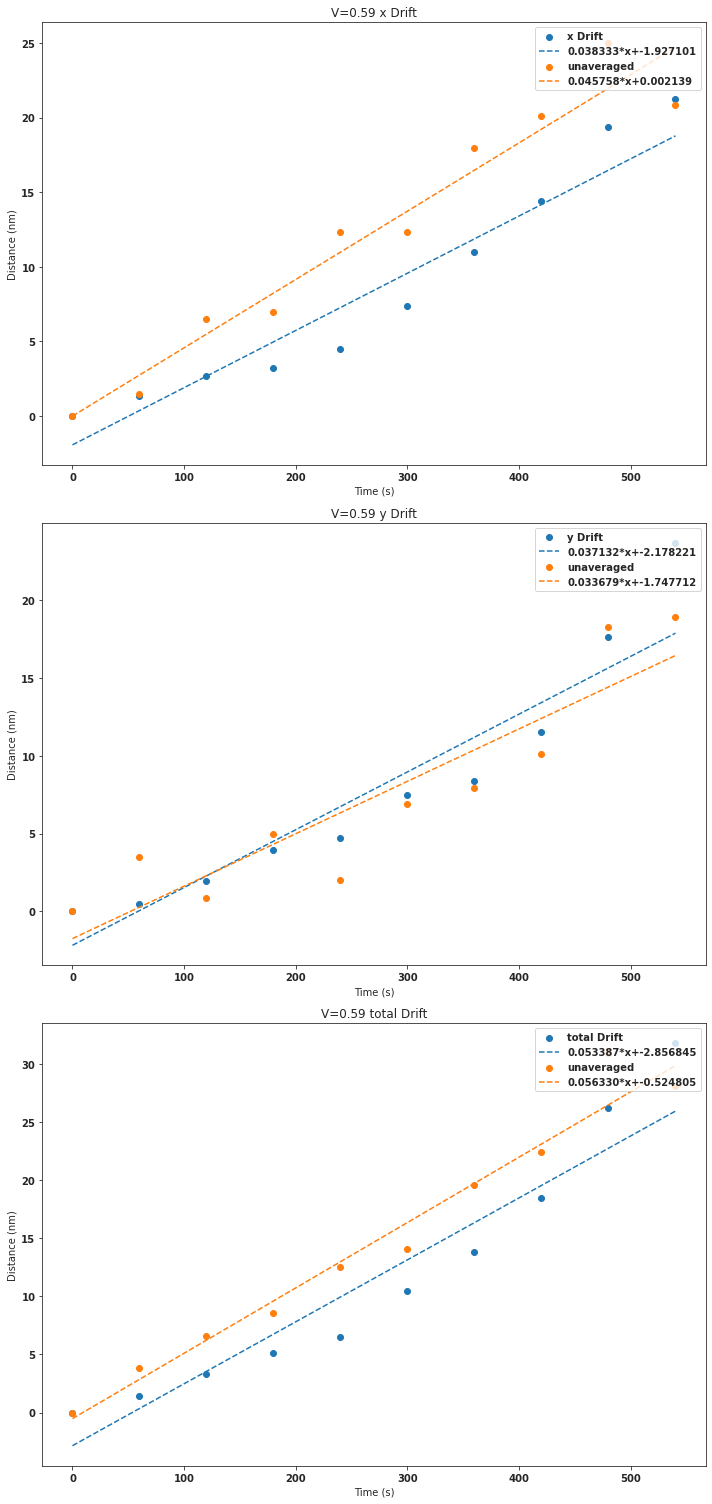

(array([0.03833257, 0.03713173, 0.05338662]),
 array([0.04575847, 0.03367872, 0.05633008]))

In [1051]:
plot_drift_fit_new(a_drift_new,7,y=True,x=True,total=True,mdrifts=mdrift,m=m,nmax=10, show=True, save=False,weighted=True)

In [980]:

def plot_drift_fit(a_drift,voltage_set_number,y=True,x=True,total=True,measured=False,m=None,nmax=nmax, show=True, save=False,weighted=True):
    """takes in a_drift, an output from the avg_drift_vs_time thing, a set number, 
    and plot it. x,y, total are optional to decide what is plotted, measured and m is to compare with raw drift""" 
    def fit(n,x,sigma):
        a,b=scipy.optimize.curve_fit((lambda x,a,b:a*x+b),n,x,sigma=sigma)
        return a,b


    font = {'family': 'sans-serif','weight' : 'bold','size'   : 10}
   
    mpl.rc('font', **font)
    rc({'axes.labelsize':'medium'})
    mpl.rc('text',usetex =False)
    if show or save:
        fig,axes=plt.subplots(y+x+total, figsize=(10,7*(y+x+total)))
    a=a_drift.loc[a_drift['vset'] == voltage_set_number]
    a=a[a['n']<nmax]
    counter=0
    names=['x','y','total']
    q= [x,y,total]
    index=0
    slope=[]
    measured_slope=[]
    if measured and m!=None:
            real1=m.drifts[voltage_set_number]
            real=real1[real1.index<nmax]
            real=real.sort_index()*m.NM_PER_PIXEL
            total_real=np.sqrt(real['y']**2+real['x']**2)
    for i in q:
        if i:
            if weighted:
                e,d=fit(a['n']*m.DIFFUSION_TIME,a[f'{names[index]}'],sigma=1/np.sqrt(SIZE+1-a['n']))
            else:
                e,d=fit(a['n']*m.DIFFUSION_TIME,a[f'{names[index]}'],sigma=None)
            
            slope.append(e[0])
            if show or save!=False:
                if x+y+total==1:
                    axes.set_title(f'V={voltages_temperatures[voltage_set_number]:.2f} {names[index]} Drift')
                    axes.set_xlabel('Time (s)')
                    axes.set_ylabel('Distance (nm)')
                    axes.scatter(a['n']*m.DIFFUSION_TIME,a[f'{names[index]}'],label=f'{names[index]} Drift')
                    axes.plot(a['n']*m.DIFFUSION_TIME,e[0]*a['n']*m.DIFFUSION_TIME+e[1],'--',label=f'{e[0]:3f}*x+{e[1]:3f}')
                else:
                    axes[counter].set_title(f'V={voltages_temperatures[voltage_set_number]:.2f} {names[index]} Drift')
                    axes[counter].set_xlabel('Time (s)')
                    axes[counter].set_ylabel('Distance (nm)')
                    axes[counter].scatter(a['n']*m.DIFFUSION_TIME,a[f'{names[index]}'],label=f'{names[index]} Drift')
                    axes[counter].plot(a['n']*m.DIFFUSION_TIME,e[0]*a['n']*m.DIFFUSION_TIME+e[1],'--',label=f'{e[0]:3f}*x+{e[1]:3f}')
            if measured and m!=None:
                    
                if index==2:
                    f,g=fit(a['n']*m.DIFFUSION_TIME,total_real[0:nmax],sigma=None)
                    if show or save!=False:
                        if x+y+total==1:
                            axes.scatter(a['n']*m.DIFFUSION_TIME,total_real[0:nmax],label="unaveraged")
                            axes.plot(a['n']*m.DIFFUSION_TIME,f[0]*a['n']*m.DIFFUSION_TIME+f[1],'--',label=f'{f[0]:3f}*x+{f[1]:3f}')
                        else:
                            axes[counter].scatter(a['n']*m.DIFFUSION_TIME,total_real[0:nmax],label="unaveraged")
                            axes[counter].plot(a['n']*m.DIFFUSION_TIME,f[0]*a['n']*m.DIFFUSION_TIME+f[1],'--',label=f'{f[0]:3f}*x+{f[1]:3f}')
                    measured_slope.append(f[0])
                elif index!=2:
                    f,g=fit(a['n']*m.DIFFUSION_TIME,real[f'{names[index]}'],sigma=None)
                    if show or save!=False:
                        if x+y+total==1:
                            axes.scatter(a['n']*m.DIFFUSION_TIME,real[f'{names[index]}'],label='unaveraged')
                            axes.plot(a['n']*m.DIFFUSION_TIME,f[0]*a['n']*m.DIFFUSION_TIME+f[1],'--',label=f'{f[0]:3f}*x+{f[1]:3f}')
                        else:
                            axes[counter].scatter(a['n']*m.DIFFUSION_TIME,real[f'{names[index]}'],label='unaveraged')
                            axes[counter].plot(a['n']*m.DIFFUSION_TIME,f[0]*a['n']*m.DIFFUSION_TIME+f[1],'--',label=f'{f[0]:3f}*x+{f[1]:3f}')
                    measured_slope.append(f[0])
            if show:
                if x+y+total==1:
                    axes.legend(loc=1)
                else:
                    axes[counter].legend(loc=1)
            counter+=1
        index+=1 
    if show:
        fig.tight_layout()
    if save!=False:
        plt.savefig('./Luc Folder/'+save)
    if show:
        plt.show()
    return (np.array(slope),np.array(measured_slope))

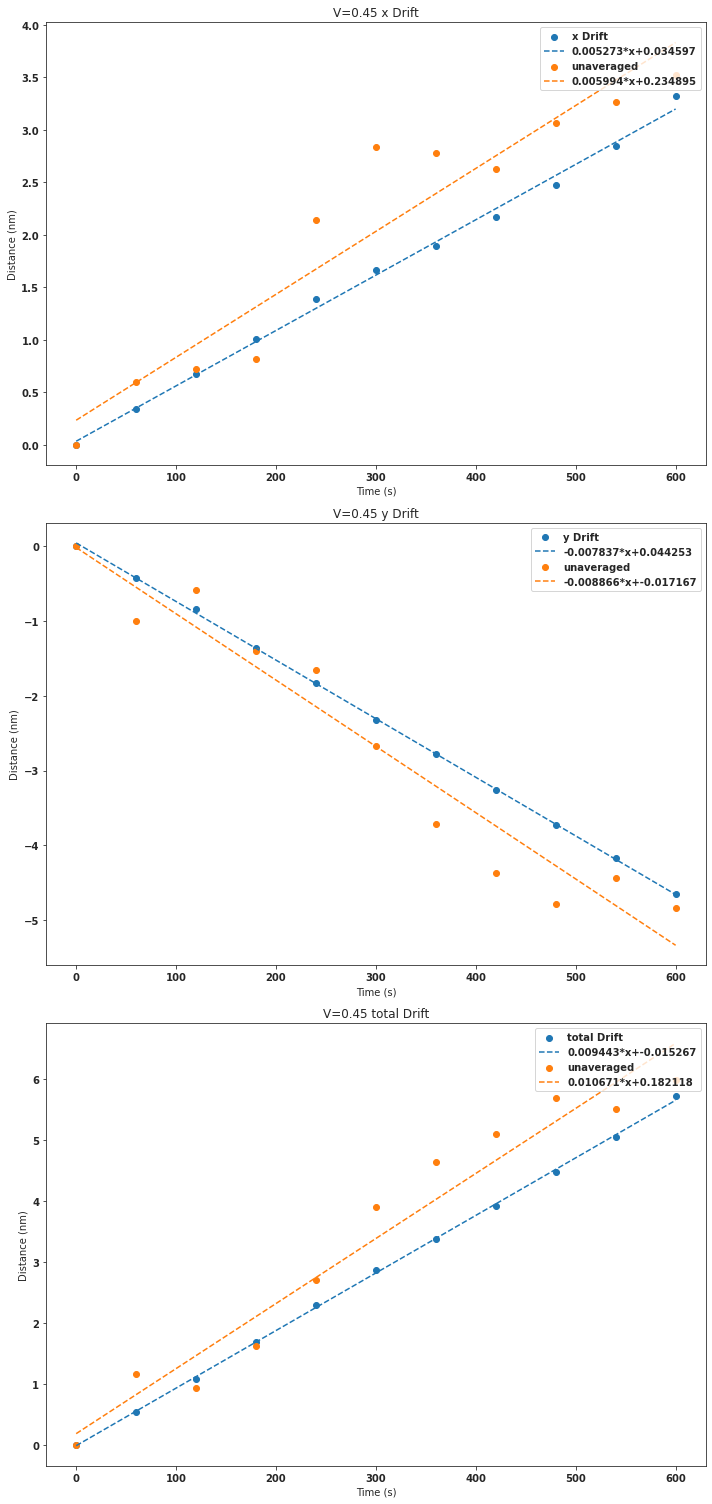

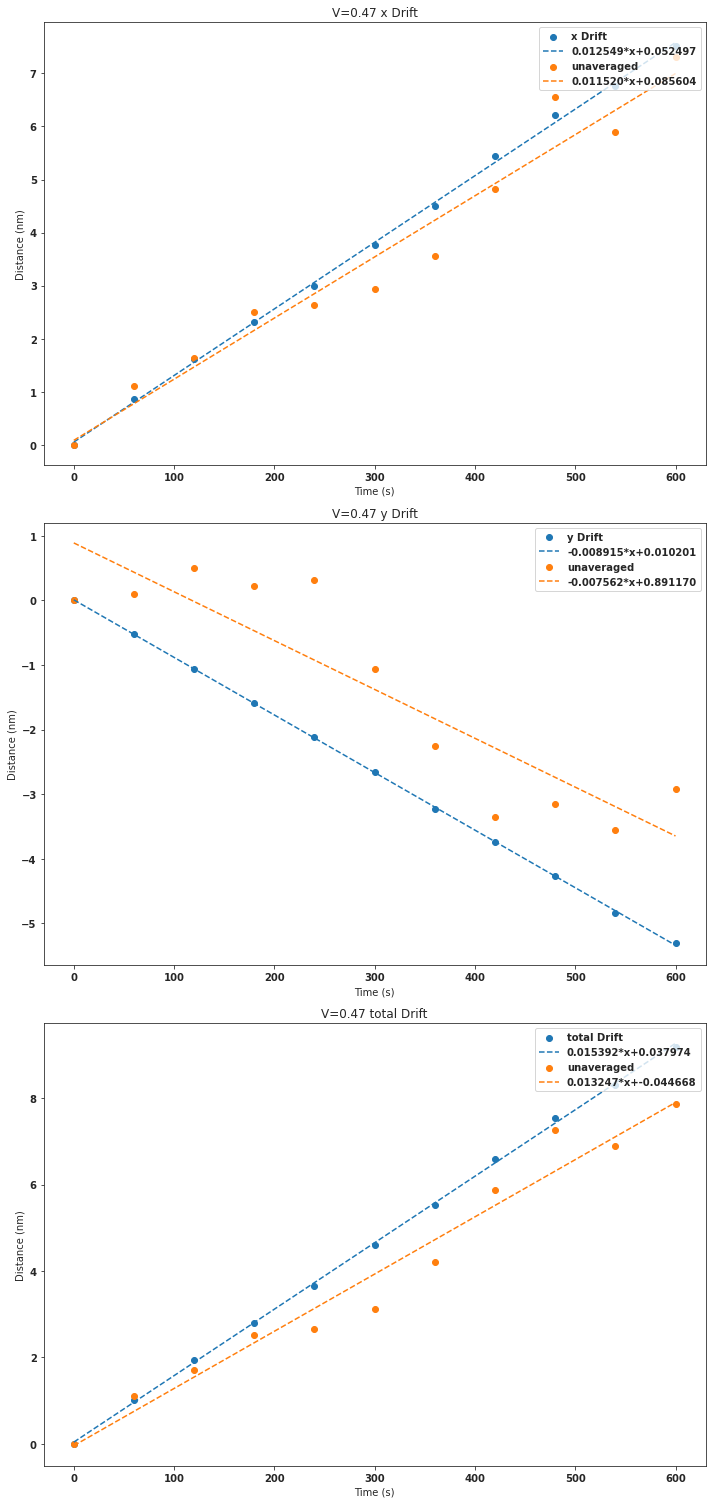

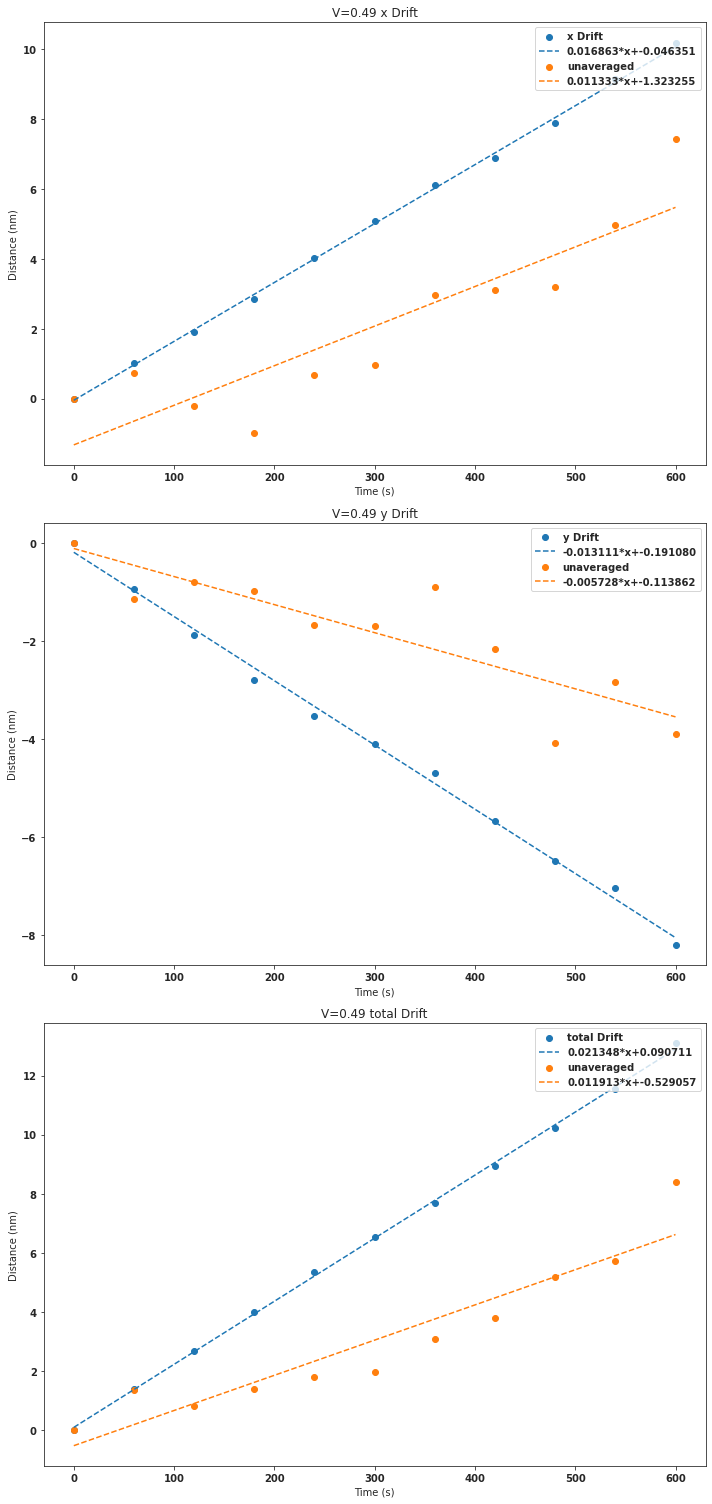

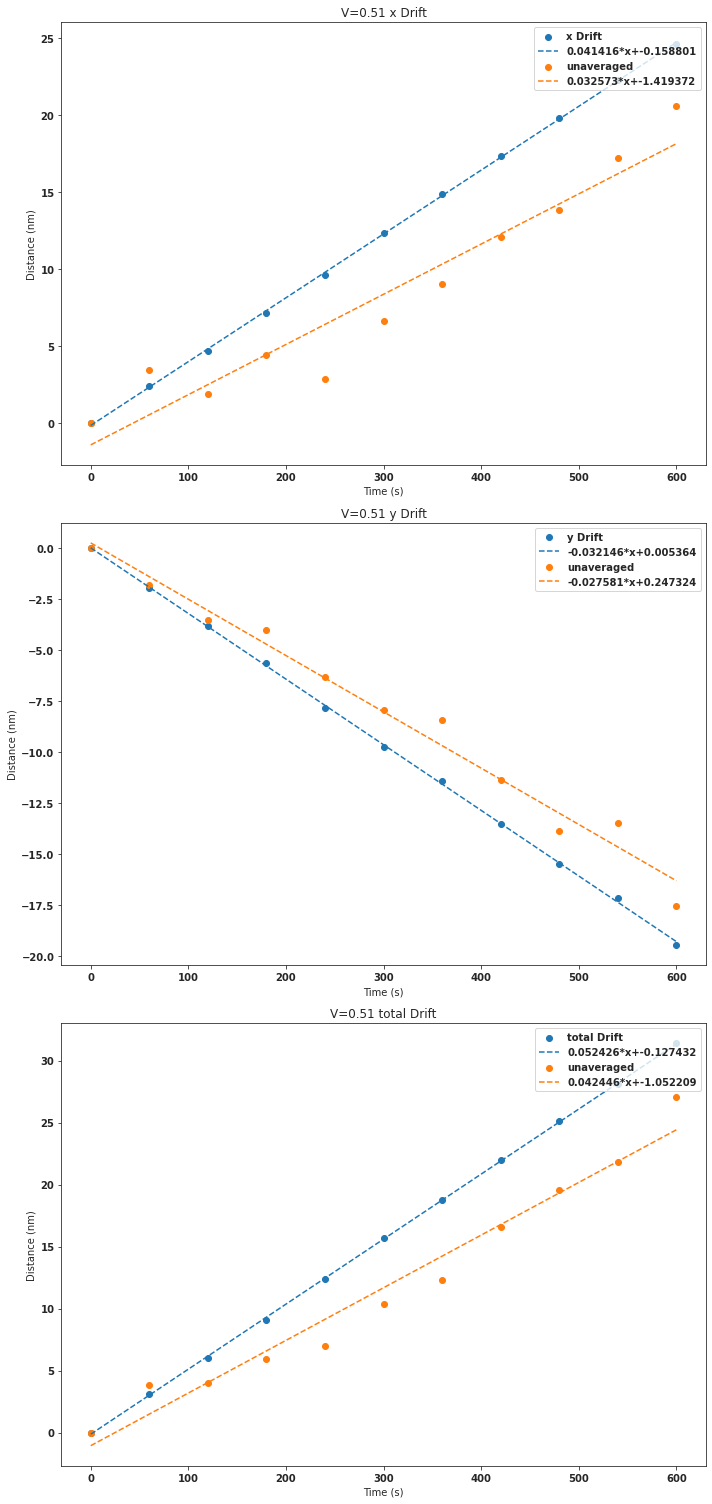

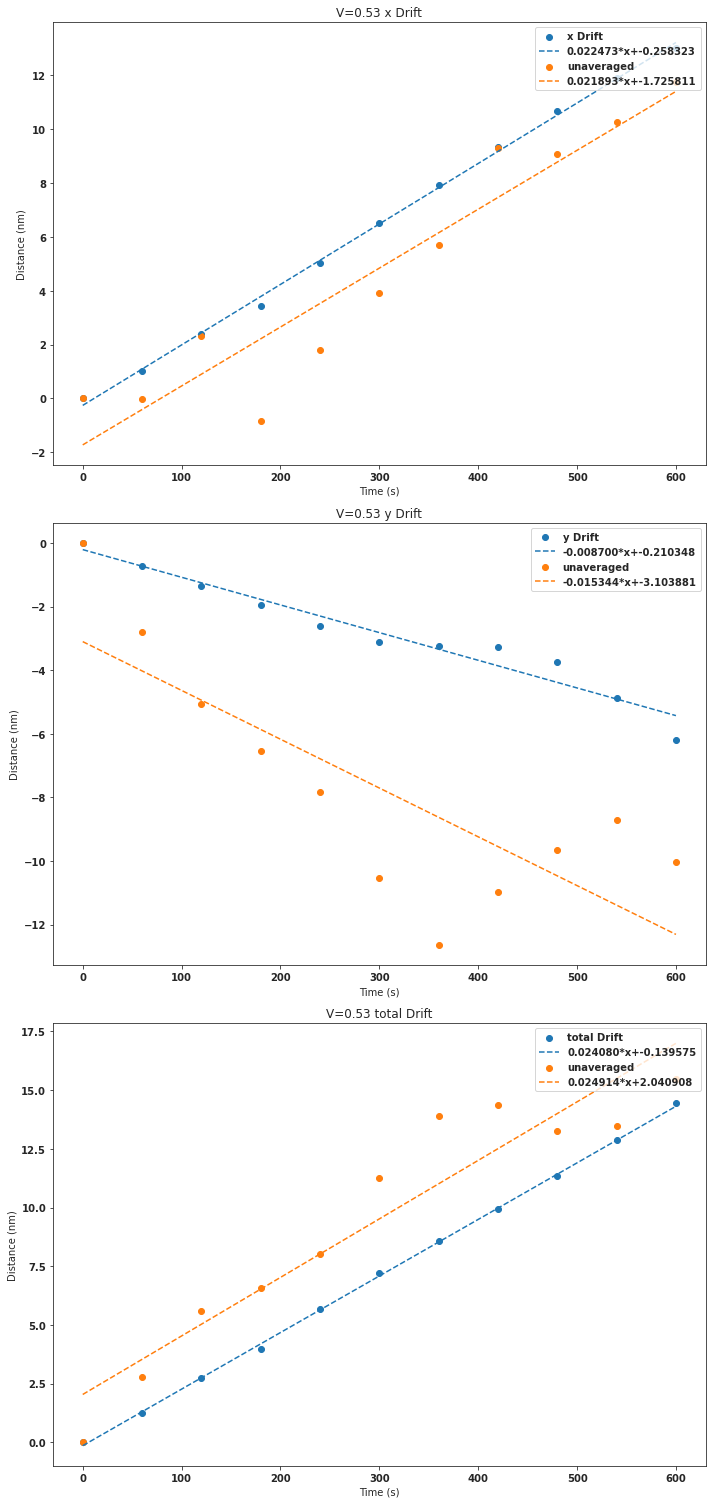

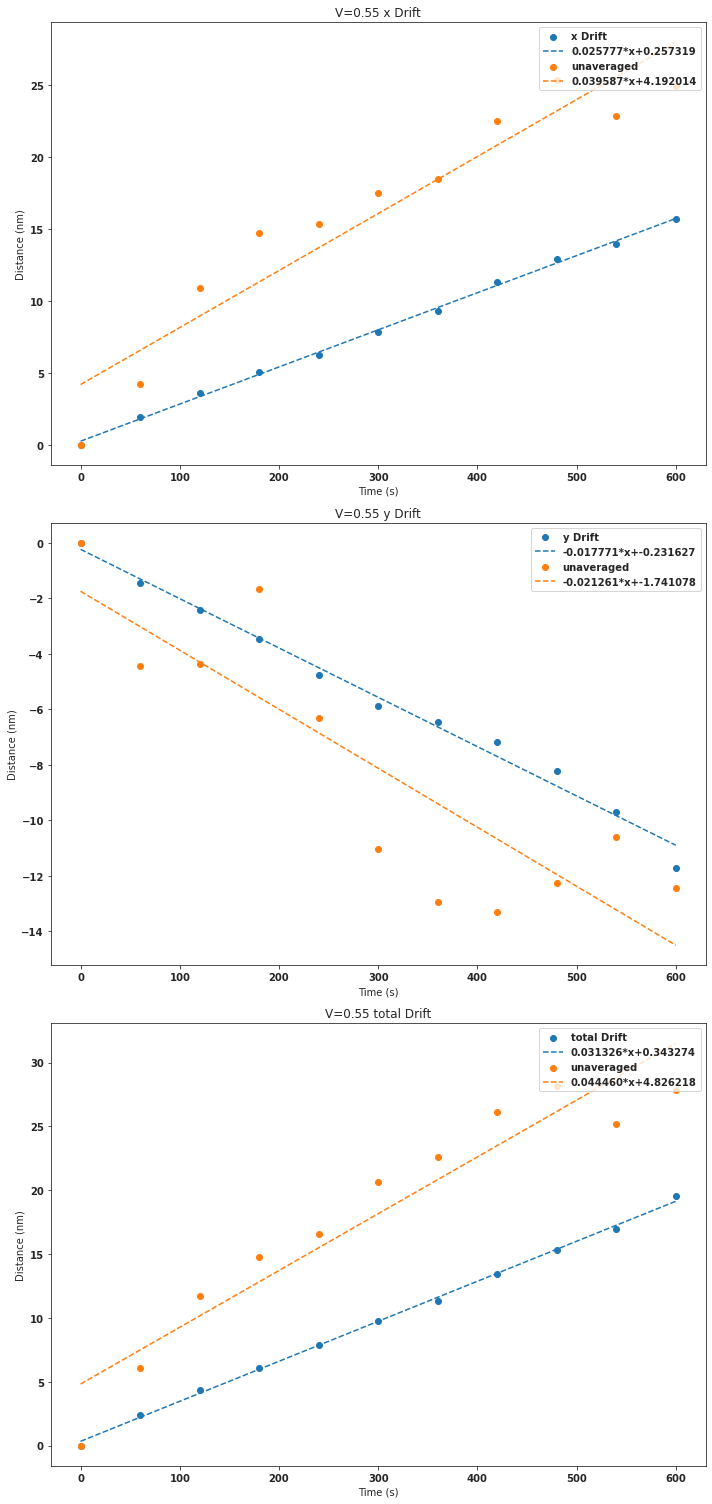

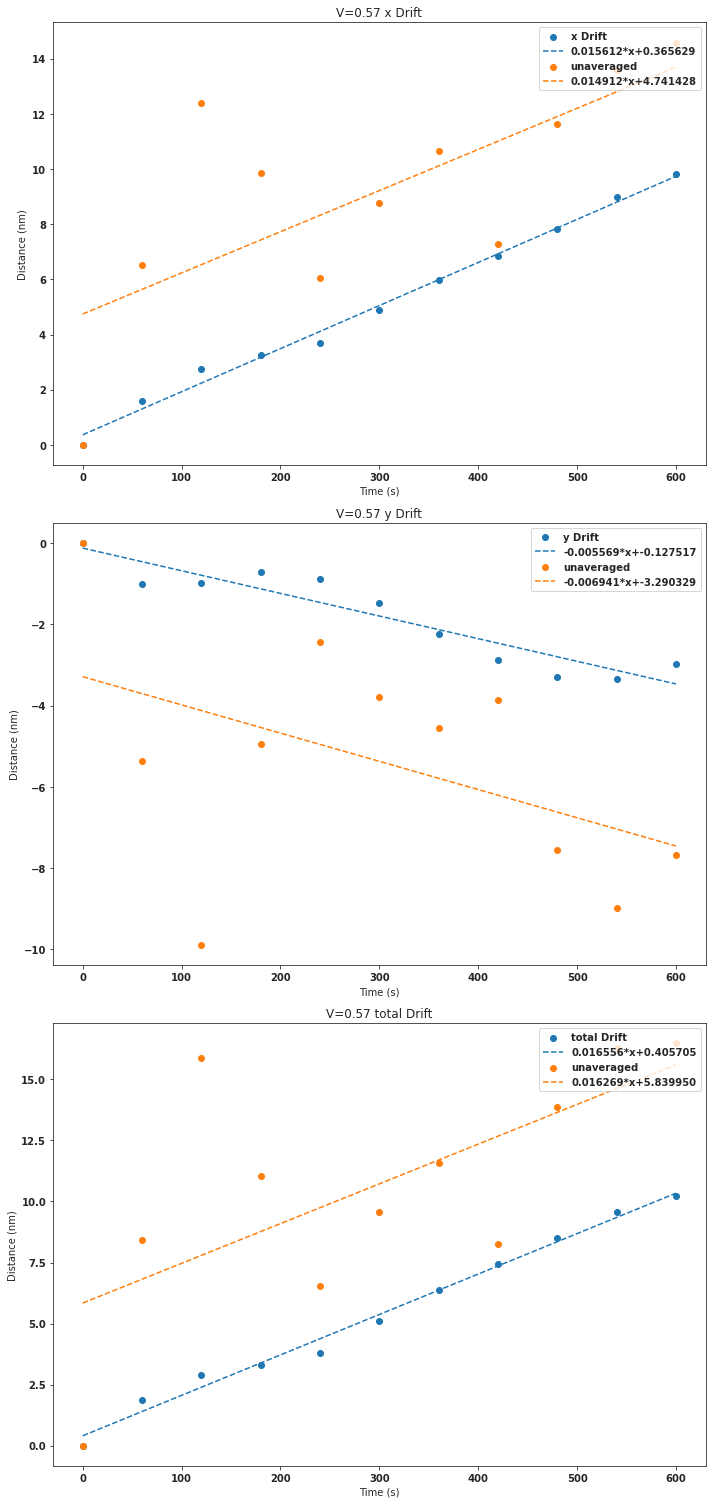

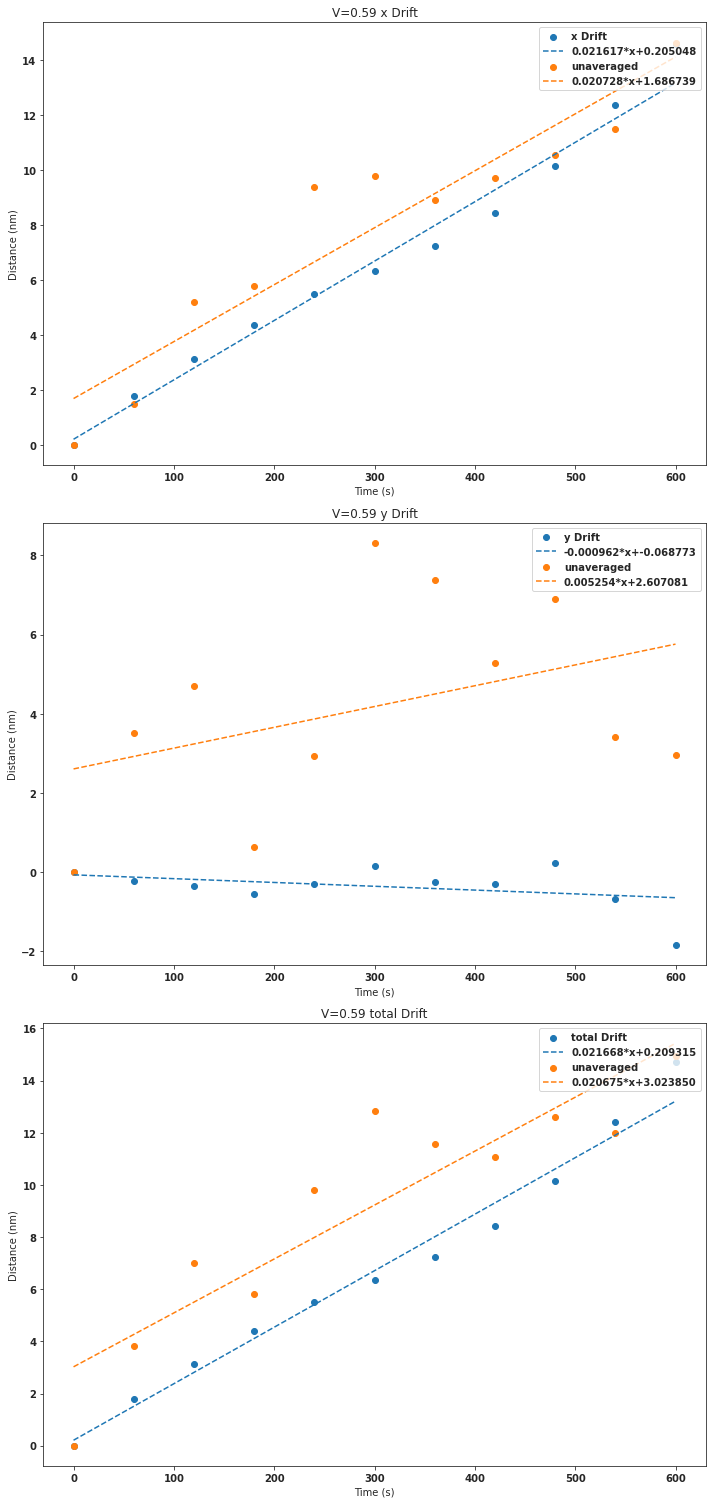

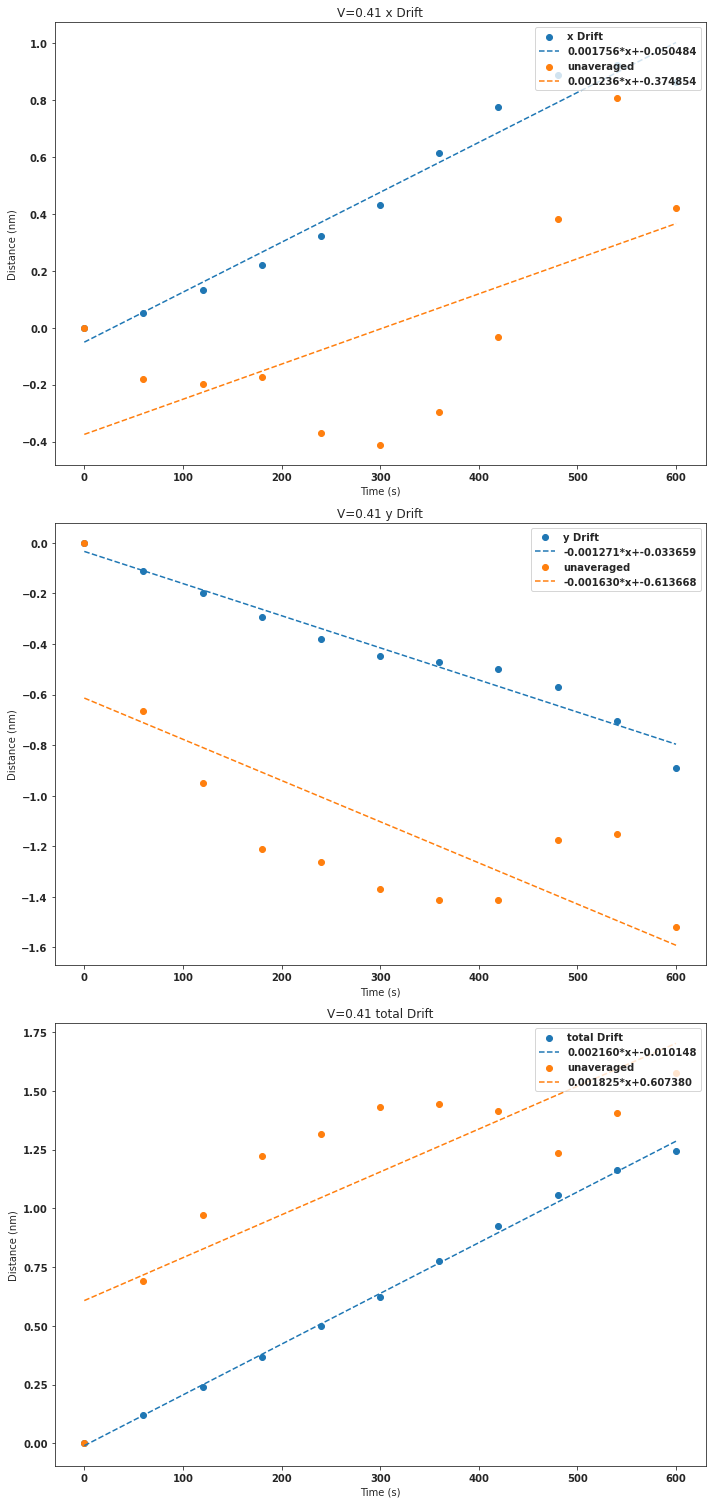

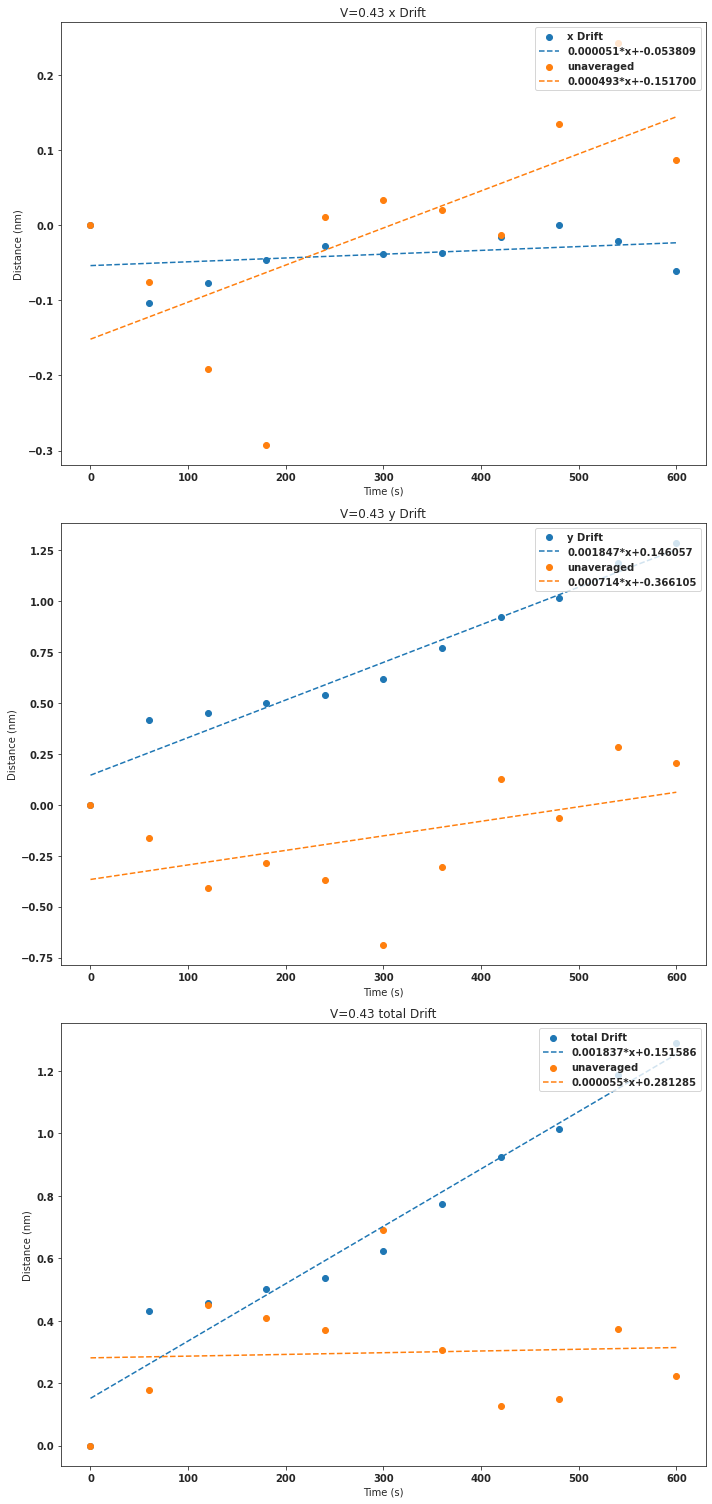

(array([ 0.01254915, -0.00891469,  0.01539158]),
 array([ 0.01152024, -0.00756226,  0.0132471 ]))

In [981]:
#Plotting all the sets
datas=[]
for i in range (np.size(voltages_temperatures)):
    a=plot_drift_fit(a_drift,i,measured=True,y=True,x=True,nmax=11,m=m,show=True,save=f'test{FOLDER} {voltages_temperatures[i]:.2f}.png')
    datas.append(a)
datas[1]

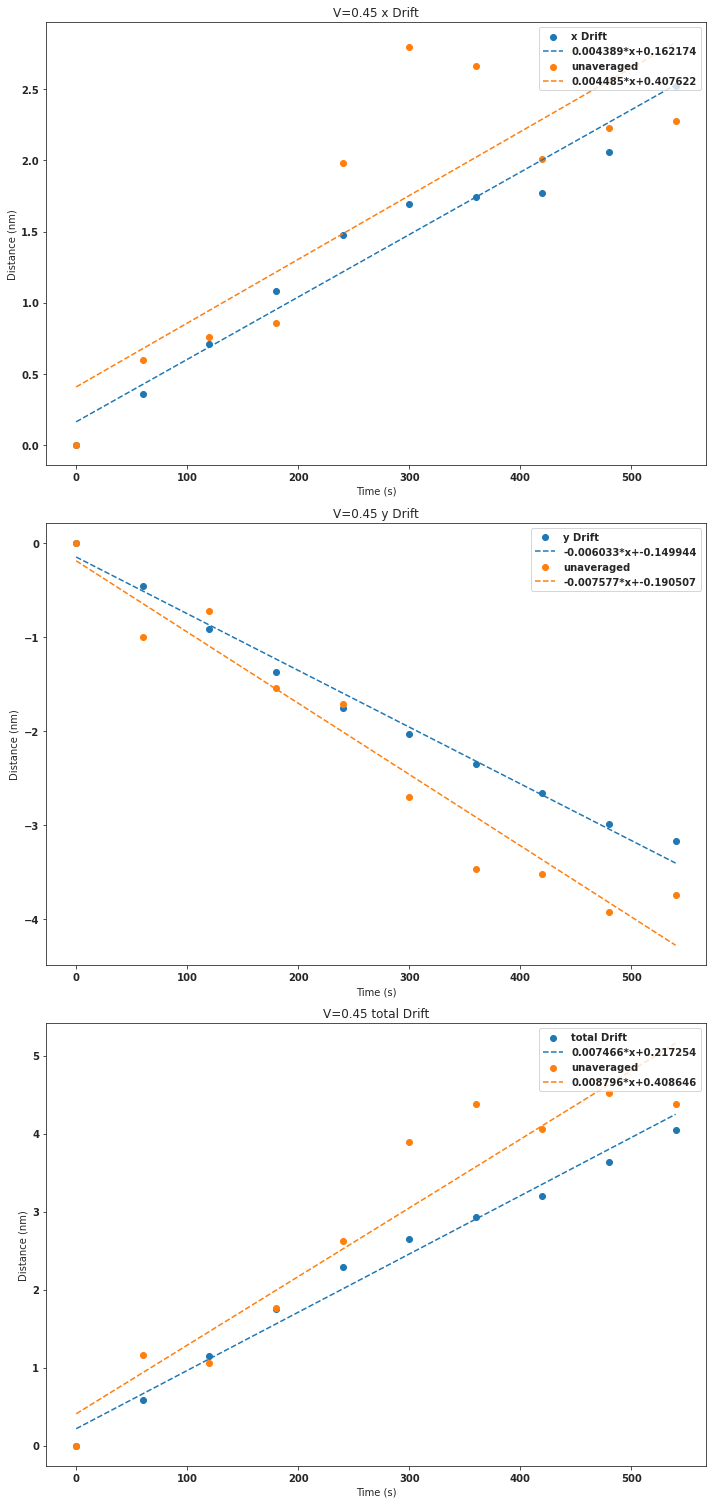

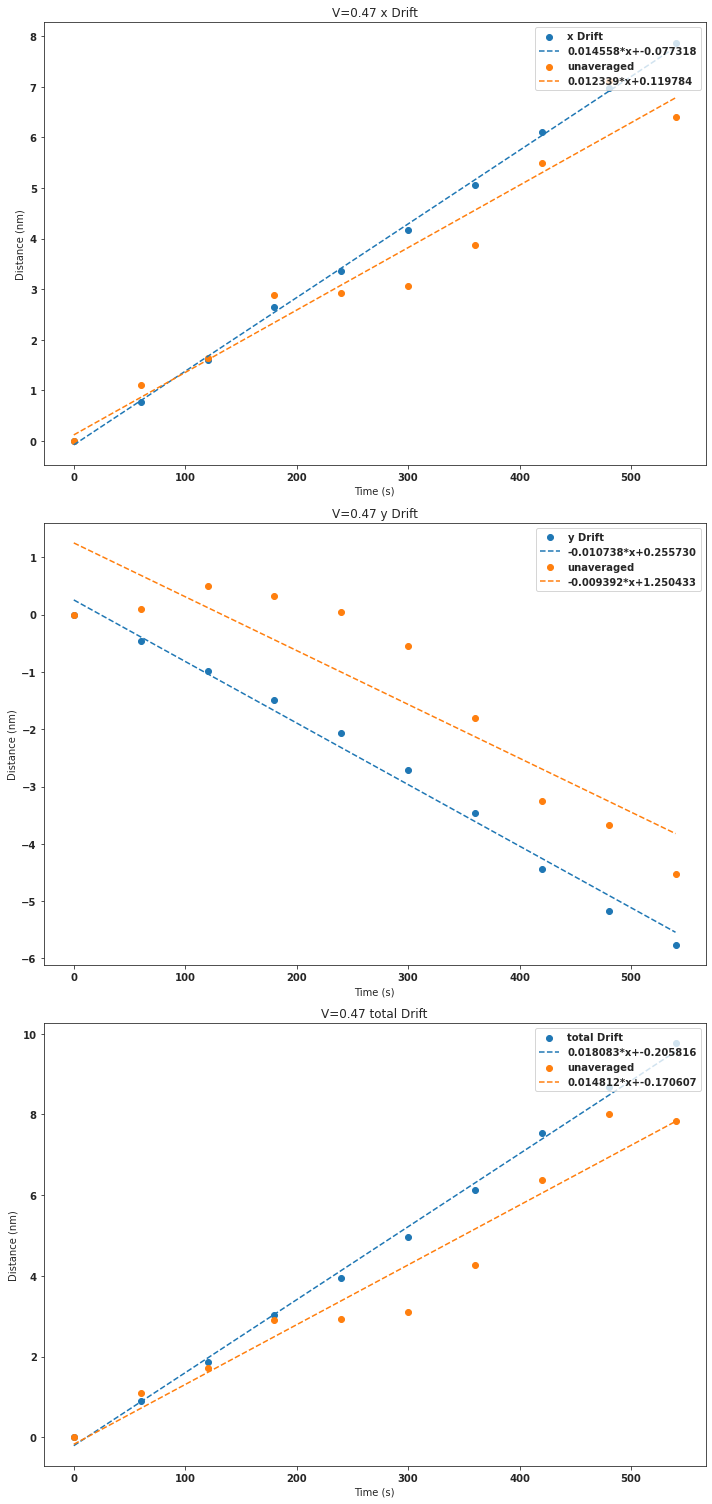

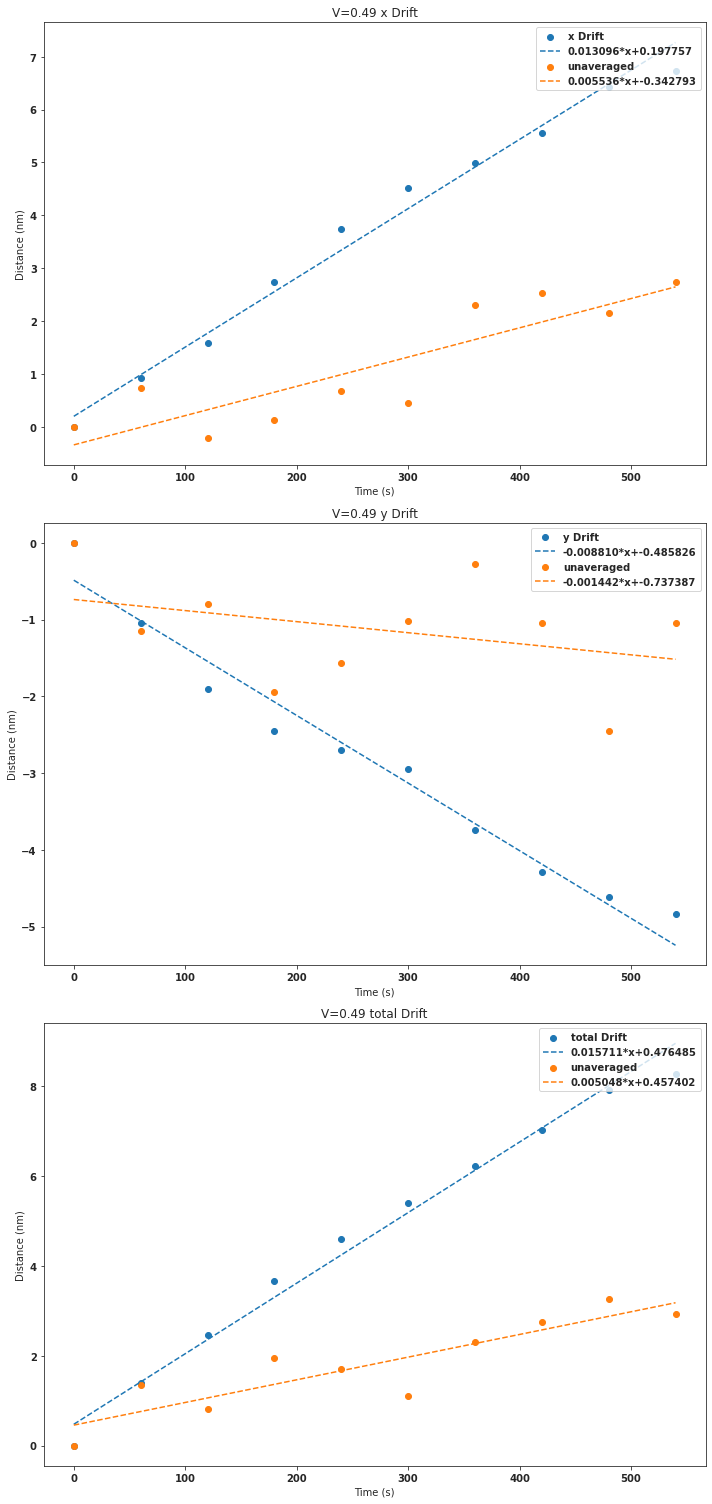

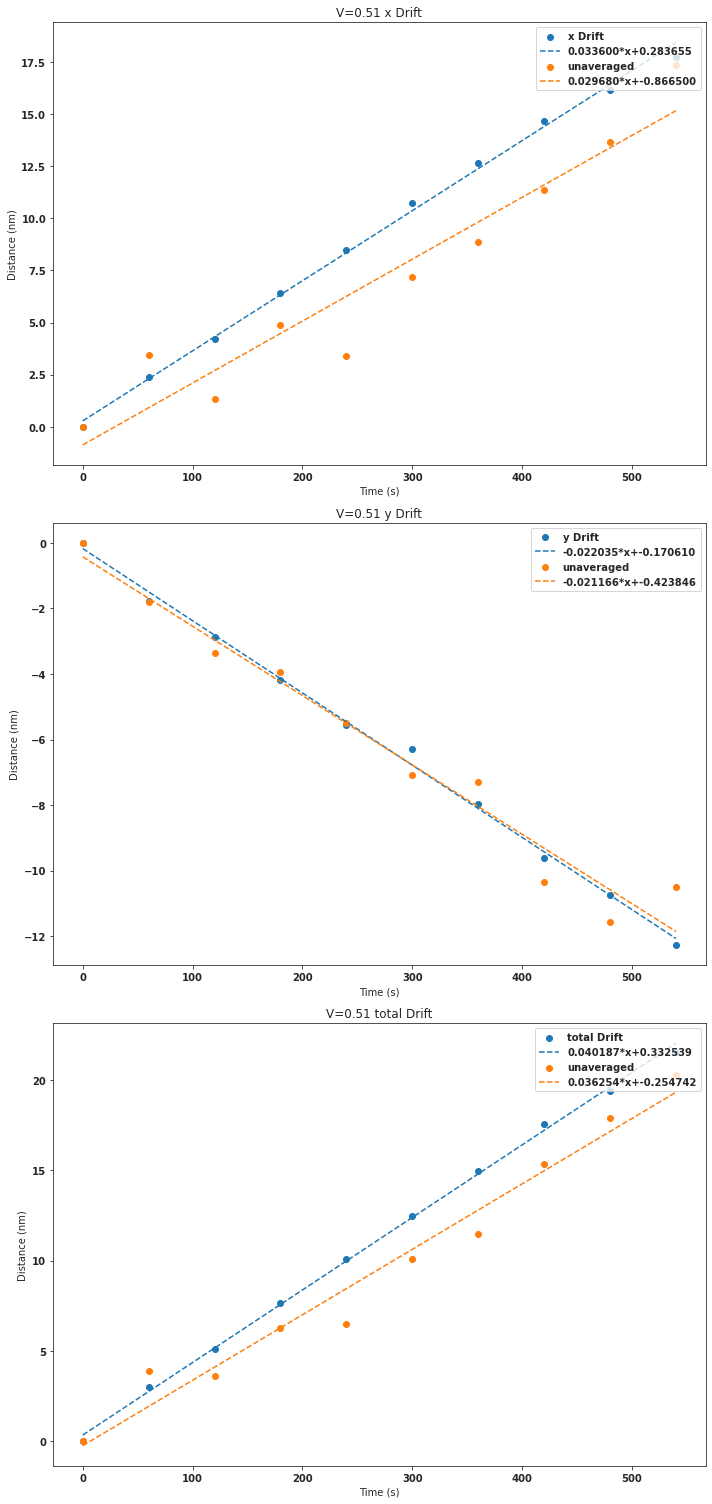

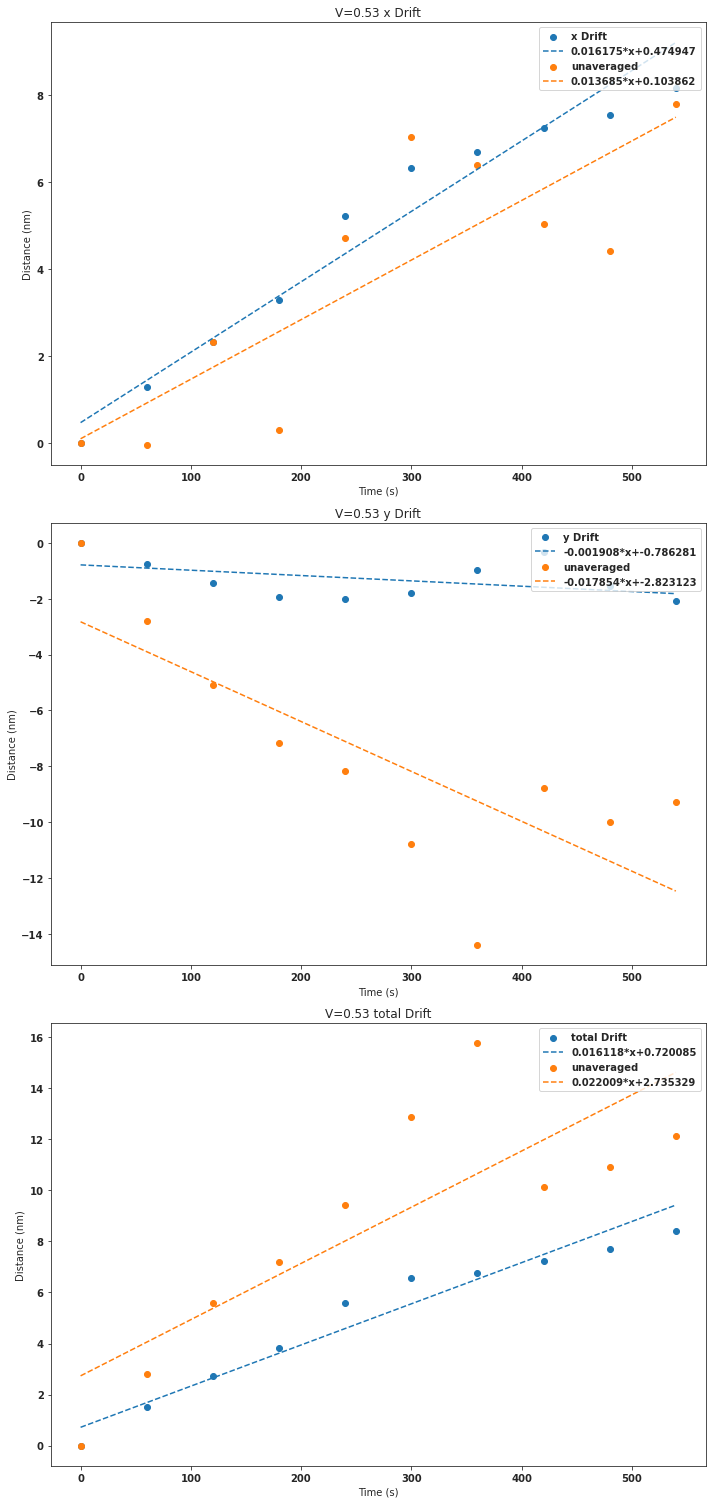

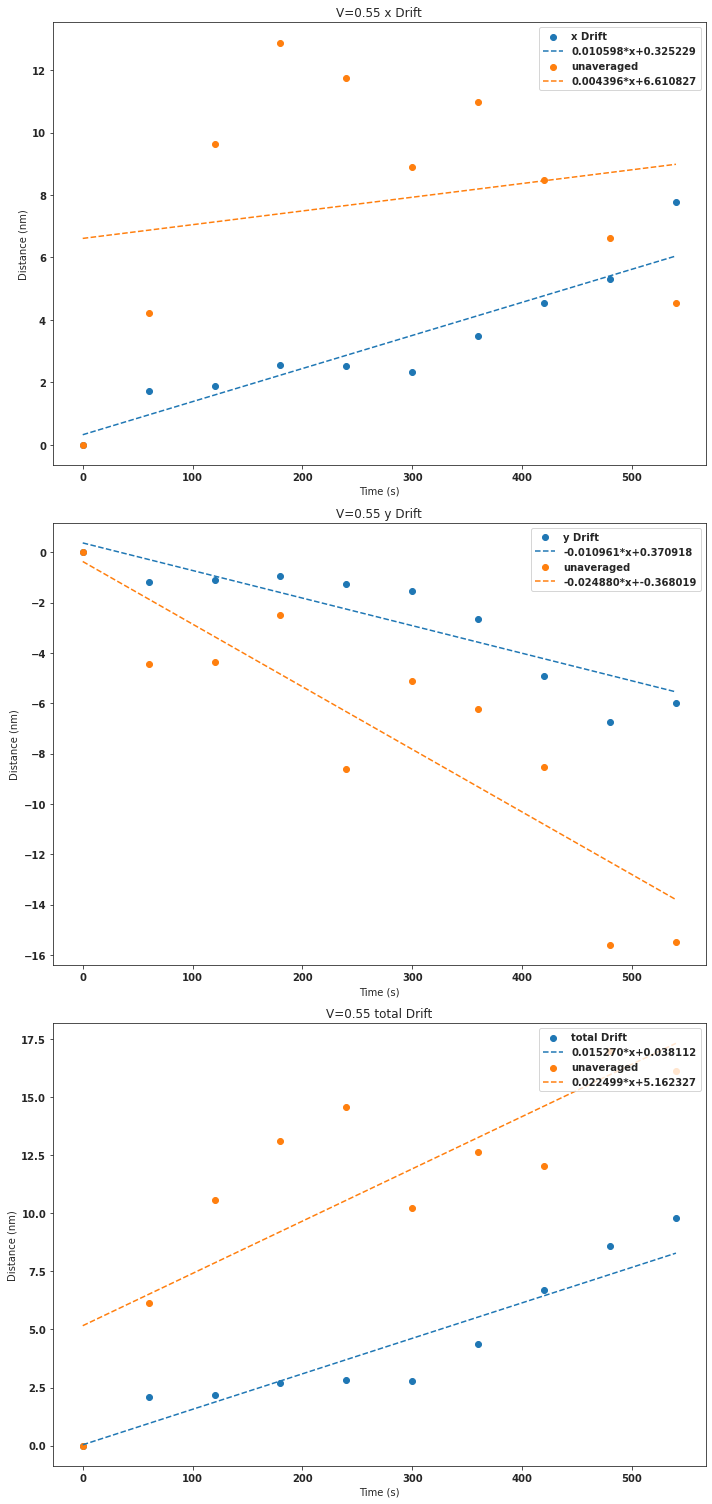

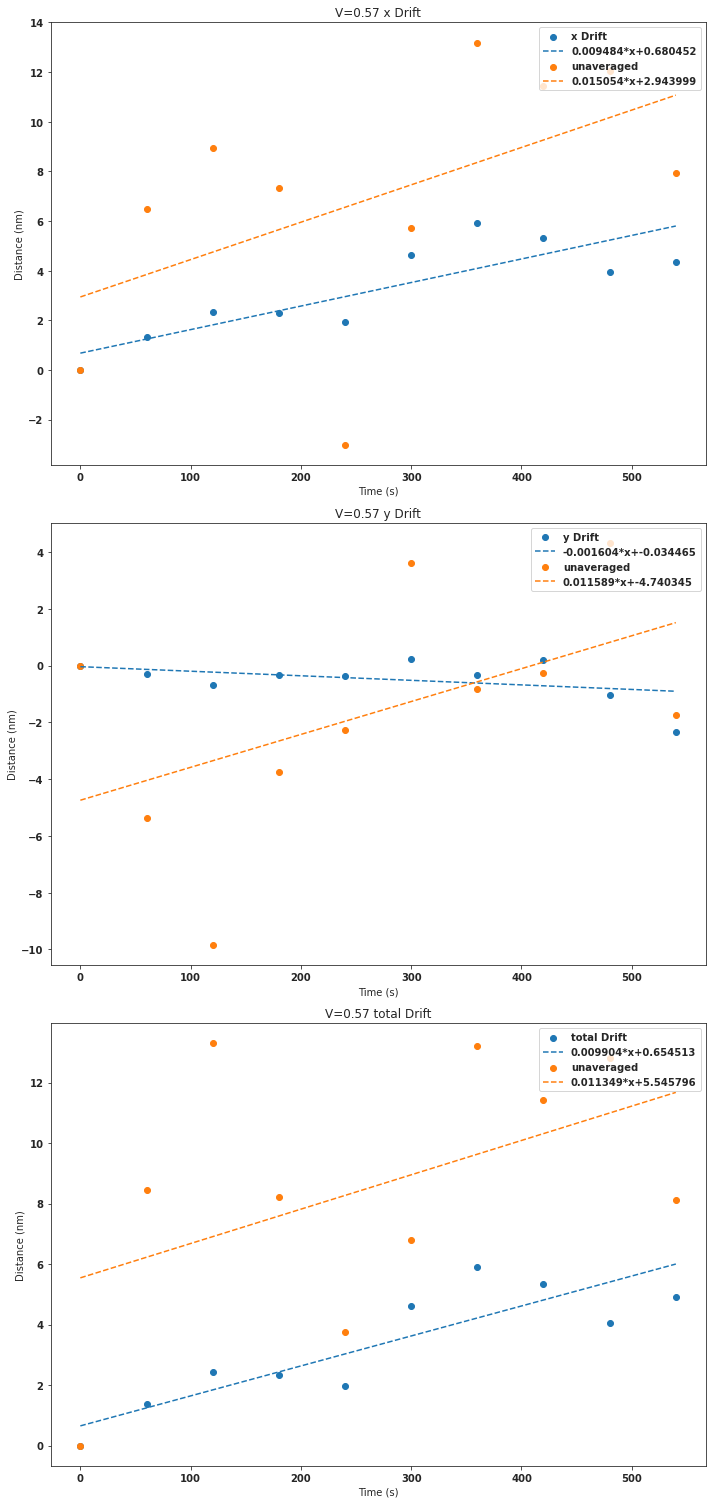

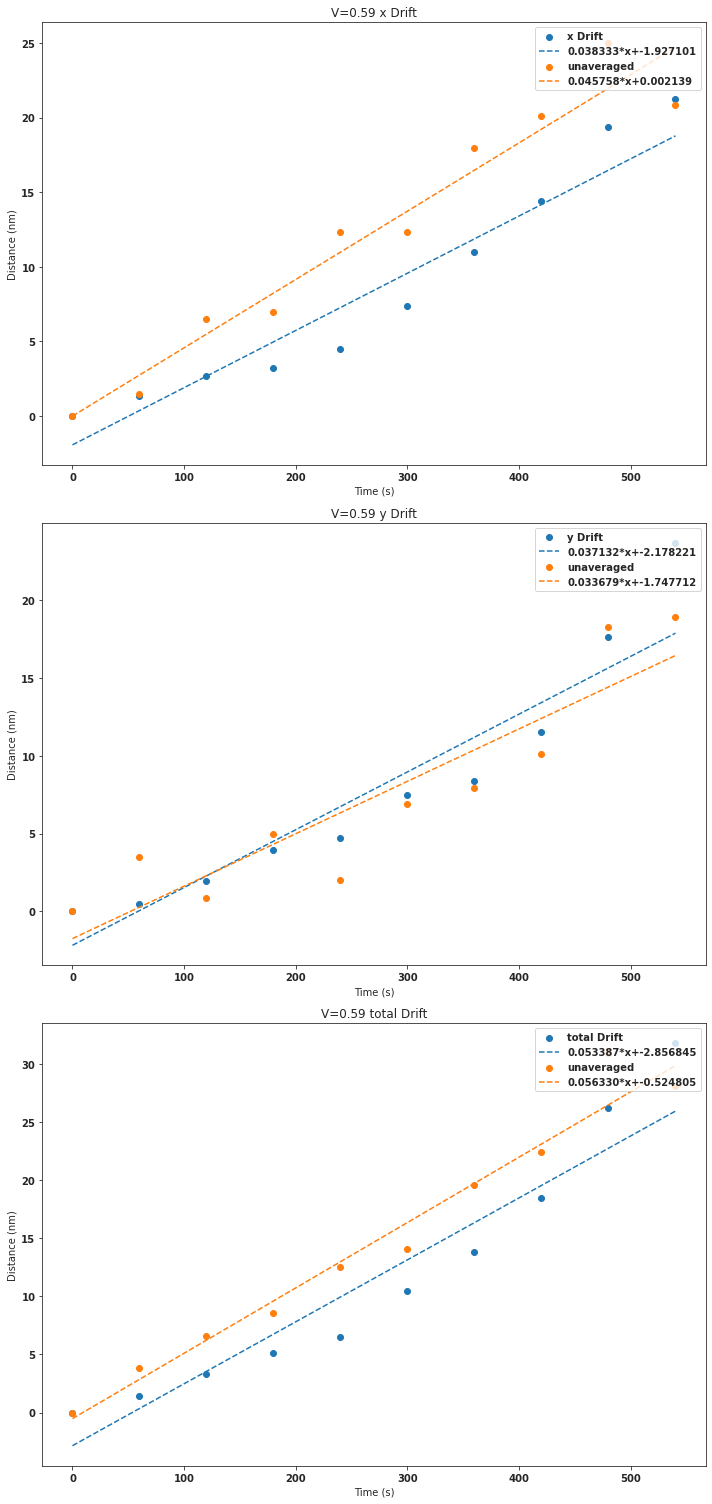

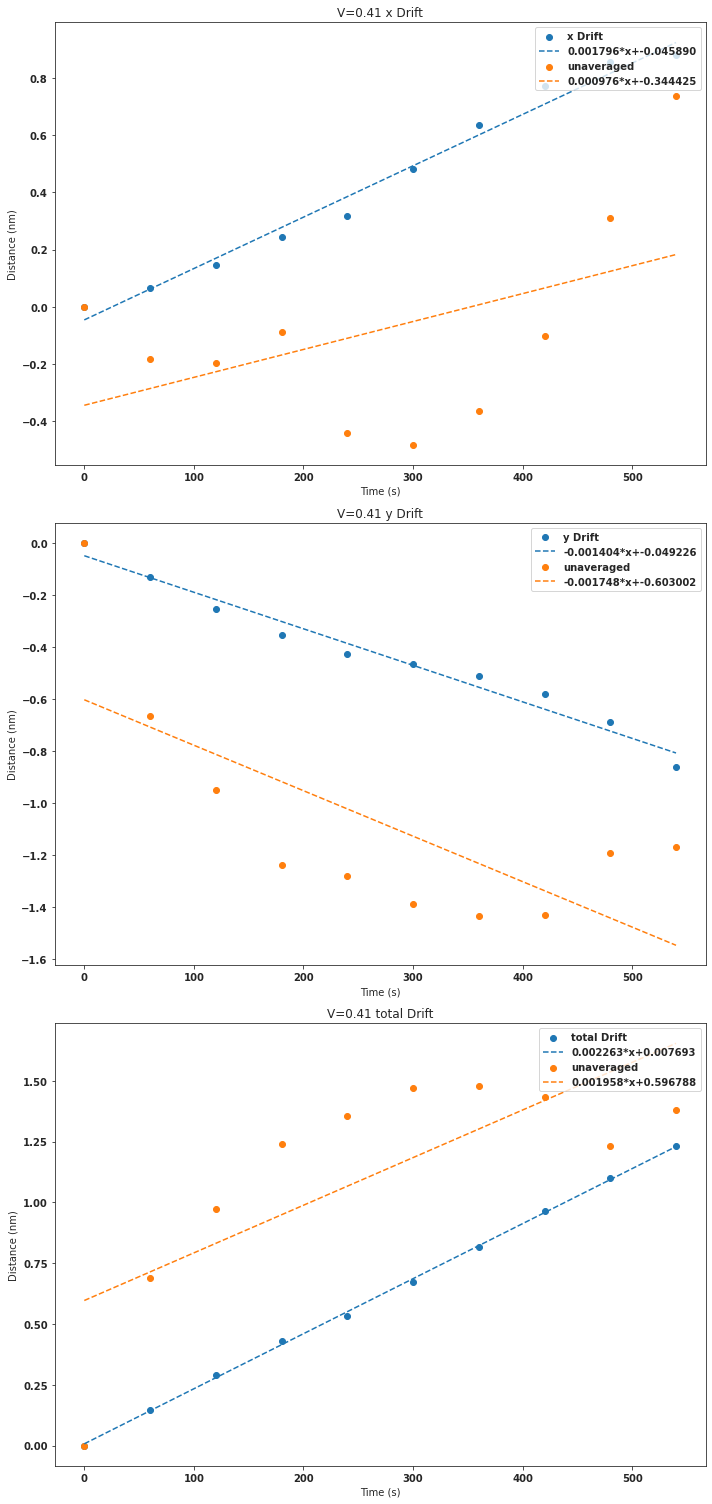

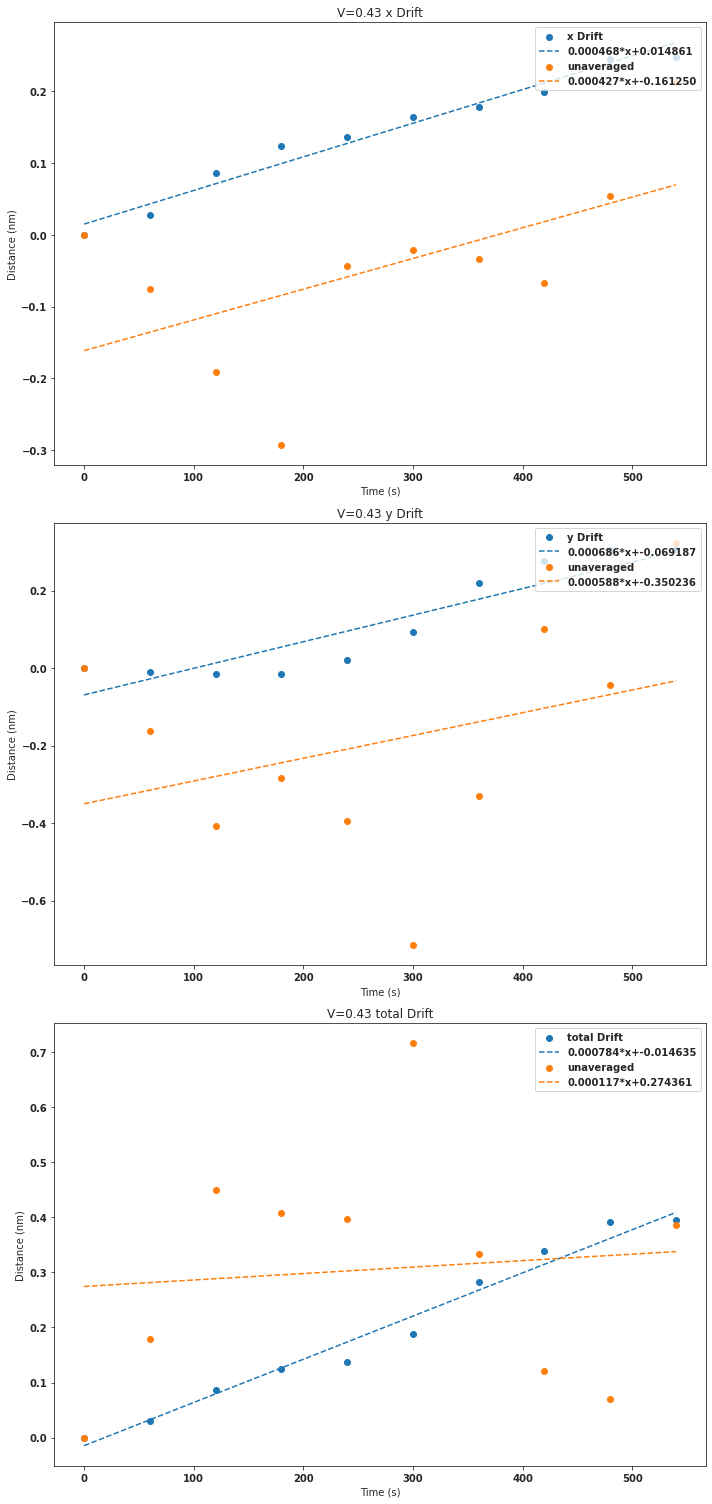

In [1052]:
#Plotting all the sets new
datas2=[]
for i in range (np.size(voltages_temperatures)):
    a=plot_drift_fit_new(a_drift_new,i,mdrifts=mdrift,nmax=10,y=True,x=True,m=m,show=True,save=f'test{FOLDER} {voltages_temperatures[i]:.2f}+new.png')
    datas2.append(a)

In [570]:
def plot_adrift_v(a_drift=a_drift,m=m,a=np.size(voltages_temperatures),fitfunc='connect',unadj=True,adj=True,p0=None,fitname=''):
    """takes in a_drift, m, a (points plotted from start), fitfunc (connect for no fit). 
    Plots drifts veloc vs voltages returns them, also returns fit parameters """
    #sorting by voltage temp
    font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 22}

    
    sort=voltages_temperatures.argsort()
    vt_sort=voltages_temperatures[sort]
    names=['x','y','Total']
    file=['','']
    data=[plot_drift_fit(a_drift,i,measured=True,m=m,show=False) for i in range(np.size(sort))]
    speeds=[np.array([data[trial][0][compo] for trial in range(np.size(sort))])[sort] for compo in range(3)]
    mspeeds=[np.array([data[trial][1][compo] for trial in range(np.size(sort))])[sort] for compo in range(3)]
    par1=None
    par2=None
    ymax_=np.array([np.amax(np.array(data)[:,:,q]) for q in range (3)])
    ymin_=np.array([np.amin(np.array(data)[:,:,q]) for q in range (3)])
    ymax=ymax_+0.1*(abs(ymax_-ymin_))
    ymin=ymin_-0.1*(abs(ymax_-ymin_))
    for q in range (3):
        plt.figure(figsize=(10,10))
        plt.rc('font', **font)
        plt.title(f'{names[q]} Drift Velocity vs Voltage')
        plt.xlabel('Voltage (V)')
        plt.ylabel('Velocity (nm/s)')
        plt.ylim(bottom=ymin[q],top=ymax[q])
        if unadj:
            file[0]='unadj'
            plt.scatter(vt_sort[:a],mspeeds[q][:a],label='Unadjusted')
            if fitfunc=='connect':
                plt.plot(vt_sort[:a],mspeeds[q][:a])
            else:
                par,cov=scipy.optimize.curve_fit(fitfunc,vt_sort[:a],mspeeds[q][:a],p0=p0,maxfev=5000)
                v=np.linspace(vt_sort[0],vt_sort[a],200)
                plt.plot(v,fitfunc(v,*par))
                par1=par
        if adj:
            file[1]='adj'
            plt.scatter(vt_sort[:a],speeds[q][:a],label='Adjusted')
            if fitfunc=='connect':
                plt.plot(vt_sort[:a],speeds[q][:a],)
            else:
                par,cov=scipy.optimize.curve_fit(fitfunc,vt_sort[:a],speeds[q][:a],p0=p0,maxfev=5000)
                v=np.linspace(vt_sort[0],vt_sort[a],200)
                plt.plot(v,fitfunc(v,*par))
                par2=par
        plt.legend()
        #plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
        #plt.savefig('./Luc Folder/'+f'{FOLDER}{names[q]}')
        plt.savefig(m.ANALYSIS_FOLDER + f"{file[1]}{file[0]}{names[q]}drift{fitname}.png")
    return([speeds,mspeeds,par1,par2])

        


In [1053]:
def plot_adrift_v_2(a_drift=a_drift_new,m=m,mdrift=mdrift,a=np.size(voltages_temperatures),fitfunc='connect',unadj=True,adj=True,p0=None,fitname=''):
    """takes in a_drift, m, a (points plotted from start), fitfunc (connect for no fit). 
    Plots drifts veloc vs voltages returns them, also returns fit parameters """
    #sorting by voltage temp
    font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 22}

    
    sort=voltages_temperatures.argsort()
    vt_sort=voltages_temperatures[sort]
    names=['x','y','Total']
    file=['','']
    data=[plot_drift_fit_new(a_drift_new,i,mdrifts=mdrift,m=m,show=False,nmax=10) for i in range(np.size(sort))]
    speeds=[np.array([data[trial][0][compo] for trial in range(np.size(sort))])[sort] for compo in range(3)]
    mspeeds=[np.array([data[trial][1][compo] for trial in range(np.size(sort))])[sort] for compo in range(3)]
    par1=None
    par2=None
    ymax_=np.array([np.amax(np.array(data)[:,:,q]) for q in range (3)])
    ymin_=np.array([np.amin(np.array(data)[:,:,q]) for q in range (3)])
    ymax=ymax_+0.1*(abs(ymax_-ymin_))
    ymin=ymin_-0.1*(abs(ymax_-ymin_))
    for q in range (3):
        plt.figure(figsize=(10,10))
        plt.rc('font', **font)
        plt.title(f'{names[q]} Drift Velocity vs Voltage')
        plt.xlabel('Voltage (V)')
        plt.ylabel('Velocity (nm/s)')
        plt.ylim(bottom=ymin[q],top=ymax[q])
        if unadj:
            file[0]='unadj'
            plt.scatter(vt_sort[:a],mspeeds[q][:a],label='Unadjusted')
            if fitfunc=='connect':
                plt.plot(vt_sort[:a],mspeeds[q][:a])
            else:
                par,cov=scipy.optimize.curve_fit(fitfunc,vt_sort[:a],mspeeds[q][:a],p0=p0,maxfev=5000)
                v=np.linspace(vt_sort[0],vt_sort[a],200)
                plt.plot(v,fitfunc(v,*par))
                par1=par
        if adj:
            file[1]='adj'
            plt.scatter(vt_sort[:a],speeds[q][:a],label='Adjusted')
            if fitfunc=='connect':
                plt.plot(vt_sort[:a],speeds[q][:a],)
            else:
                par,cov=scipy.optimize.curve_fit(fitfunc,vt_sort[:a],speeds[q][:a],p0=p0,maxfev=5000)
                v=np.linspace(vt_sort[0],vt_sort[a],200)
                plt.plot(v,fitfunc(v,*par))
                par2=par
        plt.legend()
        #plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
        #plt.savefig('./Luc Folder/'+f'{FOLDER}{names[q]}')
        plt.savefig(m.ANALYSIS_FOLDER + f"{file[1]}{file[0]}{names[q]}drift{fitname}new.png")
    return([speeds,mspeeds,par1,par2])

        



[[array([ 0.00092113, -0.00010365,  0.00566484,  0.01327757,  0.0173064 ,
          0.03969108,  0.01947374,  0.0237589 ,  0.01682167,  0.02436868]),
  array([-0.00154609,  0.00222717, -0.00926571, -0.01022367, -0.01326227,
         -0.03167498, -0.01072647, -0.01946186, -0.00750844, -0.00570637]),
  array([0.00182245, 0.00222886, 0.01085831, 0.01675848, 0.0218015 ,
         0.05078525, 0.02228642, 0.03072553, 0.01844177, 0.02505345])],
 [array([0.00147175, 0.00043919, 0.0054749 , 0.01282282, 0.01659975,
         0.04011915, 0.02096589, 0.02735387, 0.01728311, 0.02412316]),
  array([-0.00146207,  0.00024705, -0.00759385, -0.00885654, -0.01419698,
         -0.03209978, -0.01007481, -0.0188159 , -0.0058835 , -0.00581838]),
  array([1.67569583e-03, 4.86230632e-05, 9.32957684e-03, 1.51105237e-02,
         2.14086386e-02, 5.11426956e-02, 2.08348001e-02, 3.27523780e-02,
         1.82497582e-02, 2.26204846e-02])],
 None,
 None]

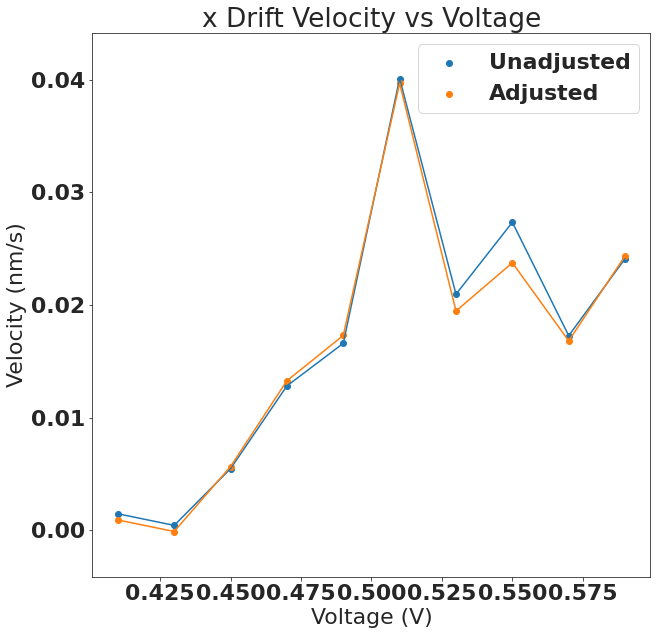

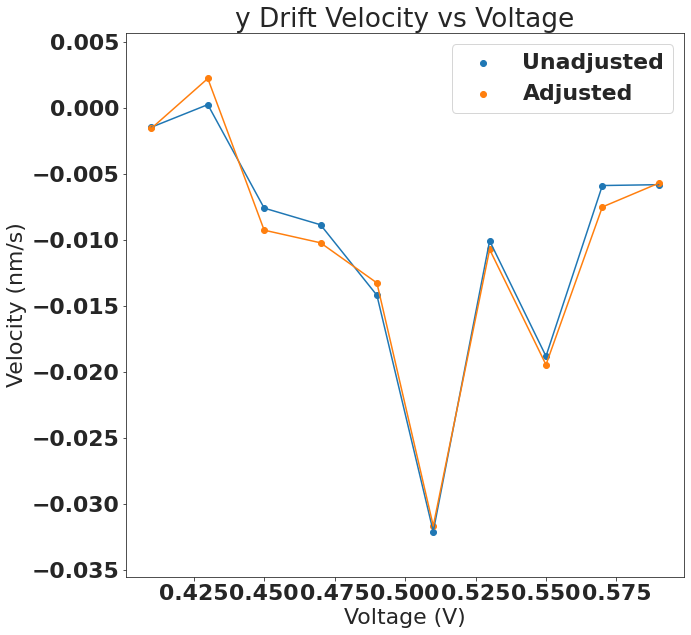

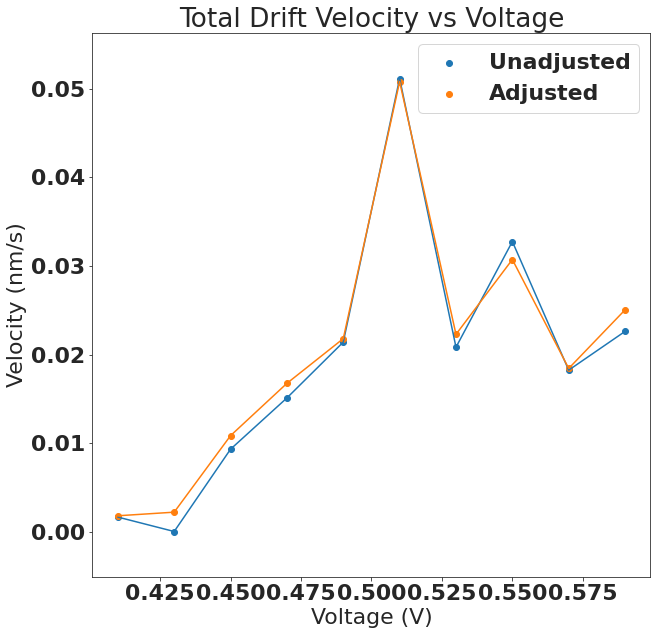

In [1055]:
plot_adrift_v(fitname=NAME)

[[array([0.00179619, 0.00046798, 0.0043885 , 0.01455762, 0.01309576,
         0.03360005, 0.01617513, 0.01059822, 0.00948438, 0.03833257]),
  array([-0.00140439,  0.00068583, -0.00603253, -0.01073831, -0.00880977,
         -0.02203492, -0.00190776, -0.0109614 , -0.00160444,  0.03713173]),
  array([0.00226259, 0.00078392, 0.00746579, 0.01808324, 0.01571091,
         0.04018663, 0.01611819, 0.01527042, 0.00990353, 0.05338662])],
 [array([0.0009761 , 0.00042747, 0.00448537, 0.01233866, 0.00553583,
         0.02967998, 0.01368466, 0.0043957 , 0.01505438, 0.04575847]),
  array([-0.00174796,  0.00058757, -0.00757667, -0.00939186, -0.0014419 ,
         -0.02116608, -0.0178542 , -0.0248799 ,  0.01158932,  0.03367872]),
  array([0.00195776, 0.00011715, 0.00879597, 0.01481176, 0.00504806,
         0.0362543 , 0.02200902, 0.02249894, 0.01134865, 0.05633008])],
 None,
 None]

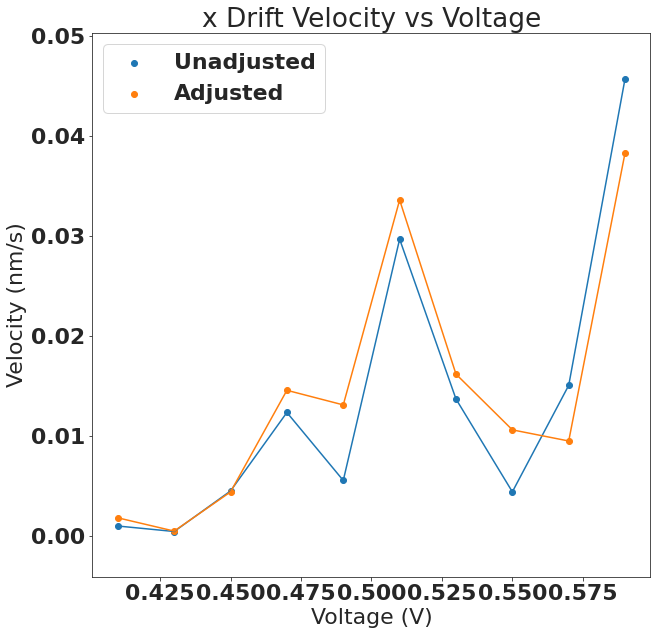

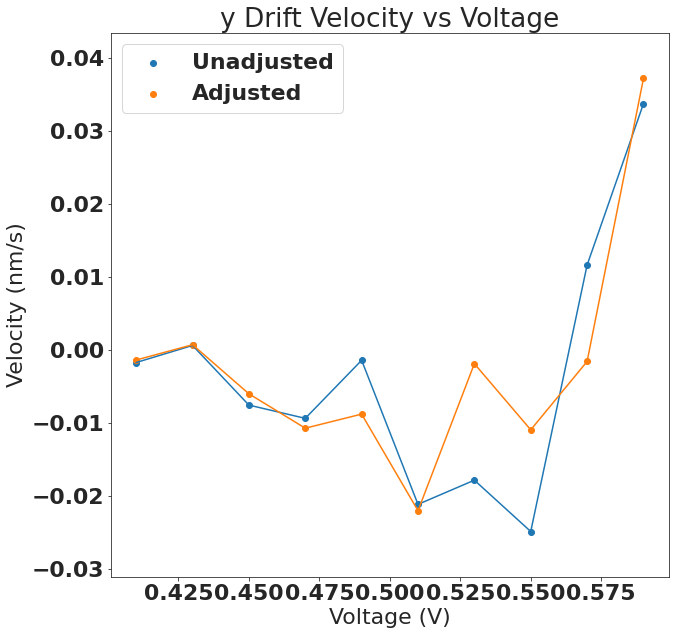

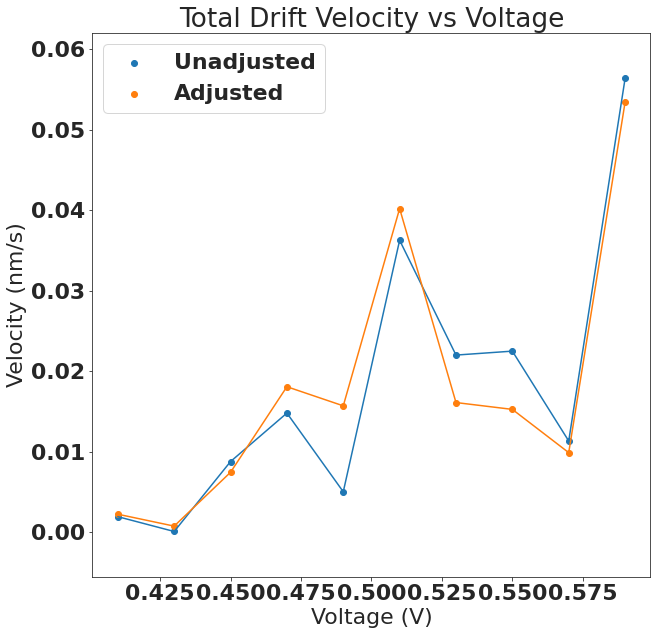

In [1056]:
plot_adrift_v_2(fitname=NAME)

/home/a/as/asai/dsgo/venv/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y, data. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


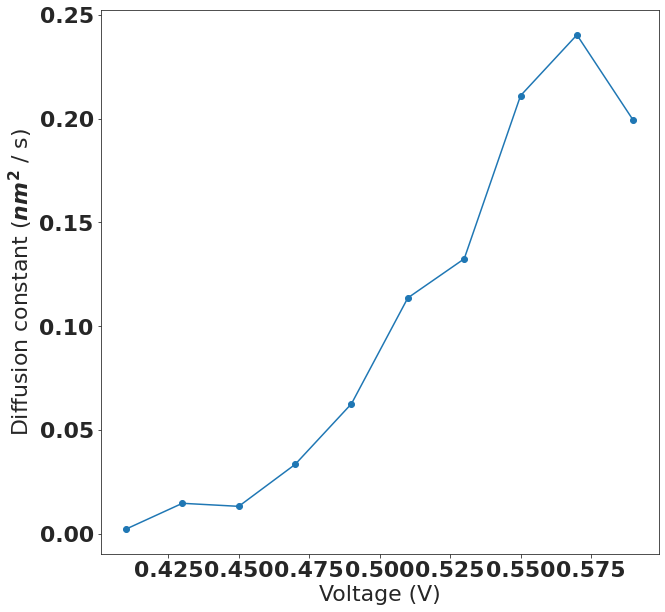

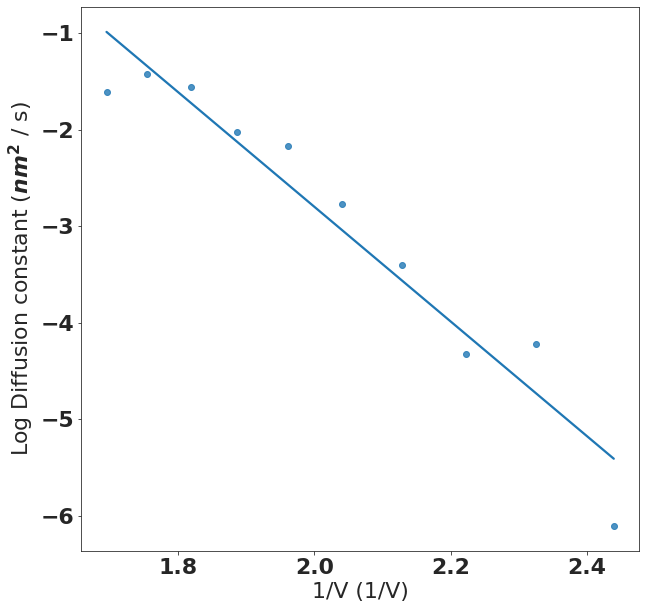

In [572]:
dp.plot_diffusion() #Plots diffusion constant as a function of voltage or temperature


/home/a/as/asai/dsgo/venv/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in power
  
/home/a/as/asai/dsgo/venv/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in power
  This is separate from the ipykernel package so we can avoid doing imports until


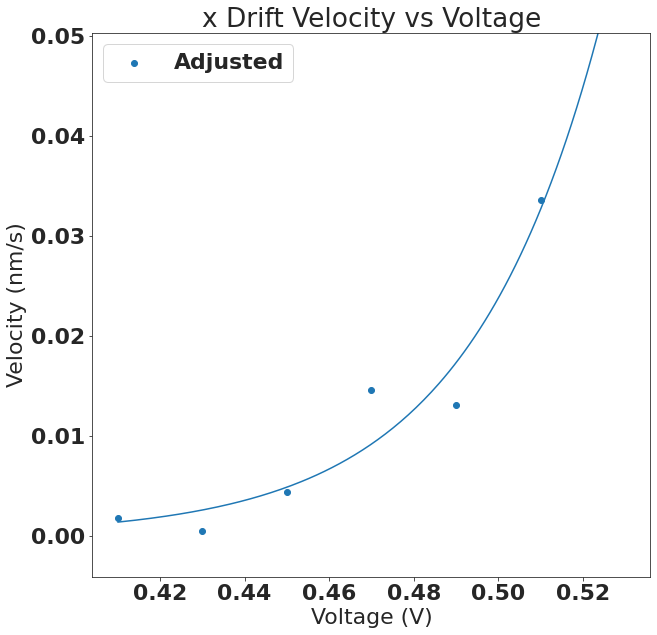

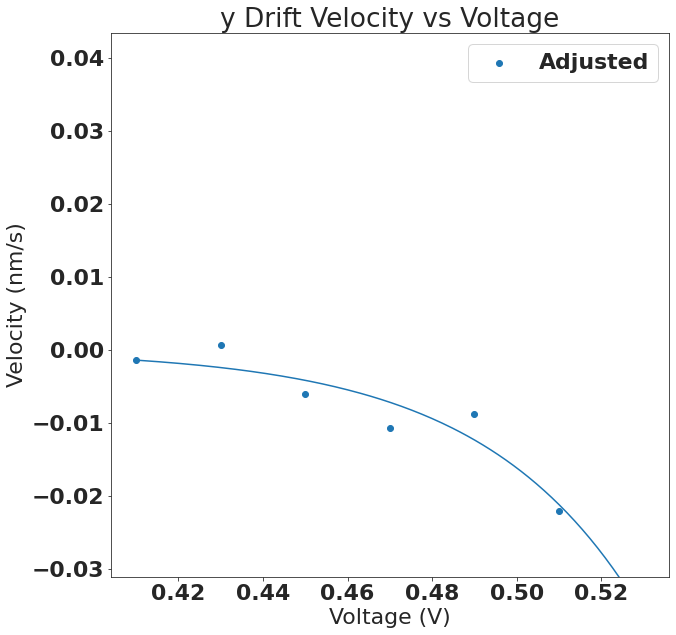

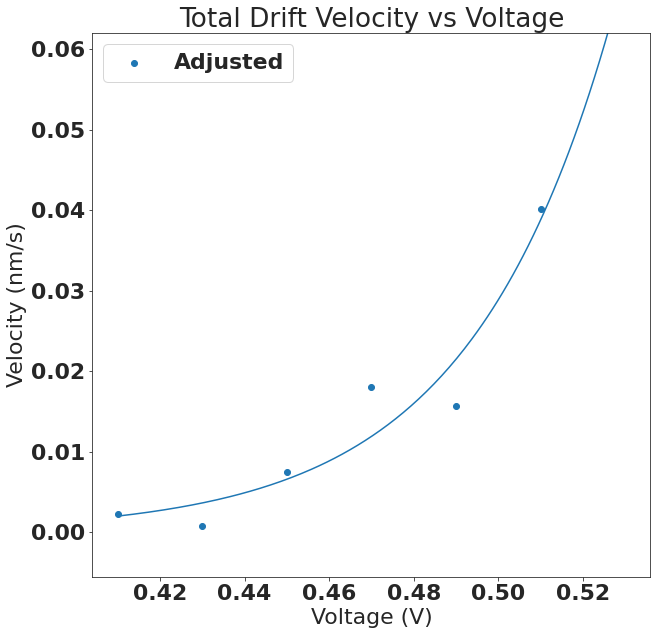

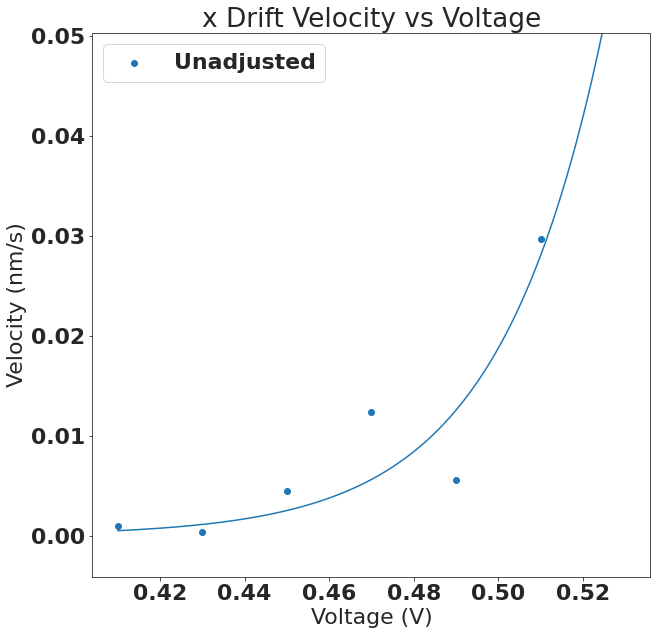

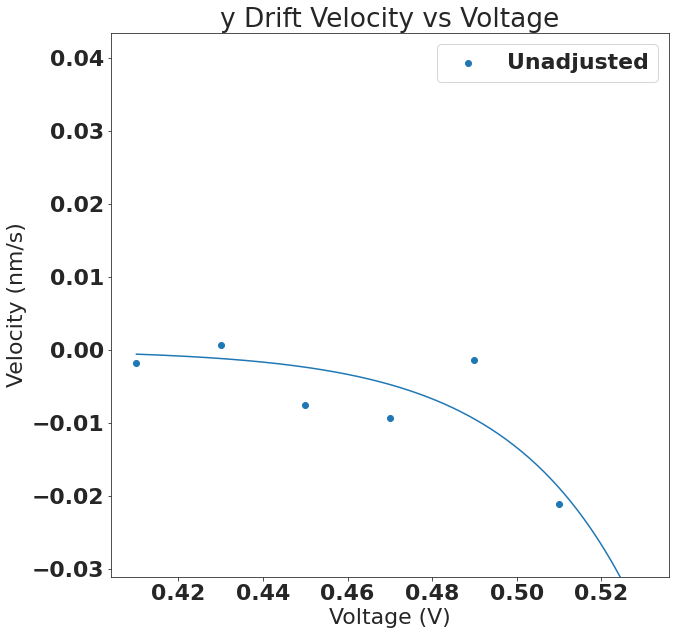

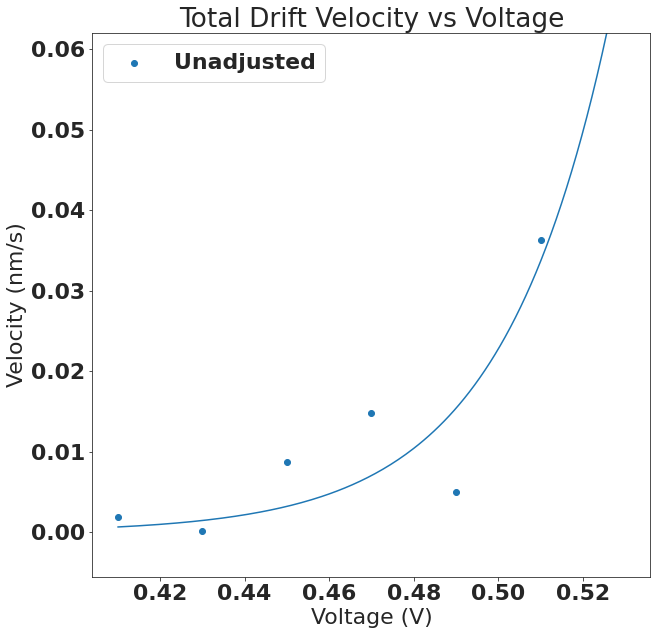

In [1058]:
GOODPOINTS=6
una=plot_adrift_v_2(fitfunc=(lambda x,b,a,:a*b**x),unadj=False,p0=[2,1],fitname=NAME,a=GOODPOINTS)
ad=plot_adrift_v_2(fitfunc=(lambda x,b,a,:a*b**x),adj=False,p0=[2,1],fitname=NAME,a=GOODPOINTS)
speedx,speedy,speedt=ad[0]
mspeedx,mspeedy,mspeedt=una[1]

/home/a/as/asai/dsgo/venv/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in power
  if sys.path[0] == '':


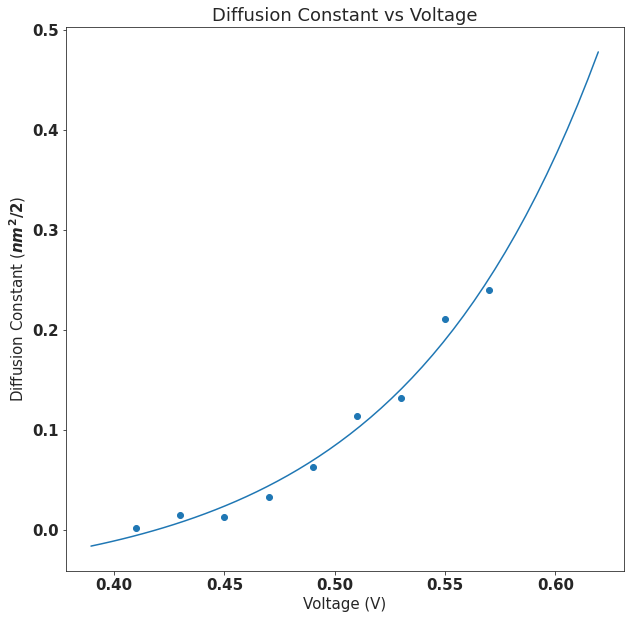

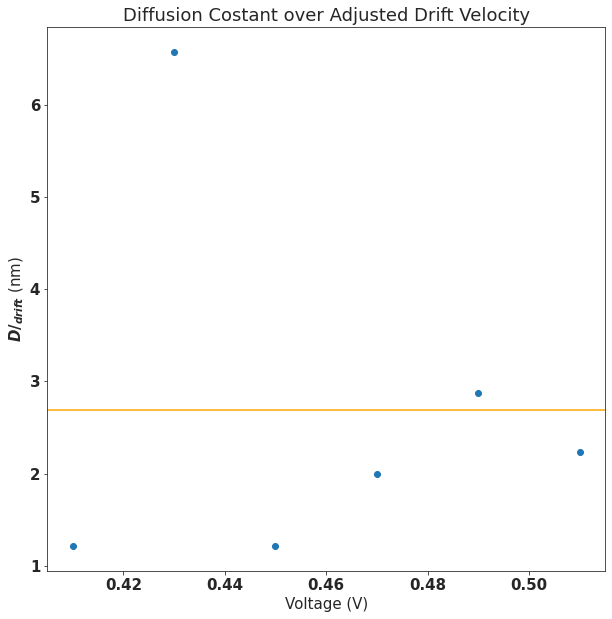

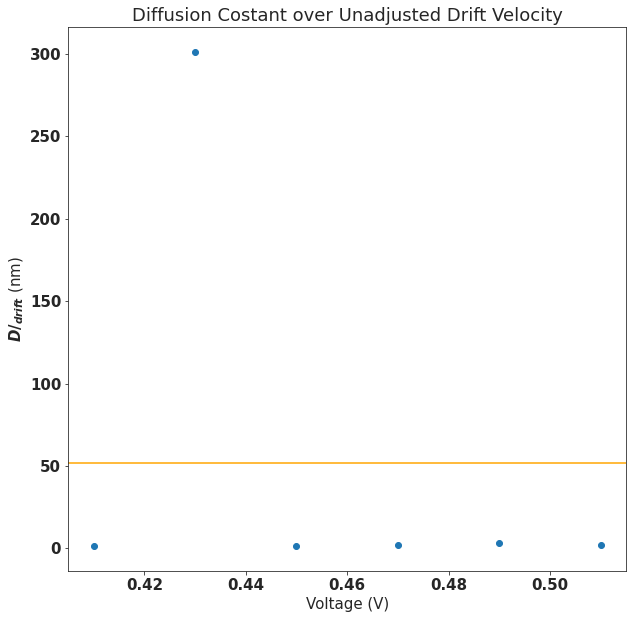

In [583]:
## #Plot diffusion constant
GOODPOINTS=6
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 15}
plt.rc('font', **font)
plt.figure()
plt.title('Diffusion Constant vs Voltage')
plt.xlabel("Voltage (V)")
plt.ylabel(r"Diffusion Constant ($nm^2/2$)")
plt.scatter(dp.tpmv[:-1],dp._sorted_D_constants[:-1])
par,cov=scipy.optimize.curve_fit((lambda x,a,b,c:a*b**x+c),dp.tpmv[:-1],dp._sorted_D_constants[:-1])
fitx=np.linspace(dp.tpmv[0]-abs(dp.tpmv[0])*0.05,dp.tpmv[-1]+abs(dp.tpmv[-1]*0.05),50)
plt.plot(fitx,par[0]*par[1]**fitx+par[2])
plt.savefig(m.ANALYSIS_FOLDER+"Diffusion_Constant_fit")
plt.figure()

D_V_unadj=np.array(dp._sorted_D_constants[:GOODPOINTS]/mspeedt[:GOODPOINTS])
D_V_adj=np.array(dp._sorted_D_constants[:GOODPOINTS]/speedt[:GOODPOINTS])

ylim=np.amax(np.concatenate((D_V_unadj,D_V_adj)))
ytick=np.linspace(-1,np.ceil(ylim), int((np.ceil(ylim))+2))
# Plot D over adjusted drift
plt.title('Diffusion Costant over Adjusted Drift Velocity')
plt.xlabel('Voltage (V)')
plt.ylabel(r'$D/_{drift}$ (nm)')
plt.scatter(dp.tpmv[:GOODPOINTS],D_V_adj)
plt.axhline(y=np.mean(D_V_adj), color='orange', linestyle='-')
#plt.ylim(bottom=0,top=ylim*1.1)
plt.savefig(m.ANALYSIS_FOLDER+"Diffusion_Constant_over_drift_adj")
#plt.yticks(ytick+1)
plt.figure()
# Plot D over unadjusted drift
plt.title('Diffusion Costant over Unadjusted Drift Velocity')
plt.xlabel('Voltage (V)')
plt.ylabel(r'$D/_{drift}$ (nm)')
#plt.ylim(bottom=0,top=ylim*1.1)
#plt.yticks(ytick+1)
plt.scatter(dp.tpmv[:GOODPOINTS],D_V_unadj)
plt.axhline(y=np.mean(D_V_unadj), color='orange', linestyle='-')
plt.savefig(m.ANALYSIS_FOLDER+"Diffusion_Constant_over_drift_unadj")

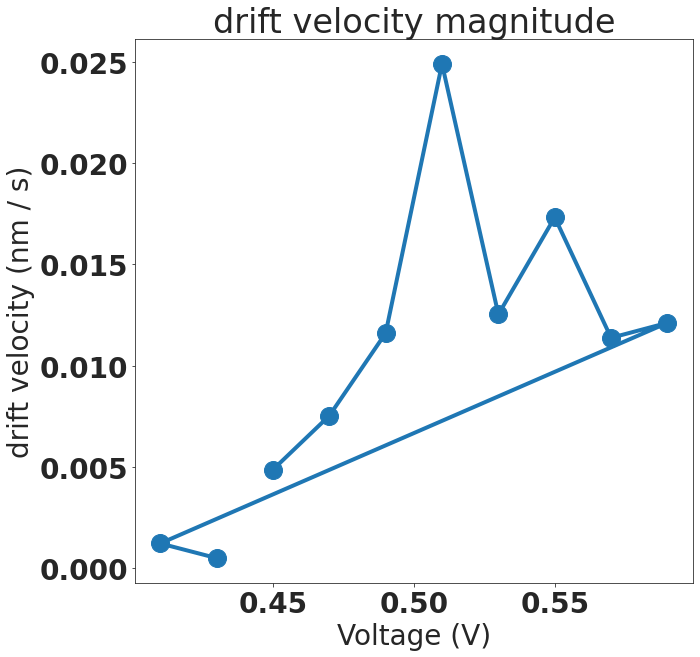

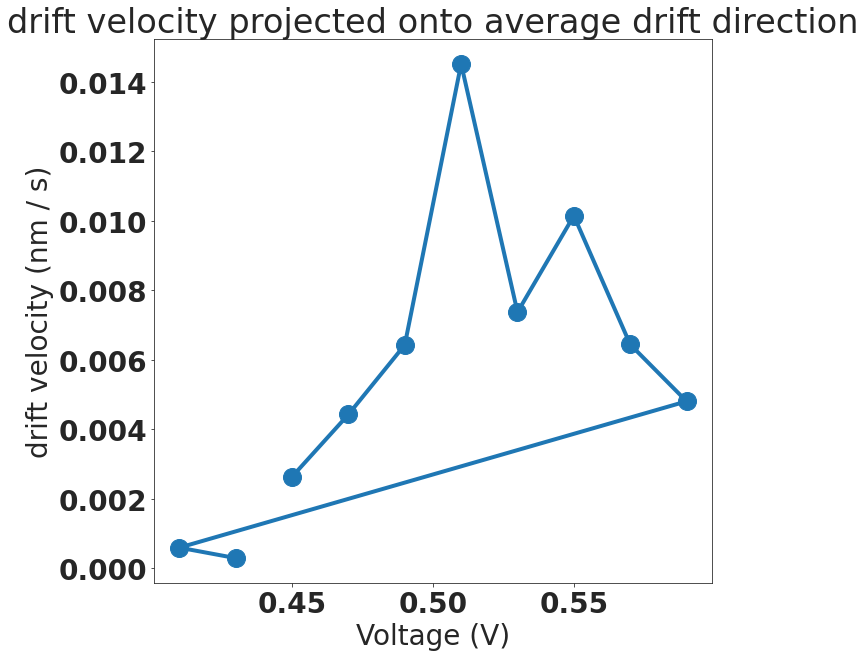

In [994]:
dp.plot_drift_scalar()

In [1028]:
for i in (8,9,0,1,2,3,4,5,6,7):
    h=_calculate_displacements(m,m.t3s[i])
    print((np.mean(h['dy'])**2+np.mean(h['dx'])**2)**0.5/m.DIFFUSION_TIME)

0.0024532556724802075
0.0005033164355318731
0.009736546727417038
0.015057886862369224
0.023213814582812596
0.04979801539075642
0.025065491183615497
0.034652503875295164
0.02275487711072491
0.02423495393308802


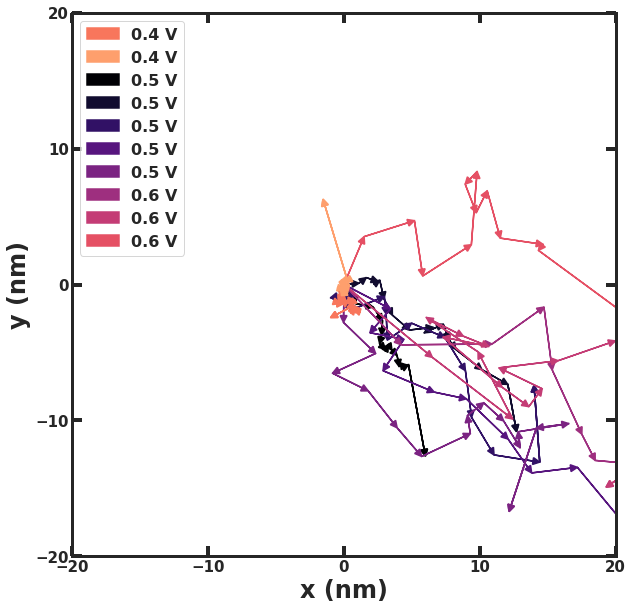

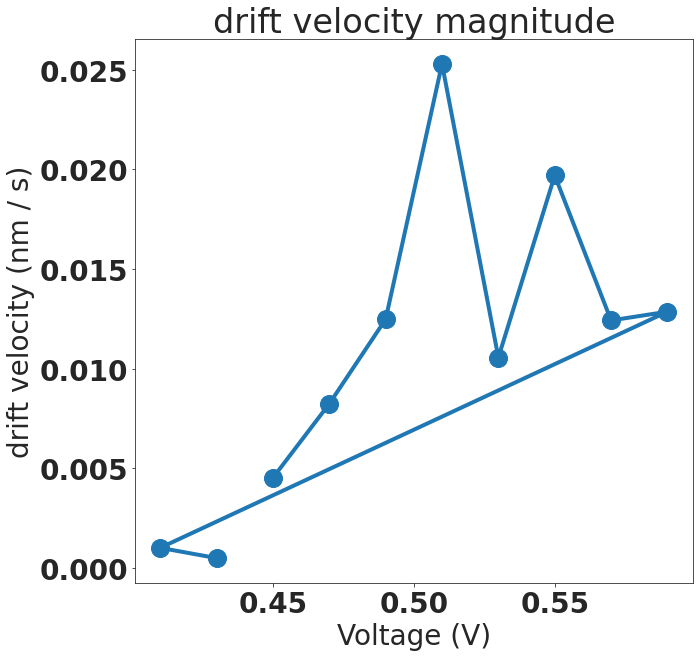

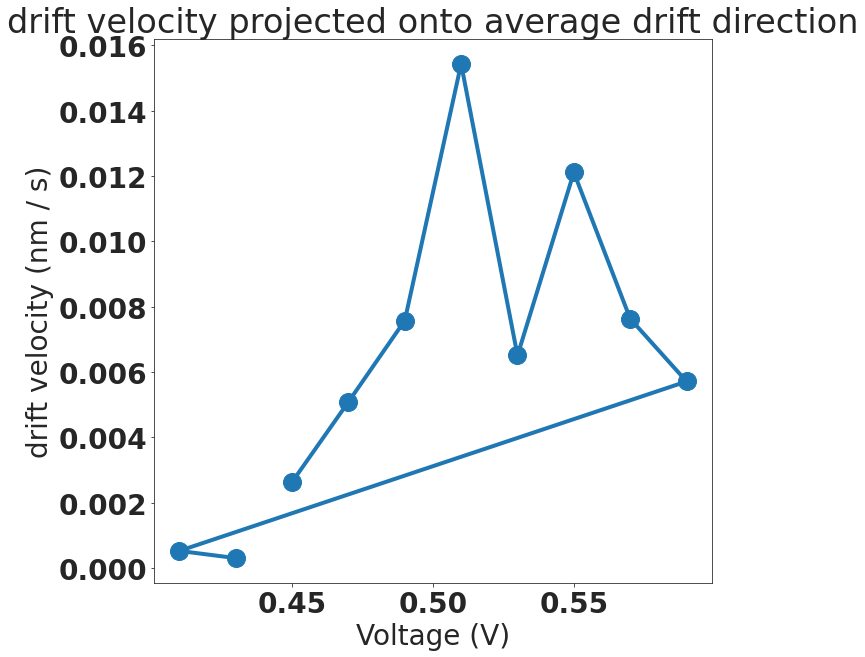

In [575]:
dp.plot_drift_data()

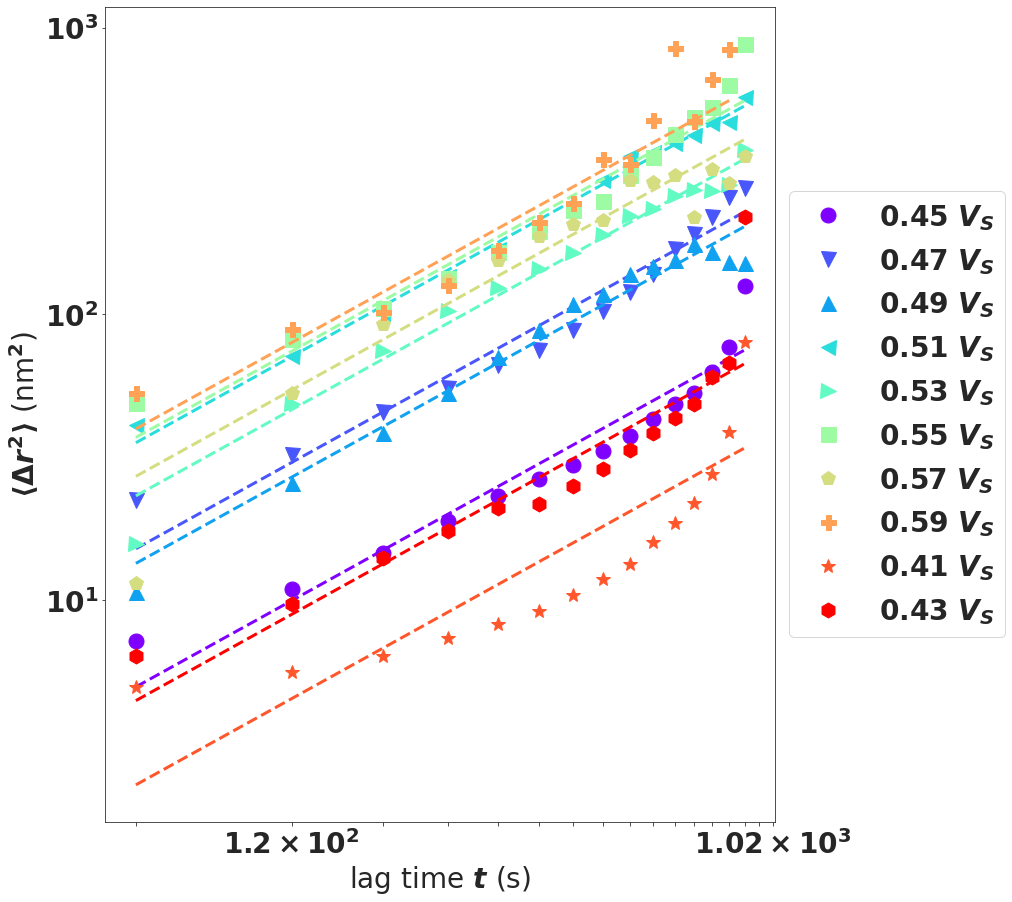

In [576]:
dp.plot_msd()

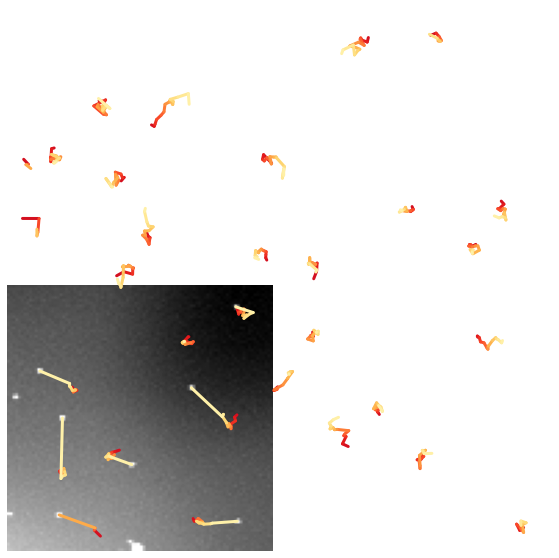

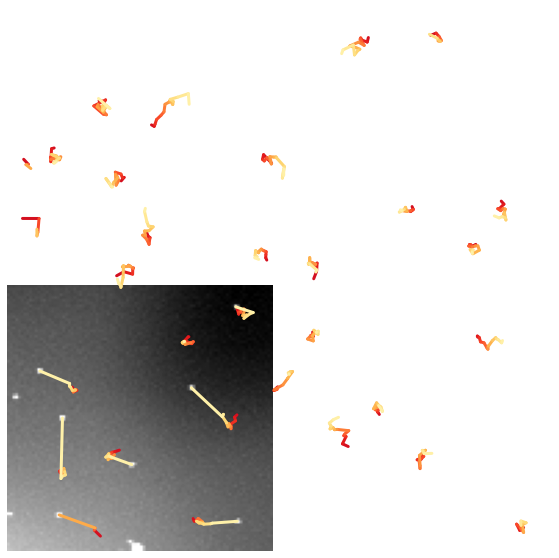

In [577]:
dp.plot_rocket_tracks(set_i=-1, image_i=-1) 

/home/a/as/asai/dsgo/venv/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


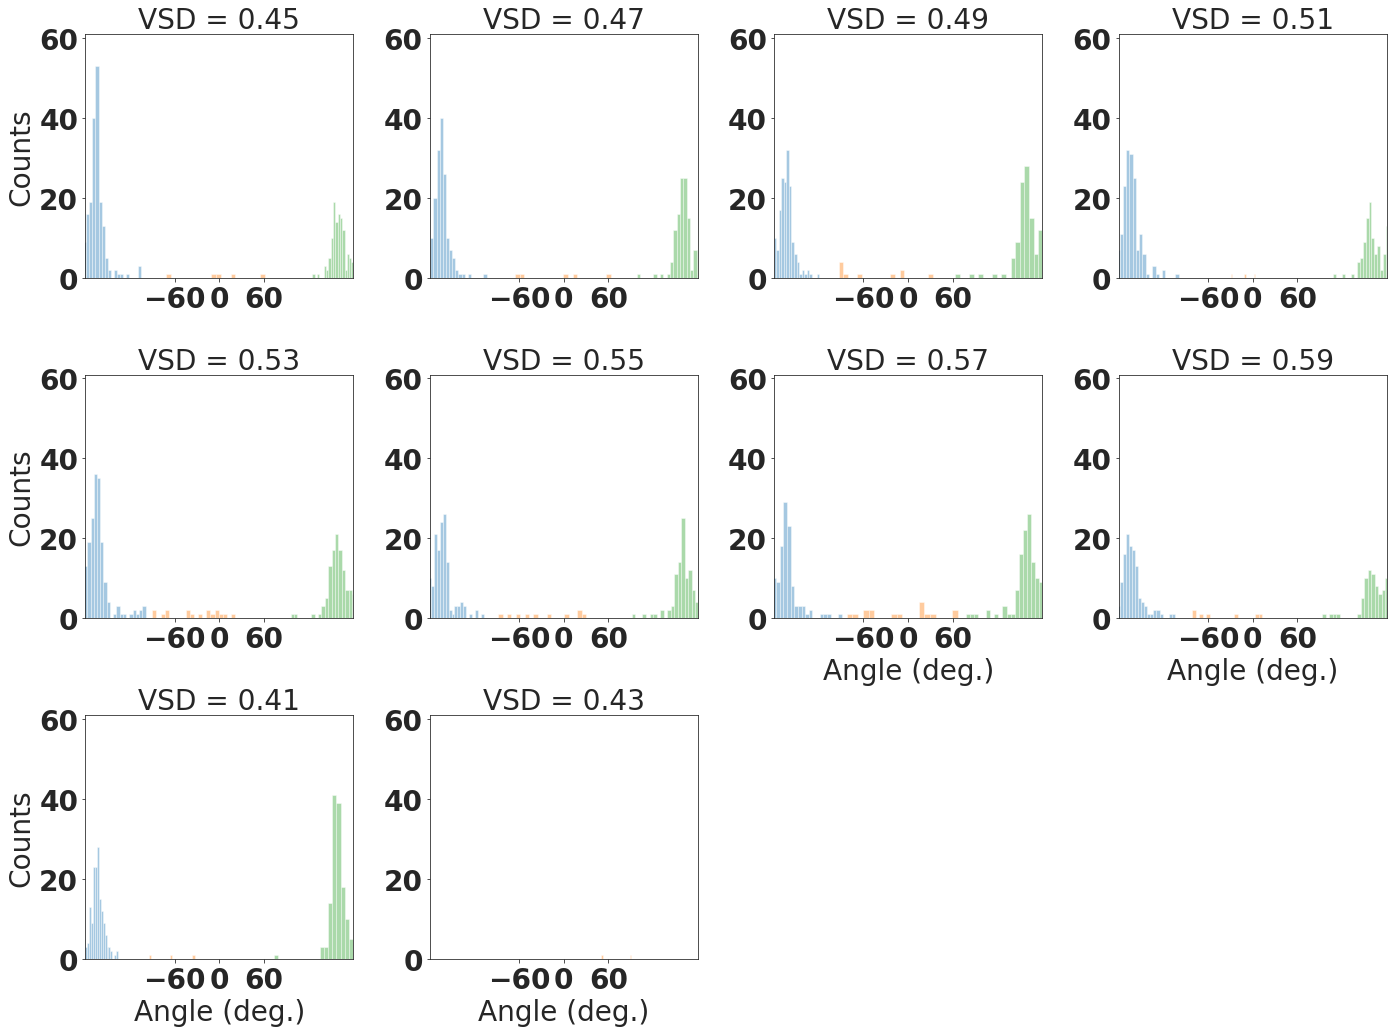

In [578]:
dp.plot_orientation_dist()

0.45
0.47
0.49
0.51
0.53
0.55
0.57
0.59
0.41
0.43


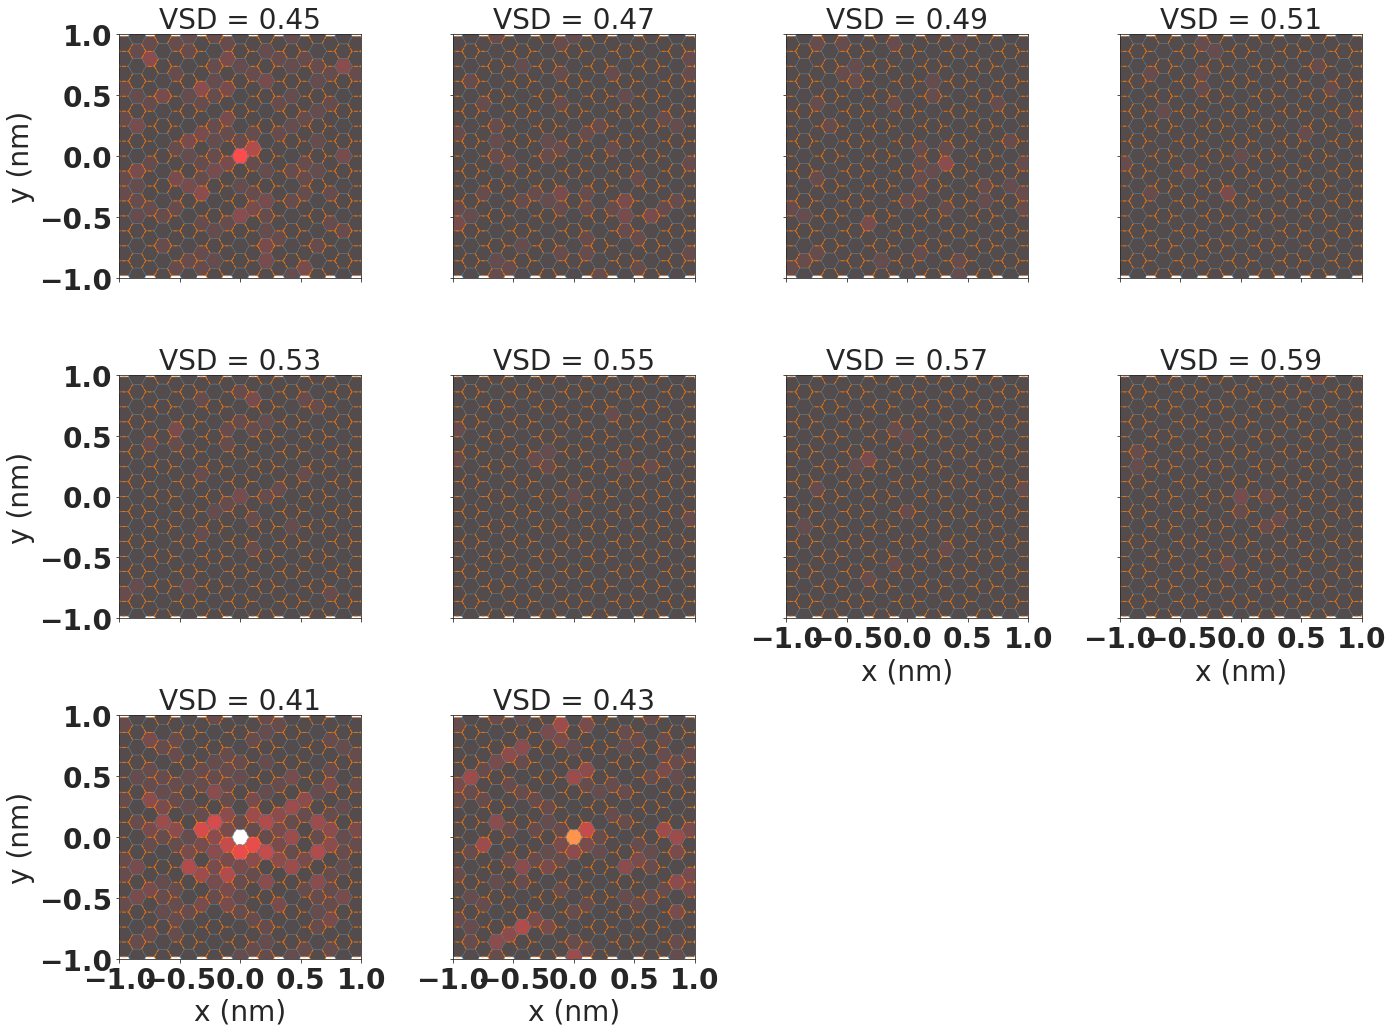

In [579]:
dp.plot_hexbins() 

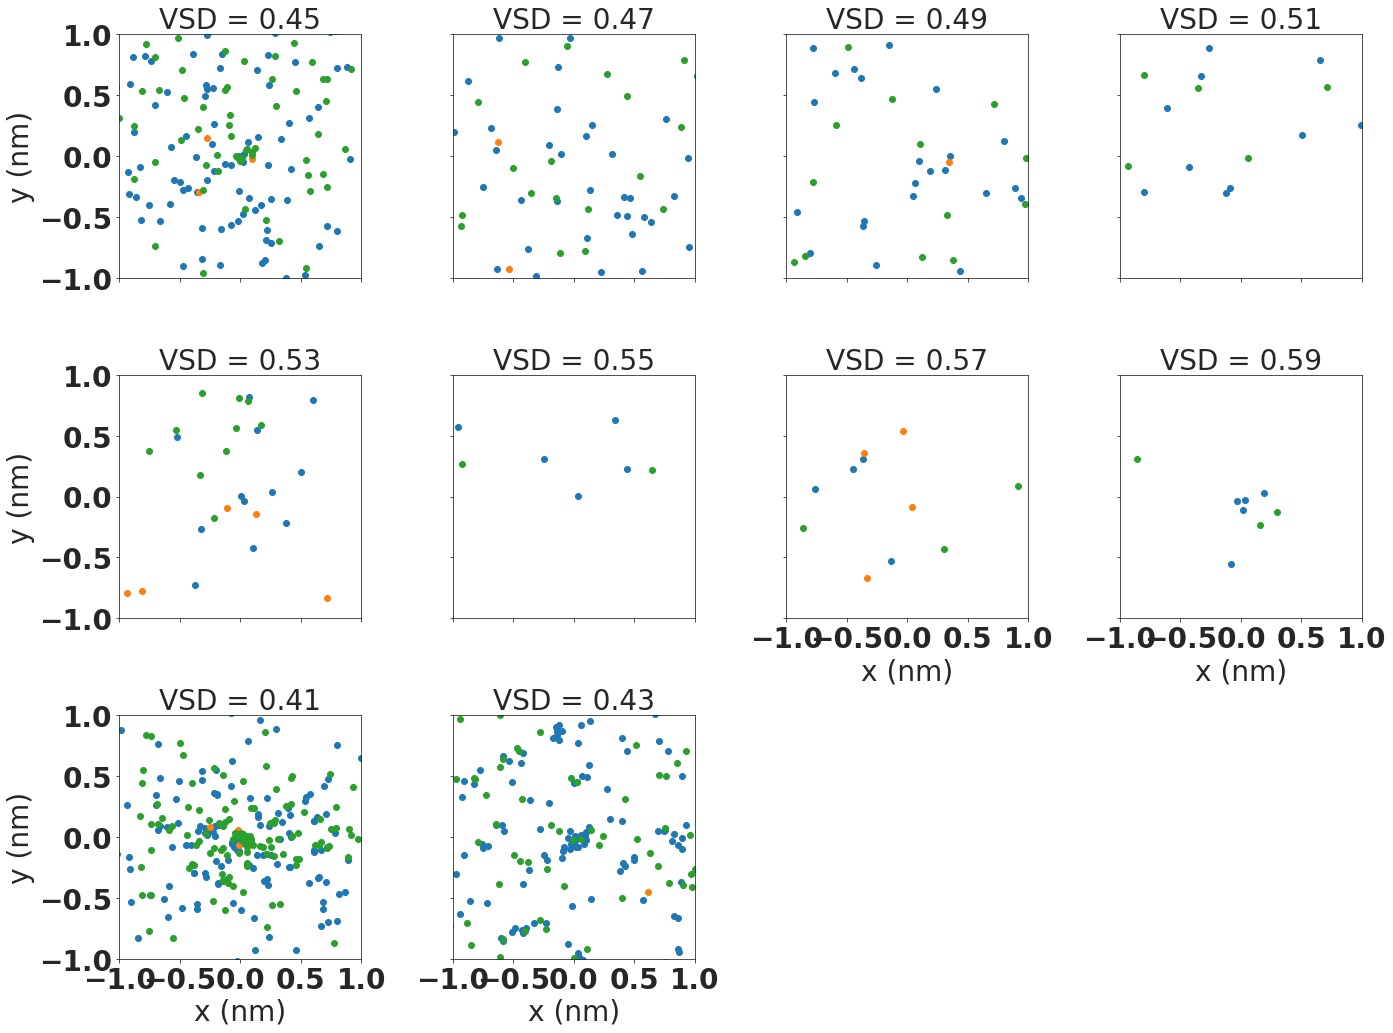

In [580]:
dp.plot_rots()

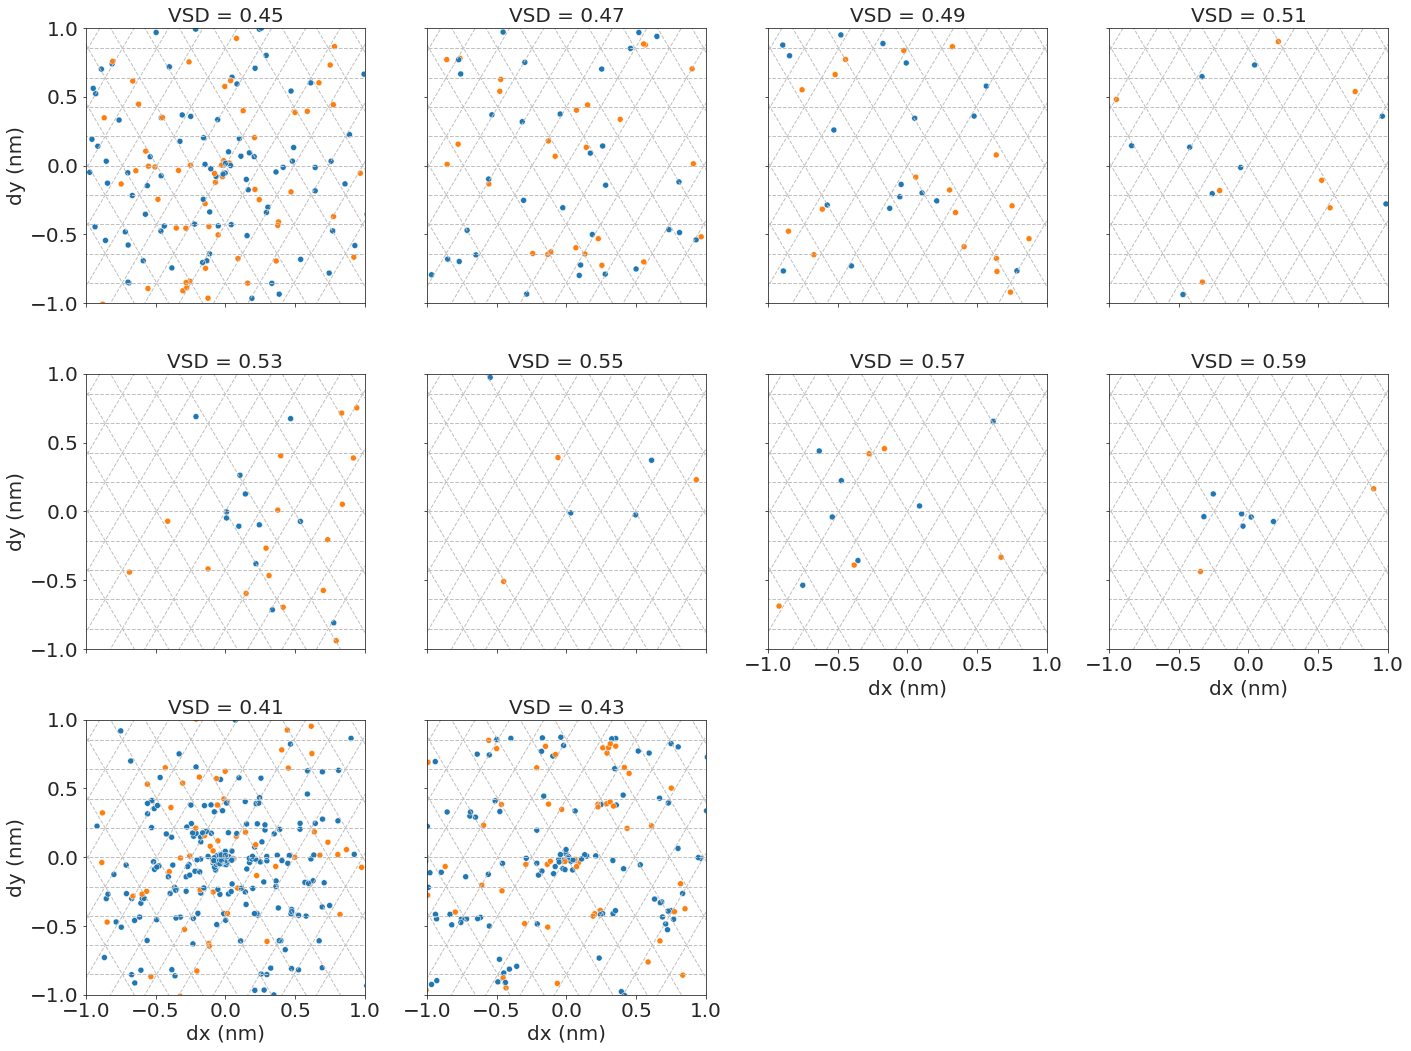

In [581]:
dp.plot_scatter()

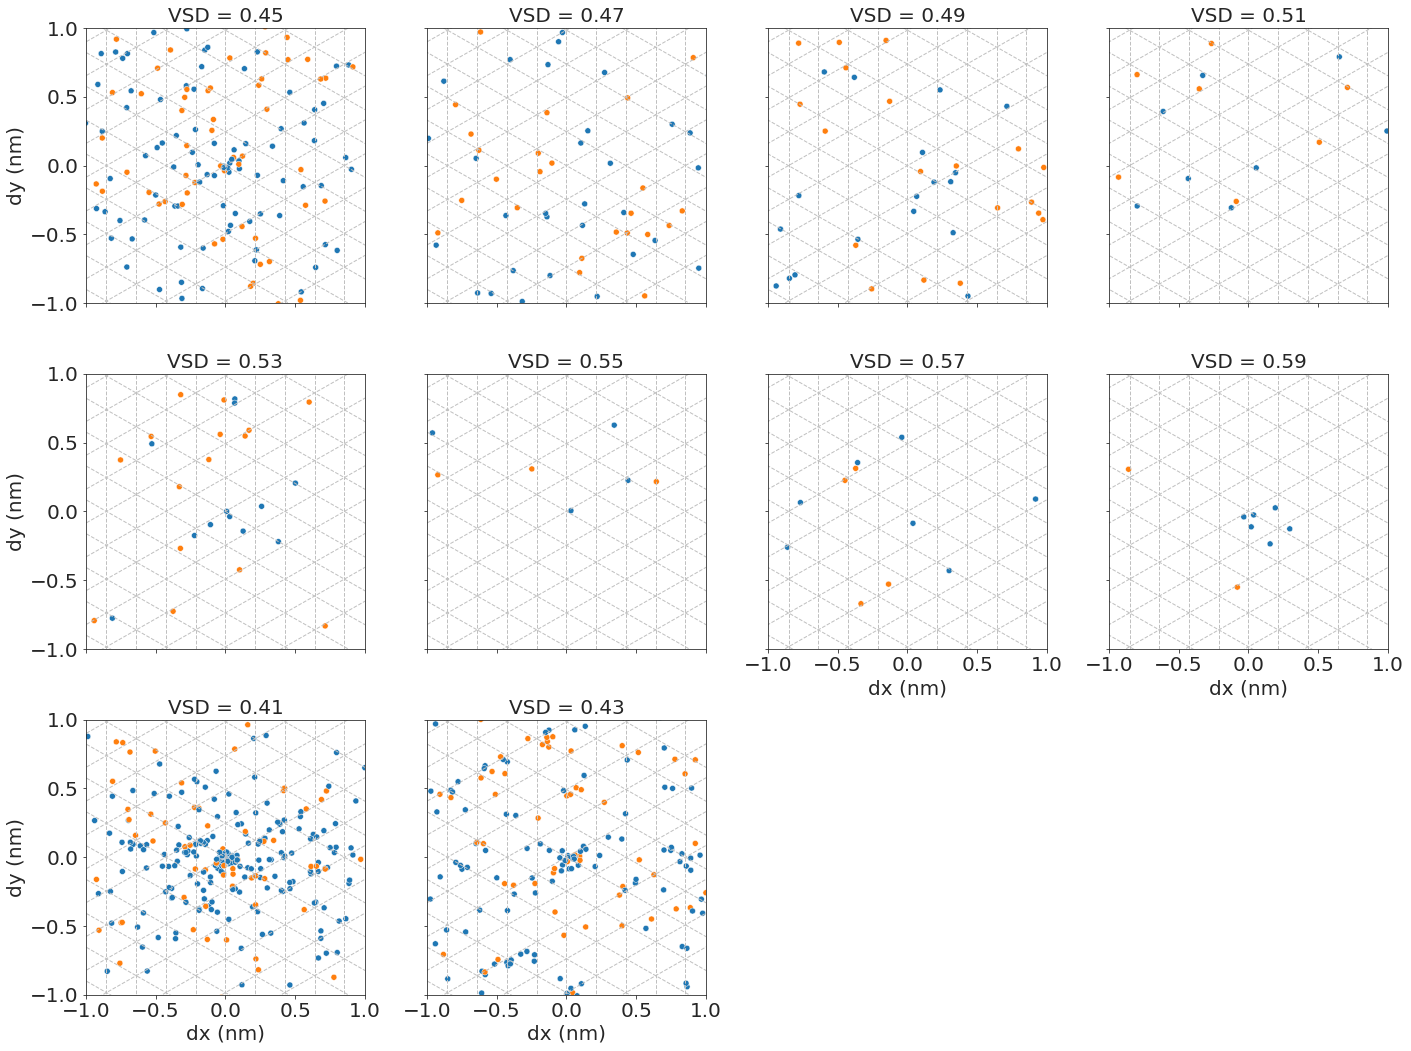

In [582]:
dp.plot_scatter_rot()

In [11]:
nmax=3
#If there's issues, check nmax because it's fucked up usually idk
def plot_adrift_vs_D(a_drift=a_drift,m=m,a=np.size(voltages_temperatures),fitfunc='connect',unadj=True,adj=True,p0=None,fitname='',legend=True,flip=False):
    """takes in a_drift, m, a (points plotted from start), fitfunc (connect for no fit). 
    Plots drifts veloc vs voltages returns them, also returns fit parameters """
    #sorting by voltage temp
    font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 20}
    
    sort=voltages_temperatures[:a].argsort()
    vt_sort=voltages_temperatures[sort]
    names=['x','y','Total']
    file=['','']
    data=[plot_drift_fit(a_drift,i,measured=True,m=m,show=False,nmax=nmax) for i in range(a)]
    speeds=[np.array([data[trial][0][compo] for trial in range(a)])[sort] for compo in range(3)]
    mspeeds=[np.array([data[trial][1][compo] for trial in range(a)])[sort] for compo in range(3)]
    par1=None
    par2=None
    ymax_=np.array([np.amax(np.array(data)[:,:,q]) for q in range (3)])
    ymin_=np.array([np.amin(np.array(data)[:,:,q]) for q in range (3)])
    
    ymax=ymax_+0.05*(abs(ymax_-ymin_))
    ymin=ymin_-0.3*(abs(ymax_-ymin_))
    #positive no overlap
        #ymax_2=0.14#np.amax(dp._sorted_D_constants[:a])
        #ymin_2=np.amin(dp._sorted_D_constants[:a])
        #ymax2=ymax_2+0.05*(abs(ymax_2-ymin_2))
        #ymin2=-0.001#ymin_2+0.01*(abs(ymax_2-ymin_2))
    #positive overlap
        #ymax_2=0.14
        #ymin_2=np.amin(dp._sorted_D_constants[:a])
        #ymax2=0.125
        #ymin2=-0.015
    #positive overlap
    ymax_2=0.14
    ymin_2=np.amin(dp._sorted_D_constants[:a])
    ymax2=0.05
    ymin2=-0.005
    q=2    
    plt.rc('font', **font)
    fig, ax1 = plt.subplots(figsize=(16,10))
    ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
    ax2.scatter(dp.tpmv[:a],dp._sorted_D_constants[:a],color='darkgreen',label='Diffusion Constant',s=300,marker='^')
    par,cov=scipy.optimize.curve_fit((lambda x,a,b:a*b**x),dp.tpmv[:a],dp._sorted_D_constants[:a],p0=[2,1])
    fitx=np.linspace(dp.tpmv[0],dp.tpmv[a-1]*1.01,50)
    ax2.plot(fitx,par[0]*par[1]**fitx,color='forestgreen',linewidth=5,zorder=0)
    color = 'tab:green'
    ax2.set_ylabel(r"Diffusion Constant ($nm^2/s$)",)  # we already handled the x-label with ax1
    ax2.tick_params(axis='y', )
    ax2.set_ylim(bottom=ymin2,top=ymax2)
    ax1.set_title(f' Drift Velocity and Diffusion Constant vs Voltage')
    ax1.set_xlabel('Voltage (V)')
    ax1.set_ylabel('Velocity ($nm/s$)')
    ax1.set_ylim(bottom=ymin[q],top=ymax[q])
    if unadj:
        file[0]='unadj'
        ax1.scatter(vt_sort[:a],mspeeds[q][:a],color='blue',label='Velocity')
        if fitfunc=='connect':
            ax1.plot(vt_sort[:a],mspeeds[q][:a],label='Velocity',color='blue')
        else:
            par,cov=scipy.optimize.curve_fit(fitfunc,vt_sort[:a],mspeeds[q][:a],p0=p0,maxfev=5000)
            v=np.linspace(vt_sort[0],vt_sort[a-1]*1.01,200)
            ax1.plot(v,fitfunc(v,*par))
            par1=par
    if adj:
        file[1]='adj'
        ax1.scatter(vt_sort[:a],speeds[q][:a],color='darkblue',label='Velocity',s=200,marker='s')
        if fitfunc=='connect':
            ax1.plot(vt_sort[:a],speeds[q][:a],color='mediu',label='Velocity')
        else:
            par,cov=scipy.optimize.curve_fit(fitfunc,vt_sort[:a],speeds[q][:a],p0=p0,maxfev=5000)
            v=np.linspace(vt_sort[0],vt_sort[a-1]*1.01,200)
            ax1.plot(v,fitfunc(v,*par),linewidth=5,color='blue',zorder=0)
            par2=par
    if legend:
        ax2.legend(loc='lower right')
        ax1.legend()

    if flip:
        plt.gca().invert_xaxis()

        #plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
        #plt.savefig('./Luc Folder/'+f'{FOLDER}{names[q]}')
        #plt.savefig(m.ANALYSIS_FOLDER + f"{file[1]}{file[0]}{names[q]}drift{fitname}.png")
    #plt.savefig(f'./Luc Folder/VvDpos2.svg')
    return([speeds,mspeeds,par1,par2],ax2)
ad=plot_adrift_vs_D(fitfunc=(lambda x,a,b:a*b**x),unadj=True,p0=[2,1],fitname=NAME,a=6,legend=True,flip=True)

#


NameError: name 'a_drift' is not defined